In [1]:
colab = 1
if colab :
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github/Opti-Project/src/baselines

Mounted at /content/drive
/content/drive/MyDrive/Github/Opti-Project/src/baselines


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
from pathlib import Path
train_path = Path(os.path.dirname(os.getcwd())) / "vision_experiments"
sys.path.insert(1,str(train_path))

In [4]:
import random
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import functools
from train_utils import *
from plot_utils import *
from pathlib import Path
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from typing import List, Optional
from typing import Dict, KeysView, ValuesView

In [5]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#32 42 73
set_seed(42)

cuda:0


In [6]:
train_loader, val_loader, test_loader = get_data("MNIST")

Train dataset: 54000 batch size 64 of dim torch.Size([1, 28, 28])
Validation dataset: 6000 batch size 64 of dim torch.Size([1, 28, 28])
Test dataset: 10000 batch size 64 of dim torch.Size([1, 28, 28])


In [7]:
optimizers = {"SGD" : "torch.optim.SGD(model.parameters(), lr=2e-4,nesterov=False,momentum=0.0,weight_decay=0.0)",
     "MomentumSGD": "torch.optim.SGD(model.parameters(), lr=2e-4,nesterov=False,momentum=0.9,weight_decay=0.0)",
     "ClippedSGD" : "torch.optim.SGD(model.parameters(), lr=2e-4,nesterov=False,momentum=0.0,weight_decay=0.0)",
     "Adagrad": "torch.optim.Adagrad(model.parameters(), lr=2e-4, weight_decay=0.0)",
    "Adam" : "torch.optim.Adam(model.parameters(),lr=2e-4, eps= 1e-4, weight_decay= 0.0)"
    }

def try_descent_strategies(model_name, optimizers, forward) :
  flatten = True
  input_size = train_loader.dataset[0][0].nelement()
  num_classes = 10
  nb_epochs = 30
  for opt in optimizers :
    if model_name == "logistic_reg" :
      model = LogisticRegression(input_size=input_size,output_size=num_classes)
    elif model_name == "multiLayerNet" :
      model = NeuralNet(input_size=input_size,output_size=num_classes, hidden_sizes=[1024, 1024])
    elif model_name == "convNet" :
      model = ConvNet(input_size=1, output_size=num_classes)
      flatten = False
    model.to(device)
    optimizer = eval(optimizers[opt])
    k_value = 1e-4
    lr_lambda = functools.partial(exponential_lr_decay, k=k_value)
    scheduler = LambdaLR(optimizer, lr_lambda)
    output_path = Path(model_name+"_runs/forward/") if forward else Path(model_name+"_runs/backward/")
    run_name = model_name + opt
    print(run_name)
    clip_val = 1 if opt=="ClippedSGD" else 0
    if forward :
      _, _, _, _, run_path = train_validate_forward(
        device,
        nb_epochs,
        model,
        run_name,
        input_size,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        output_path,
        gradient_clip_val=clip_val,
        flatten=flatten)
    else :
        _, _, _, _, run_path = train_validate_backward(
        device,
        nb_epochs,
        model,
        run_name,
        input_size,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        output_path,
        gradient_clip_val=clip_val,
        flatten=flatten)
    test_results = evaluate(device, model, input_size, test_loader, run_path=run_path, flatten=flatten)
    print("test results")
    print(test_results)


# Train, validate, evaluate

## Logistic Regression

In [ ]:
class LogisticRegression(nn.Module):
    """
    Logistic Regression model
    """
    def __init__(self,input_size,num_classes):
        super(LogisticRegression,self).__init__()
        self.linear = nn.Linear(input_size,num_classes)

    def forward(self,feature):
        output = self.linear(feature)
        return output

### Backward

In [ ]:
try_descent_strategies("logistic_reg",optimizers, forward=False)

logistic_regSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.23it/s, iters_per_sec=59.2, vacc=0.812, vf1=0.791, vloss=1.16]


Epoch 1 lr: 0.0002 Averages : Train Loss: 1.7955 Val Loss: 1.3245 Train Acc: 0.4577 Val Acc: 0.6966 Train F1: 0.4194 Val F1: 0.6580
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.70it/s, iters_per_sec=58.7, vacc=0.729, vf1=0.665, vloss=1.06]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.1178 Val Loss: 0.9633 Train Acc: 0.7468 Val Acc: 0.7854 Train F1: 0.7149 Val F1: 0.7615
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.66it/s, iters_per_sec=57.6, vacc=0.771, vf1=0.769, vloss=0.902]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.8718 Val Loss: 0.8019 Train Acc: 0.8053 Val Acc: 0.8159 Train F1: 0.7854 Val F1: 0.7975
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.02it/s, iters_per_sec=57, vacc=0.812, vf1=0.773, vloss=0.701]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.7480 Val Loss: 0.7099 Train Acc: 0.8287 Val Acc: 0.8358 Train F1: 0.8105 Val F1: 0.8159
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.99it/s, iters_per_sec=57, vacc=0.875, vf1=0.873, vloss=0.709]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.6728 Val Loss: 0.6507 Train Acc: 0.8427 Val Acc: 0.8446 Train F1: 0.8264 Val F1: 0.8290
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.74it/s, iters_per_sec=58.7, vacc=0.812, vf1=0.821, vloss=0.728]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.6218 Val Loss: 0.6088 Train Acc: 0.8522 Val Acc: 0.8527 Train F1: 0.8366 Val F1: 0.8328
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.64it/s, iters_per_sec=60.5, vacc=0.938, vf1=0.908, vloss=0.493]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.5846 Val Loss: 0.5765 Train Acc: 0.8576 Val Acc: 0.8579 Train F1: 0.8429 Val F1: 0.8398
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.51it/s, iters_per_sec=58.6, vacc=0.854, vf1=0.824, vloss=0.57]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.5560 Val Loss: 0.5520 Train Acc: 0.8625 Val Acc: 0.8628 Train F1: 0.8473 Val F1: 0.8484
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 61.09it/s, iters_per_sec=61, vacc=0.854, vf1=0.845, vloss=0.546]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.5333 Val Loss: 0.5319 Train Acc: 0.8666 Val Acc: 0.8663 Train F1: 0.8526 Val F1: 0.8533
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.62it/s, iters_per_sec=59.6, vacc=0.792, vf1=0.773, vloss=0.574]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.5149 Val Loss: 0.5154 Train Acc: 0.8698 Val Acc: 0.8695 Train F1: 0.8552 Val F1: 0.8552
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.93it/s, iters_per_sec=59.9, vacc=0.896, vf1=0.905, vloss=0.466]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.4994 Val Loss: 0.5012 Train Acc: 0.8726 Val Acc: 0.8712 Train F1: 0.8609 Val F1: 0.8582
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.44it/s, iters_per_sec=59.4, vacc=0.833, vf1=0.803, vloss=0.555]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.4862 Val Loss: 0.4895 Train Acc: 0.8748 Val Acc: 0.8726 Train F1: 0.8621 Val F1: 0.8622
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.60it/s, iters_per_sec=60.6, vacc=0.917, vf1=0.899, vloss=0.406]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.4748 Val Loss: 0.4787 Train Acc: 0.8766 Val Acc: 0.8761 Train F1: 0.8625 Val F1: 0.8635
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.33it/s, iters_per_sec=56.3, vacc=0.812, vf1=0.814, vloss=0.601]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.4649 Val Loss: 0.4701 Train Acc: 0.8786 Val Acc: 0.8778 Train F1: 0.8664 Val F1: 0.8643
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.41it/s, iters_per_sec=55.4, vacc=0.833, vf1=0.769, vloss=0.493]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.4561 Val Loss: 0.4616 Train Acc: 0.8803 Val Acc: 0.8804 Train F1: 0.8683 Val F1: 0.8666
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.41it/s, iters_per_sec=56.4, vacc=0.938, vf1=0.935, vloss=0.355]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.4483 Val Loss: 0.4540 Train Acc: 0.8813 Val Acc: 0.8815 Train F1: 0.8681 Val F1: 0.8684
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.73it/s, iters_per_sec=54.7, vacc=0.896, vf1=0.893, vloss=0.458]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.4412 Val Loss: 0.4478 Train Acc: 0.8826 Val Acc: 0.8830 Train F1: 0.8706 Val F1: 0.8715
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 61.37it/s, iters_per_sec=61.3, vacc=0.854, vf1=0.845, vloss=0.464]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.4349 Val Loss: 0.4418 Train Acc: 0.8833 Val Acc: 0.8848 Train F1: 0.8712 Val F1: 0.8727
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.09it/s, iters_per_sec=59, vacc=0.938, vf1=0.878, vloss=0.36]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.4291 Val Loss: 0.4361 Train Acc: 0.8847 Val Acc: 0.8860 Train F1: 0.8723 Val F1: 0.8726
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.44it/s, iters_per_sec=60.4, vacc=0.812, vf1=0.821, vloss=0.438]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.4238 Val Loss: 0.4313 Train Acc: 0.8858 Val Acc: 0.8863 Train F1: 0.8747 Val F1: 0.8748
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 61.22it/s, iters_per_sec=61.2, vacc=0.896, vf1=0.862, vloss=0.477]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.4189 Val Loss: 0.4268 Train Acc: 0.8866 Val Acc: 0.8869 Train F1: 0.8738 Val F1: 0.8709
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.56it/s, iters_per_sec=60.5, vacc=0.896, vf1=0.871, vloss=0.314]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.4144 Val Loss: 0.4222 Train Acc: 0.8874 Val Acc: 0.8875 Train F1: 0.8753 Val F1: 0.8741
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.14it/s, iters_per_sec=60.1, vacc=0.917, vf1=0.914, vloss=0.341]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.4103 Val Loss: 0.4183 Train Acc: 0.8880 Val Acc: 0.8887 Train F1: 0.8761 Val F1: 0.8781
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.89it/s, iters_per_sec=59.8, vacc=0.938, vf1=0.919, vloss=0.326]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.4063 Val Loss: 0.4146 Train Acc: 0.8891 Val Acc: 0.8895 Train F1: 0.8768 Val F1: 0.8776
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.50it/s, iters_per_sec=60.5, vacc=0.979, vf1=0.982, vloss=0.21]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.4027 Val Loss: 0.4109 Train Acc: 0.8899 Val Acc: 0.8901 Train F1: 0.8776 Val F1: 0.8799
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.34it/s, iters_per_sec=58.3, vacc=0.812, vf1=0.817, vloss=0.488]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.3993 Val Loss: 0.4083 Train Acc: 0.8904 Val Acc: 0.8906 Train F1: 0.8786 Val F1: 0.8794
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.21it/s, iters_per_sec=58.2, vacc=0.896, vf1=0.892, vloss=0.44]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.3961 Val Loss: 0.4052 Train Acc: 0.8910 Val Acc: 0.8910 Train F1: 0.8791 Val F1: 0.8775
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.04it/s, iters_per_sec=56, vacc=0.833, vf1=0.822, vloss=0.529]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.3931 Val Loss: 0.4026 Train Acc: 0.8915 Val Acc: 0.8913 Train F1: 0.8806 Val F1: 0.8801
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.83it/s, iters_per_sec=58.8, vacc=0.833, vf1=0.795, vloss=0.444]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.3902 Val Loss: 0.3997 Train Acc: 0.8920 Val Acc: 0.8920 Train F1: 0.8805 Val F1: 0.8767
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.63it/s, iters_per_sec=58.6, vacc=0.938, vf1=0.934, vloss=0.315]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.3875 Val Loss: 0.3967 Train Acc: 0.8929 Val Acc: 0.8926 Train F1: 0.8805 Val F1: 0.8815
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 58.36it/s, eval_acc=0.875, eval_f1=0.883, iters_per_sec=58.3]


test results
{'Acc': 0.9010748407643312, 'F1': 0.8907924488370421}
logistic_regMomentumSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.69it/s, iters_per_sec=57.7, vacc=0.875, vf1=0.869, vloss=0.467]


Epoch 1 lr: 0.0002 Averages : Train Loss: 0.7921 Val Loss: 0.5123 Train Acc: 0.7984 Val Acc: 0.8675 Train F1: 0.7788 Val F1: 0.8550
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.20it/s, iters_per_sec=60.2, vacc=0.896, vf1=0.883, vloss=0.379]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 0.4551 Val Loss: 0.4297 Train Acc: 0.8780 Val Acc: 0.8819 Train F1: 0.8649 Val F1: 0.8660
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.56it/s, iters_per_sec=57.5, vacc=0.958, vf1=0.951, vloss=0.239]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.4021 Val Loss: 0.3952 Train Acc: 0.8894 Val Acc: 0.8887 Train F1: 0.8779 Val F1: 0.8782
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.02it/s, iters_per_sec=59.9, vacc=0.875, vf1=0.78, vloss=0.436]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.3757 Val Loss: 0.3765 Train Acc: 0.8955 Val Acc: 0.8943 Train F1: 0.8839 Val F1: 0.8809
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.48it/s, iters_per_sec=59.5, vacc=0.958, vf1=0.932, vloss=0.212]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.3592 Val Loss: 0.3627 Train Acc: 0.8994 Val Acc: 0.8958 Train F1: 0.8896 Val F1: 0.8868
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.95it/s, iters_per_sec=55.9, vacc=0.938, vf1=0.932, vloss=0.35]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.3475 Val Loss: 0.3535 Train Acc: 0.9023 Val Acc: 0.8976 Train F1: 0.8920 Val F1: 0.8856
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.08it/s, iters_per_sec=60.1, vacc=0.917, vf1=0.904, vloss=0.236]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.3385 Val Loss: 0.3461 Train Acc: 0.9049 Val Acc: 0.8990 Train F1: 0.8950 Val F1: 0.8866
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.98it/s, iters_per_sec=57.9, vacc=0.875, vf1=0.861, vloss=0.33]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.3316 Val Loss: 0.3404 Train Acc: 0.9066 Val Acc: 0.9003 Train F1: 0.8960 Val F1: 0.8891
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.27it/s, iters_per_sec=59.2, vacc=0.938, vf1=0.944, vloss=0.14]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.3256 Val Loss: 0.3358 Train Acc: 0.9086 Val Acc: 0.9018 Train F1: 0.8984 Val F1: 0.8902
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.52it/s, iters_per_sec=57.5, vacc=0.917, vf1=0.88, vloss=0.188]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.3209 Val Loss: 0.3315 Train Acc: 0.9096 Val Acc: 0.9027 Train F1: 0.9003 Val F1: 0.8937
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.79it/s, iters_per_sec=56.8, vacc=0.917, vf1=0.882, vloss=0.37]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.3168 Val Loss: 0.3286 Train Acc: 0.9111 Val Acc: 0.9039 Train F1: 0.9014 Val F1: 0.8937
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.75it/s, iters_per_sec=56.7, vacc=0.917, vf1=0.915, vloss=0.284]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.3132 Val Loss: 0.3254 Train Acc: 0.9119 Val Acc: 0.9042 Train F1: 0.9022 Val F1: 0.8933
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.42it/s, iters_per_sec=57.4, vacc=0.917, vf1=0.911, vloss=0.238]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.3100 Val Loss: 0.3232 Train Acc: 0.9124 Val Acc: 0.9055 Train F1: 0.9028 Val F1: 0.8939
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.91it/s, iters_per_sec=55.9, vacc=0.917, vf1=0.9, vloss=0.297]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.3072 Val Loss: 0.3212 Train Acc: 0.9130 Val Acc: 0.9065 Train F1: 0.9043 Val F1: 0.8989
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.05it/s, iters_per_sec=59, vacc=0.854, vf1=0.835, vloss=0.517]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.3046 Val Loss: 0.3197 Train Acc: 0.9137 Val Acc: 0.9072 Train F1: 0.9043 Val F1: 0.8986
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.49it/s, iters_per_sec=59.5, vacc=0.938, vf1=0.932, vloss=0.215]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.3024 Val Loss: 0.3171 Train Acc: 0.9150 Val Acc: 0.9071 Train F1: 0.9063 Val F1: 0.8976
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.39it/s, iters_per_sec=59.4, vacc=0.875, vf1=0.834, vloss=0.439]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.3003 Val Loss: 0.3161 Train Acc: 0.9151 Val Acc: 0.9071 Train F1: 0.9058 Val F1: 0.8956
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.91it/s, iters_per_sec=58.9, vacc=0.979, vf1=0.968, vloss=0.151]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.2984 Val Loss: 0.3138 Train Acc: 0.9164 Val Acc: 0.9082 Train F1: 0.9073 Val F1: 0.9015
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.93it/s, iters_per_sec=58.9, vacc=0.917, vf1=0.921, vloss=0.294]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.2966 Val Loss: 0.3128 Train Acc: 0.9166 Val Acc: 0.9082 Train F1: 0.9071 Val F1: 0.8996
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.65it/s, iters_per_sec=58.6, vacc=0.896, vf1=0.892, vloss=0.311]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.2950 Val Loss: 0.3124 Train Acc: 0.9169 Val Acc: 0.9086 Train F1: 0.9072 Val F1: 0.9009
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.31it/s, iters_per_sec=59.3, vacc=0.938, vf1=0.914, vloss=0.276]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.2934 Val Loss: 0.3110 Train Acc: 0.9175 Val Acc: 0.9091 Train F1: 0.9087 Val F1: 0.8985
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.77it/s, iters_per_sec=58.8, vacc=0.875, vf1=0.845, vloss=0.297]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.2920 Val Loss: 0.3101 Train Acc: 0.9184 Val Acc: 0.9089 Train F1: 0.9096 Val F1: 0.8989
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.24it/s, iters_per_sec=59.2, vacc=0.875, vf1=0.793, vloss=0.412]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.2908 Val Loss: 0.3091 Train Acc: 0.9187 Val Acc: 0.9092 Train F1: 0.9089 Val F1: 0.8963
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.48it/s, iters_per_sec=59.5, vacc=0.917, vf1=0.909, vloss=0.218]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.2895 Val Loss: 0.3078 Train Acc: 0.9185 Val Acc: 0.9099 Train F1: 0.9098 Val F1: 0.8979
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.62it/s, iters_per_sec=56.6, vacc=0.896, vf1=0.898, vloss=0.468]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.2882 Val Loss: 0.3074 Train Acc: 0.9194 Val Acc: 0.9110 Train F1: 0.9110 Val F1: 0.8999
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.48it/s, iters_per_sec=57.4, vacc=0.958, vf1=0.937, vloss=0.123]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.2871 Val Loss: 0.3060 Train Acc: 0.9196 Val Acc: 0.9111 Train F1: 0.9108 Val F1: 0.8997
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.23it/s, iters_per_sec=56.2, vacc=0.938, vf1=0.895, vloss=0.206]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.2860 Val Loss: 0.3055 Train Acc: 0.9198 Val Acc: 0.9104 Train F1: 0.9108 Val F1: 0.9000
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.98it/s, iters_per_sec=57.9, vacc=0.917, vf1=0.908, vloss=0.164]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.2852 Val Loss: 0.3045 Train Acc: 0.9203 Val Acc: 0.9113 Train F1: 0.9111 Val F1: 0.9021
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.39it/s, iters_per_sec=59.4, vacc=0.896, vf1=0.888, vloss=0.345]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.2842 Val Loss: 0.3044 Train Acc: 0.9209 Val Acc: 0.9111 Train F1: 0.9124 Val F1: 0.8998
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.30it/s, iters_per_sec=59.3, vacc=0.896, vf1=0.891, vloss=0.423]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.2833 Val Loss: 0.3044 Train Acc: 0.9208 Val Acc: 0.9120 Train F1: 0.9121 Val F1: 0.9036
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.26it/s, eval_acc=0.938, eval_f1=0.933, iters_per_sec=59.2]


test results
{'Acc': 0.9204816878980892, 'F1': 0.9103708157941391}
logistic_regClippedSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.69it/s, iters_per_sec=60.6, vacc=0.396, vf1=0.267, vloss=1.97]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.2493 Val Loss: 2.0575 Train Acc: 0.1771 Val Acc: 0.2758 Train F1: 0.1527 Val F1: 0.2420
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.91it/s, iters_per_sec=59.8, vacc=0.604, vf1=0.528, vloss=1.7]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.8801 Val Loss: 1.7336 Train Acc: 0.4083 Val Acc: 0.5103 Train F1: 0.3696 Val F1: 0.4696
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.48it/s, iters_per_sec=59.4, vacc=0.667, vf1=0.619, vloss=1.38]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 1.5946 Val Loss: 1.4803 Train Acc: 0.5927 Val Acc: 0.6426 Train F1: 0.5531 Val F1: 0.6041
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.16it/s, iters_per_sec=60.1, vacc=0.646, vf1=0.645, vloss=1.41]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 1.3710 Val Loss: 1.2846 Train Acc: 0.6873 Val Acc: 0.7132 Train F1: 0.6528 Val F1: 0.6830
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.90it/s, iters_per_sec=58.9, vacc=0.75, vf1=0.676, vloss=1.21]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 1.1976 Val Loss: 1.1332 Train Acc: 0.7412 Val Acc: 0.7512 Train F1: 0.7134 Val F1: 0.7230
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.70it/s, iters_per_sec=60.6, vacc=0.792, vf1=0.735, vloss=0.933]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 1.0634 Val Loss: 1.0157 Train Acc: 0.7724 Val Acc: 0.7787 Train F1: 0.7477 Val F1: 0.7549
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.74it/s, iters_per_sec=60.7, vacc=0.833, vf1=0.815, vloss=0.889]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.9595 Val Loss: 0.9249 Train Acc: 0.7953 Val Acc: 0.7963 Train F1: 0.7729 Val F1: 0.7731
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.88it/s, iters_per_sec=59.8, vacc=0.812, vf1=0.787, vloss=0.817]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.8778 Val Loss: 0.8530 Train Acc: 0.8103 Val Acc: 0.8090 Train F1: 0.7906 Val F1: 0.7866
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.22it/s, iters_per_sec=59.2, vacc=0.771, vf1=0.753, vloss=0.711]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.8129 Val Loss: 0.7950 Train Acc: 0.8204 Val Acc: 0.8185 Train F1: 0.8015 Val F1: 0.7969
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.79it/s, iters_per_sec=58.8, vacc=0.771, vf1=0.761, vloss=0.738]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.7601 Val Loss: 0.7480 Train Acc: 0.8287 Val Acc: 0.8252 Train F1: 0.8104 Val F1: 0.8095
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.24it/s, iters_per_sec=59.2, vacc=0.708, vf1=0.682, vloss=0.844]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.7168 Val Loss: 0.7091 Train Acc: 0.8353 Val Acc: 0.8315 Train F1: 0.8196 Val F1: 0.8144
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.79it/s, iters_per_sec=58.8, vacc=0.792, vf1=0.75, vloss=0.767]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.6806 Val Loss: 0.6761 Train Acc: 0.8413 Val Acc: 0.8367 Train F1: 0.8256 Val F1: 0.8233
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.88it/s, iters_per_sec=56.8, vacc=0.812, vf1=0.795, vloss=0.662]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.6501 Val Loss: 0.6480 Train Acc: 0.8456 Val Acc: 0.8414 Train F1: 0.8286 Val F1: 0.8246
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.86it/s, iters_per_sec=56.8, vacc=0.833, vf1=0.812, vloss=0.601]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.6241 Val Loss: 0.6240 Train Acc: 0.8498 Val Acc: 0.8460 Train F1: 0.8339 Val F1: 0.8282
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.81it/s, iters_per_sec=55.8, vacc=0.833, vf1=0.797, vloss=0.63]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.6018 Val Loss: 0.6032 Train Acc: 0.8533 Val Acc: 0.8493 Train F1: 0.8382 Val F1: 0.8302
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.91it/s, iters_per_sec=56.9, vacc=0.896, vf1=0.863, vloss=0.439]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.5822 Val Loss: 0.5847 Train Acc: 0.8563 Val Acc: 0.8533 Train F1: 0.8418 Val F1: 0.8388
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.94it/s, iters_per_sec=58.9, vacc=0.854, vf1=0.834, vloss=0.677]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.5651 Val Loss: 0.5693 Train Acc: 0.8586 Val Acc: 0.8563 Train F1: 0.8436 Val F1: 0.8399
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.45it/s, iters_per_sec=56.4, vacc=0.854, vf1=0.85, vloss=0.543]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.5500 Val Loss: 0.5547 Train Acc: 0.8610 Val Acc: 0.8578 Train F1: 0.8471 Val F1: 0.8446
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.16it/s, iters_per_sec=60.1, vacc=0.875, vf1=0.863, vloss=0.424]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.5365 Val Loss: 0.5417 Train Acc: 0.8631 Val Acc: 0.8585 Train F1: 0.8490 Val F1: 0.8409
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.80it/s, iters_per_sec=58.8, vacc=0.875, vf1=0.838, vloss=0.438]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.5244 Val Loss: 0.5303 Train Acc: 0.8657 Val Acc: 0.8605 Train F1: 0.8525 Val F1: 0.8457
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.74it/s, iters_per_sec=60.7, vacc=0.812, vf1=0.782, vloss=0.632]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.5136 Val Loss: 0.5205 Train Acc: 0.8675 Val Acc: 0.8620 Train F1: 0.8541 Val F1: 0.8479
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.15it/s, iters_per_sec=60.1, vacc=0.938, vf1=0.928, vloss=0.437]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.5037 Val Loss: 0.5106 Train Acc: 0.8693 Val Acc: 0.8650 Train F1: 0.8555 Val F1: 0.8547
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.39it/s, iters_per_sec=58.4, vacc=0.875, vf1=0.866, vloss=0.511]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.4947 Val Loss: 0.5022 Train Acc: 0.8709 Val Acc: 0.8672 Train F1: 0.8582 Val F1: 0.8522
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.82it/s, iters_per_sec=59.7, vacc=0.917, vf1=0.909, vloss=0.419]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.4865 Val Loss: 0.4941 Train Acc: 0.8724 Val Acc: 0.8683 Train F1: 0.8600 Val F1: 0.8543
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.27it/s, iters_per_sec=60.2, vacc=0.854, vf1=0.842, vloss=0.539]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.4790 Val Loss: 0.4872 Train Acc: 0.8737 Val Acc: 0.8693 Train F1: 0.8608 Val F1: 0.8539
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.71it/s, iters_per_sec=57.7, vacc=0.896, vf1=0.873, vloss=0.544]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.4720 Val Loss: 0.4806 Train Acc: 0.8750 Val Acc: 0.8699 Train F1: 0.8614 Val F1: 0.8594
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.90it/s, iters_per_sec=59.9, vacc=0.896, vf1=0.873, vloss=0.462]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.4656 Val Loss: 0.4741 Train Acc: 0.8764 Val Acc: 0.8701 Train F1: 0.8639 Val F1: 0.8547
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.99it/s, iters_per_sec=58, vacc=0.938, vf1=0.938, vloss=0.386]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.4596 Val Loss: 0.4682 Train Acc: 0.8775 Val Acc: 0.8708 Train F1: 0.8642 Val F1: 0.8572
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.78it/s, iters_per_sec=57.7, vacc=0.875, vf1=0.852, vloss=0.484]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.4541 Val Loss: 0.4631 Train Acc: 0.8786 Val Acc: 0.8725 Train F1: 0.8664 Val F1: 0.8552
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.48it/s, iters_per_sec=58.4, vacc=0.812, vf1=0.804, vloss=0.469]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.4489 Val Loss: 0.4580 Train Acc: 0.8796 Val Acc: 0.8733 Train F1: 0.8677 Val F1: 0.8603
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.67it/s, eval_acc=0.875, eval_f1=0.883, iters_per_sec=59.6]


test results
{'Acc': 0.8871417197452229, 'F1': 0.8763050290660986}
logistic_regAdagrad


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.54it/s, iters_per_sec=57.5, vacc=0.646, vf1=0.653, vloss=1.37]


Epoch 1 lr: 0.0002 Averages : Train Loss: 1.6497 Val Loss: 1.3711 Train Acc: 0.5534 Val Acc: 0.6882 Train F1: 0.5135 Val F1: 0.6461
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.82it/s, iters_per_sec=58.8, vacc=0.792, vf1=0.731, vloss=1.13]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.2479 Val Loss: 1.1525 Train Acc: 0.7263 Val Acc: 0.7451 Train F1: 0.6946 Val F1: 0.7179
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.55it/s, iters_per_sec=55.5, vacc=0.729, vf1=0.758, vloss=1.05]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 1.0854 Val Loss: 1.0317 Train Acc: 0.7646 Val Acc: 0.7730 Train F1: 0.7378 Val F1: 0.7456
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.82it/s, iters_per_sec=59.8, vacc=0.875, vf1=0.858, vloss=0.685]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.9864 Val Loss: 0.9508 Train Acc: 0.7842 Val Acc: 0.7879 Train F1: 0.7612 Val F1: 0.7623
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.20it/s, iters_per_sec=59.1, vacc=0.854, vf1=0.839, vloss=0.875]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.9175 Val Loss: 0.8932 Train Acc: 0.7982 Val Acc: 0.7986 Train F1: 0.7758 Val F1: 0.7752
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.22it/s, iters_per_sec=58.2, vacc=0.771, vf1=0.765, vloss=0.858]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.8656 Val Loss: 0.8483 Train Acc: 0.8086 Val Acc: 0.8067 Train F1: 0.7888 Val F1: 0.7858
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.74it/s, iters_per_sec=58.7, vacc=0.875, vf1=0.888, vloss=0.698]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.8248 Val Loss: 0.8118 Train Acc: 0.8162 Val Acc: 0.8145 Train F1: 0.7966 Val F1: 0.7981
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.04it/s, iters_per_sec=59, vacc=0.833, vf1=0.808, vloss=0.847]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.7916 Val Loss: 0.7824 Train Acc: 0.8220 Val Acc: 0.8205 Train F1: 0.8022 Val F1: 0.7988
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.63it/s, iters_per_sec=59.6, vacc=0.812, vf1=0.726, vloss=0.887]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.7637 Val Loss: 0.7573 Train Acc: 0.8279 Val Acc: 0.8261 Train F1: 0.8097 Val F1: 0.8078
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.53it/s, iters_per_sec=60.5, vacc=0.771, vf1=0.769, vloss=0.813]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.7400 Val Loss: 0.7354 Train Acc: 0.8322 Val Acc: 0.8298 Train F1: 0.8141 Val F1: 0.8106
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.84it/s, iters_per_sec=59.8, vacc=0.854, vf1=0.847, vloss=0.689]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.7195 Val Loss: 0.7162 Train Acc: 0.8358 Val Acc: 0.8322 Train F1: 0.8206 Val F1: 0.8151
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.16it/s, iters_per_sec=60.1, vacc=0.688, vf1=0.69, vloss=0.937]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.7014 Val Loss: 0.7002 Train Acc: 0.8389 Val Acc: 0.8341 Train F1: 0.8216 Val F1: 0.8204
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.94it/s, iters_per_sec=59.9, vacc=0.833, vf1=0.813, vloss=0.624]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.6855 Val Loss: 0.6845 Train Acc: 0.8418 Val Acc: 0.8373 Train F1: 0.8263 Val F1: 0.8200
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.47it/s, iters_per_sec=57.4, vacc=0.854, vf1=0.863, vloss=0.581]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.6711 Val Loss: 0.6710 Train Acc: 0.8444 Val Acc: 0.8390 Train F1: 0.8267 Val F1: 0.8220
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.73it/s, iters_per_sec=56.7, vacc=0.854, vf1=0.858, vloss=0.554]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.6582 Val Loss: 0.6589 Train Acc: 0.8469 Val Acc: 0.8419 Train F1: 0.8308 Val F1: 0.8229
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.16it/s, iters_per_sec=56.1, vacc=0.854, vf1=0.834, vloss=0.582]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.6465 Val Loss: 0.6479 Train Acc: 0.8489 Val Acc: 0.8449 Train F1: 0.8336 Val F1: 0.8284
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.52it/s, iters_per_sec=57.5, vacc=0.875, vf1=0.854, vloss=0.524]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.6358 Val Loss: 0.6377 Train Acc: 0.8511 Val Acc: 0.8474 Train F1: 0.8358 Val F1: 0.8317
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.74it/s, iters_per_sec=57.7, vacc=0.896, vf1=0.901, vloss=0.495]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.6259 Val Loss: 0.6282 Train Acc: 0.8526 Val Acc: 0.8493 Train F1: 0.8379 Val F1: 0.8288
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.10it/s, iters_per_sec=57.1, vacc=0.875, vf1=0.838, vloss=0.61]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.6169 Val Loss: 0.6200 Train Acc: 0.8540 Val Acc: 0.8502 Train F1: 0.8399 Val F1: 0.8356
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.45it/s, iters_per_sec=59.4, vacc=0.979, vf1=0.981, vloss=0.364]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.6085 Val Loss: 0.6113 Train Acc: 0.8555 Val Acc: 0.8532 Train F1: 0.8399 Val F1: 0.8391
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.29it/s, iters_per_sec=58.3, vacc=0.896, vf1=0.898, vloss=0.537]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.6006 Val Loss: 0.6043 Train Acc: 0.8566 Val Acc: 0.8543 Train F1: 0.8413 Val F1: 0.8382
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.59it/s, iters_per_sec=57.5, vacc=0.75, vf1=0.738, vloss=0.825]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.5933 Val Loss: 0.5981 Train Acc: 0.8577 Val Acc: 0.8539 Train F1: 0.8439 Val F1: 0.8407
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.00it/s, iters_per_sec=59.9, vacc=0.896, vf1=0.899, vloss=0.602]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.5865 Val Loss: 0.5910 Train Acc: 0.8590 Val Acc: 0.8558 Train F1: 0.8441 Val F1: 0.8384
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.62it/s, iters_per_sec=57.6, vacc=0.896, vf1=0.893, vloss=0.516]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.5802 Val Loss: 0.5847 Train Acc: 0.8602 Val Acc: 0.8568 Train F1: 0.8459 Val F1: 0.8402
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.82it/s, iters_per_sec=57.8, vacc=0.958, vf1=0.964, vloss=0.348]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.5741 Val Loss: 0.5784 Train Acc: 0.8610 Val Acc: 0.8589 Train F1: 0.8473 Val F1: 0.8452
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.14it/s, iters_per_sec=59.1, vacc=0.917, vf1=0.909, vloss=0.599]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.5684 Val Loss: 0.5737 Train Acc: 0.8620 Val Acc: 0.8600 Train F1: 0.8479 Val F1: 0.8465
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.37it/s, iters_per_sec=60.3, vacc=0.854, vf1=0.842, vloss=0.61]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.5630 Val Loss: 0.5685 Train Acc: 0.8630 Val Acc: 0.8598 Train F1: 0.8482 Val F1: 0.8440
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.45it/s, iters_per_sec=60.4, vacc=0.938, vf1=0.923, vloss=0.423]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.5579 Val Loss: 0.5631 Train Acc: 0.8639 Val Acc: 0.8617 Train F1: 0.8501 Val F1: 0.8444
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.20it/s, iters_per_sec=57.1, vacc=0.875, vf1=0.859, vloss=0.628]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.5531 Val Loss: 0.5590 Train Acc: 0.8643 Val Acc: 0.8622 Train F1: 0.8513 Val F1: 0.8461
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.84it/s, iters_per_sec=56.8, vacc=0.875, vf1=0.855, vloss=0.505]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.5485 Val Loss: 0.5543 Train Acc: 0.8652 Val Acc: 0.8630 Train F1: 0.8510 Val F1: 0.8485
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.32it/s, eval_acc=0.812, eval_f1=0.763, iters_per_sec=59.3]


test results
{'Acc': 0.8729100318471338, 'F1': 0.8588663734520979}
logistic_regAdam


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.36it/s, iters_per_sec=58.3, vacc=0.854, vf1=0.84, vloss=0.433]


Epoch 1 lr: 0.0002 Averages : Train Loss: 0.6640 Val Loss: 0.4054 Train Acc: 0.8279 Val Acc: 0.8881 Train F1: 0.8122 Val F1: 0.8764
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.39it/s, iters_per_sec=59.3, vacc=0.938, vf1=0.935, vloss=0.266]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 0.3581 Val Loss: 0.3433 Train Acc: 0.8998 Val Acc: 0.9016 Train F1: 0.8892 Val F1: 0.8892
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.58it/s, iters_per_sec=57.5, vacc=0.896, vf1=0.902, vloss=0.325]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.3188 Val Loss: 0.3216 Train Acc: 0.9105 Val Acc: 0.9075 Train F1: 0.9011 Val F1: 0.8970
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.57it/s, iters_per_sec=57.5, vacc=0.938, vf1=0.922, vloss=0.312]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.3007 Val Loss: 0.3103 Train Acc: 0.9148 Val Acc: 0.9097 Train F1: 0.9049 Val F1: 0.8995
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.07it/s, iters_per_sec=55.1, vacc=0.938, vf1=0.904, vloss=0.203]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.2897 Val Loss: 0.3043 Train Acc: 0.9187 Val Acc: 0.9116 Train F1: 0.9098 Val F1: 0.9000
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.63it/s, iters_per_sec=54.6, vacc=0.979, vf1=0.981, vloss=0.103]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.2824 Val Loss: 0.3009 Train Acc: 0.9205 Val Acc: 0.9152 Train F1: 0.9104 Val F1: 0.9040
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.88it/s, iters_per_sec=54.8, vacc=0.896, vf1=0.821, vloss=0.384]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.2769 Val Loss: 0.2979 Train Acc: 0.9223 Val Acc: 0.9161 Train F1: 0.9138 Val F1: 0.9038
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.79it/s, iters_per_sec=53.8, vacc=0.917, vf1=0.903, vloss=0.213]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.2726 Val Loss: 0.2936 Train Acc: 0.9238 Val Acc: 0.9160 Train F1: 0.9152 Val F1: 0.9068
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.40it/s, iters_per_sec=56.4, vacc=0.979, vf1=0.982, vloss=0.209]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.2695 Val Loss: 0.2940 Train Acc: 0.9249 Val Acc: 0.9180 Train F1: 0.9160 Val F1: 0.9081


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.60it/s, iters_per_sec=58.6, vacc=0.896, vf1=0.877, vloss=0.3]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.2661 Val Loss: 0.2924 Train Acc: 0.9254 Val Acc: 0.9168 Train F1: 0.9178 Val F1: 0.9044
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.91it/s, iters_per_sec=56.8, vacc=0.917, vf1=0.891, vloss=0.384]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.2645 Val Loss: 0.2931 Train Acc: 0.9265 Val Acc: 0.9168 Train F1: 0.9187 Val F1: 0.9098


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.65it/s, iters_per_sec=57.6, vacc=0.917, vf1=0.913, vloss=0.353]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.2620 Val Loss: 0.2932 Train Acc: 0.9265 Val Acc: 0.9168 Train F1: 0.9182 Val F1: 0.9065


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.89it/s, iters_per_sec=55.8, vacc=0.958, vf1=0.943, vloss=0.189]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.2600 Val Loss: 0.2906 Train Acc: 0.9278 Val Acc: 0.9194 Train F1: 0.9200 Val F1: 0.9116
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.31it/s, iters_per_sec=58.3, vacc=0.854, vf1=0.842, vloss=0.395]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.2581 Val Loss: 0.2909 Train Acc: 0.9278 Val Acc: 0.9177 Train F1: 0.9195 Val F1: 0.9092


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.67it/s, iters_per_sec=57.6, vacc=0.958, vf1=0.969, vloss=0.186]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.2566 Val Loss: 0.2910 Train Acc: 0.9285 Val Acc: 0.9176 Train F1: 0.9201 Val F1: 0.9067


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.67it/s, iters_per_sec=58.6, vacc=0.917, vf1=0.902, vloss=0.545]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.2556 Val Loss: 0.2907 Train Acc: 0.9291 Val Acc: 0.9195 Train F1: 0.9211 Val F1: 0.9110


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.69it/s, iters_per_sec=55.7, vacc=0.917, vf1=0.931, vloss=0.378]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.2543 Val Loss: 0.2902 Train Acc: 0.9297 Val Acc: 0.9177 Train F1: 0.9227 Val F1: 0.9075
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.80it/s, iters_per_sec=59.8, vacc=0.938, vf1=0.946, vloss=0.356]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.2533 Val Loss: 0.2893 Train Acc: 0.9299 Val Acc: 0.9184 Train F1: 0.9217 Val F1: 0.9098
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.53it/s, iters_per_sec=56.5, vacc=0.875, vf1=0.842, vloss=0.22]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.2521 Val Loss: 0.2908 Train Acc: 0.9300 Val Acc: 0.9181 Train F1: 0.9219 Val F1: 0.9101


	Validating: 100%|██████████| 94/94 [00:01<00:00, 52.77it/s, iters_per_sec=52.7, vacc=0.833, vf1=0.822, vloss=0.432]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.2510 Val Loss: 0.2954 Train Acc: 0.9303 Val Acc: 0.9153 Train F1: 0.9227 Val F1: 0.9052


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.57it/s, iters_per_sec=59.5, vacc=0.938, vf1=0.911, vloss=0.213]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.2501 Val Loss: 0.2895 Train Acc: 0.9313 Val Acc: 0.9190 Train F1: 0.9230 Val F1: 0.9104


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.88it/s, iters_per_sec=57.9, vacc=0.938, vf1=0.856, vloss=0.3]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.2492 Val Loss: 0.2899 Train Acc: 0.9310 Val Acc: 0.9177 Train F1: 0.9242 Val F1: 0.9040


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.15it/s, iters_per_sec=58.2, vacc=0.875, vf1=0.79, vloss=0.317]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.2480 Val Loss: 0.2917 Train Acc: 0.9316 Val Acc: 0.9176 Train F1: 0.9236 Val F1: 0.9095


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.07it/s, iters_per_sec=59, vacc=0.875, vf1=0.86, vloss=0.536]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.2477 Val Loss: 0.2913 Train Acc: 0.9314 Val Acc: 0.9190 Train F1: 0.9240 Val F1: 0.9065


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.54it/s, iters_per_sec=57.5, vacc=0.958, vf1=0.944, vloss=0.266]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.2470 Val Loss: 0.2917 Train Acc: 0.9320 Val Acc: 0.9184 Train F1: 0.9257 Val F1: 0.9114


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.59it/s, iters_per_sec=57.5, vacc=0.896, vf1=0.914, vloss=0.293]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.2463 Val Loss: 0.2912 Train Acc: 0.9320 Val Acc: 0.9171 Train F1: 0.9247 Val F1: 0.9059


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.23it/s, iters_per_sec=55.2, vacc=0.896, vf1=0.891, vloss=0.211]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.2453 Val Loss: 0.2928 Train Acc: 0.9324 Val Acc: 0.9183 Train F1: 0.9242 Val F1: 0.9068


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.10it/s, iters_per_sec=56.1, vacc=0.938, vf1=0.919, vloss=0.158]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.2449 Val Loss: 0.2919 Train Acc: 0.9323 Val Acc: 0.9182 Train F1: 0.9250 Val F1: 0.9100


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.14it/s, iters_per_sec=56.1, vacc=0.896, vf1=0.876, vloss=0.392]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.2444 Val Loss: 0.2920 Train Acc: 0.9324 Val Acc: 0.9199 Train F1: 0.9247 Val F1: 0.9112


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.95it/s, iters_per_sec=55.9, vacc=0.938, vf1=0.94, vloss=0.324]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.2436 Val Loss: 0.2911 Train Acc: 0.9328 Val Acc: 0.9177 Train F1: 0.9252 Val F1: 0.9071


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.60it/s, eval_acc=0.938, eval_f1=0.933, iters_per_sec=57.6]

test results
{'Acc': 0.9273487261146497, 'F1': 0.9183748558727158}


### Forward

In [ ]:
try_descent_strategies("logistic_reg",optimizers, forward=True)

logistic_regSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.79it/s, iters_per_sec=54.8, vacc=0.625, vf1=0.517, vloss=1.39]


Epoch 1 lr: 0.0002 Averages : Train Loss: 1.8978 Val Loss: 1.4612 Train Acc: 0.3731 Val Acc: 0.5716 Train F1: 0.3327 Val F1: 0.5387
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.77it/s, iters_per_sec=53.7, vacc=0.708, vf1=0.634, vloss=1.14]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.2292 Val Loss: 1.0875 Train Acc: 0.6471 Val Acc: 0.6907 Train F1: 0.6126 Val F1: 0.6610
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.49it/s, iters_per_sec=54.5, vacc=0.688, vf1=0.674, vloss=1.1]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.9862 Val Loss: 0.9120 Train Acc: 0.7280 Val Acc: 0.7410 Train F1: 0.7022 Val F1: 0.7207
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.34it/s, iters_per_sec=54.3, vacc=0.771, vf1=0.75, vloss=0.701]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.8431 Val Loss: 0.7853 Train Acc: 0.7651 Val Acc: 0.7815 Train F1: 0.7429 Val F1: 0.7577
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.29it/s, iters_per_sec=55.2, vacc=0.75, vf1=0.739, vloss=0.742]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.7437 Val Loss: 0.7173 Train Acc: 0.7906 Val Acc: 0.7967 Train F1: 0.7704 Val F1: 0.7773
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.91it/s, iters_per_sec=54.9, vacc=0.771, vf1=0.769, vloss=0.723]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.6876 Val Loss: 0.6750 Train Acc: 0.8103 Val Acc: 0.8069 Train F1: 0.7907 Val F1: 0.7823
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.55it/s, iters_per_sec=54.5, vacc=0.854, vf1=0.841, vloss=0.592]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.6410 Val Loss: 0.6259 Train Acc: 0.8213 Val Acc: 0.8214 Train F1: 0.8025 Val F1: 0.7994
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.64it/s, iters_per_sec=56.6, vacc=0.854, vf1=0.837, vloss=0.648]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.6042 Val Loss: 0.5990 Train Acc: 0.8317 Val Acc: 0.8296 Train F1: 0.8139 Val F1: 0.8108
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.22it/s, iters_per_sec=54.2, vacc=0.75, vf1=0.709, vloss=0.639]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.5787 Val Loss: 0.5785 Train Acc: 0.8383 Val Acc: 0.8351 Train F1: 0.8211 Val F1: 0.8177
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.84it/s, iters_per_sec=53.9, vacc=0.833, vf1=0.815, vloss=0.623]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.5675 Val Loss: 0.5649 Train Acc: 0.8386 Val Acc: 0.8395 Train F1: 0.8218 Val F1: 0.8214
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.03it/s, iters_per_sec=55, vacc=0.875, vf1=0.876, vloss=0.464]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.5502 Val Loss: 0.5491 Train Acc: 0.8434 Val Acc: 0.8408 Train F1: 0.8291 Val F1: 0.8258
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.01it/s, iters_per_sec=55, vacc=0.833, vf1=0.808, vloss=0.58]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.5357 Val Loss: 0.5409 Train Acc: 0.8462 Val Acc: 0.8428 Train F1: 0.8307 Val F1: 0.8304
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.05it/s, iters_per_sec=55, vacc=0.896, vf1=0.872, vloss=0.46]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.5270 Val Loss: 0.5346 Train Acc: 0.8478 Val Acc: 0.8431 Train F1: 0.8313 Val F1: 0.8273
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.52it/s, iters_per_sec=53.5, vacc=0.771, vf1=0.762, vloss=0.633]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.5142 Val Loss: 0.5163 Train Acc: 0.8500 Val Acc: 0.8493 Train F1: 0.8358 Val F1: 0.8340
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.58it/s, iters_per_sec=53.5, vacc=0.833, vf1=0.72, vloss=0.524]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.5032 Val Loss: 0.5072 Train Acc: 0.8545 Val Acc: 0.8533 Train F1: 0.8399 Val F1: 0.8360
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.20it/s, iters_per_sec=55.1, vacc=0.854, vf1=0.848, vloss=0.372]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.4975 Val Loss: 0.5032 Train Acc: 0.8557 Val Acc: 0.8520 Train F1: 0.8412 Val F1: 0.8375
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.24it/s, iters_per_sec=54.2, vacc=0.854, vf1=0.842, vloss=0.449]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.4939 Val Loss: 0.5013 Train Acc: 0.8570 Val Acc: 0.8520 Train F1: 0.8424 Val F1: 0.8398
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.89it/s, iters_per_sec=54.9, vacc=0.854, vf1=0.849, vloss=0.47]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.4881 Val Loss: 0.4926 Train Acc: 0.8579 Val Acc: 0.8527 Train F1: 0.8433 Val F1: 0.8397
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.44it/s, iters_per_sec=54.4, vacc=0.938, vf1=0.878, vloss=0.396]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.4843 Val Loss: 0.4934 Train Acc: 0.8599 Val Acc: 0.8497 Train F1: 0.8455 Val F1: 0.8348


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.53it/s, iters_per_sec=54.5, vacc=0.875, vf1=0.861, vloss=0.451]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.4786 Val Loss: 0.4884 Train Acc: 0.8607 Val Acc: 0.8506 Train F1: 0.8474 Val F1: 0.8350
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.96it/s, iters_per_sec=53.9, vacc=0.854, vf1=0.824, vloss=0.54]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.4727 Val Loss: 0.4853 Train Acc: 0.8617 Val Acc: 0.8532 Train F1: 0.8464 Val F1: 0.8347
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.61it/s, iters_per_sec=54.6, vacc=0.896, vf1=0.87, vloss=0.333]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.4676 Val Loss: 0.4766 Train Acc: 0.8635 Val Acc: 0.8588 Train F1: 0.8496 Val F1: 0.8421
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.54it/s, iters_per_sec=54.5, vacc=0.896, vf1=0.828, vloss=0.297]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.4644 Val Loss: 0.4748 Train Acc: 0.8643 Val Acc: 0.8561 Train F1: 0.8498 Val F1: 0.8418
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.30it/s, iters_per_sec=56.3, vacc=0.833, vf1=0.808, vloss=0.387]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.4647 Val Loss: 0.4765 Train Acc: 0.8643 Val Acc: 0.8554 Train F1: 0.8496 Val F1: 0.8402


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.62it/s, iters_per_sec=55.6, vacc=0.958, vf1=0.957, vloss=0.255]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.4634 Val Loss: 0.4730 Train Acc: 0.8633 Val Acc: 0.8564 Train F1: 0.8480 Val F1: 0.8439
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.72it/s, iters_per_sec=54.7, vacc=0.792, vf1=0.779, vloss=0.577]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.4618 Val Loss: 0.4698 Train Acc: 0.8627 Val Acc: 0.8588 Train F1: 0.8485 Val F1: 0.8433
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.10it/s, iters_per_sec=54.1, vacc=0.896, vf1=0.896, vloss=0.499]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.4599 Val Loss: 0.4720 Train Acc: 0.8631 Val Acc: 0.8573 Train F1: 0.8485 Val F1: 0.8417


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.86it/s, iters_per_sec=53.9, vacc=0.833, vf1=0.822, vloss=0.565]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.4605 Val Loss: 0.4705 Train Acc: 0.8628 Val Acc: 0.8568 Train F1: 0.8485 Val F1: 0.8427


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.96it/s, iters_per_sec=56.9, vacc=0.792, vf1=0.756, vloss=0.533]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.4604 Val Loss: 0.4710 Train Acc: 0.8631 Val Acc: 0.8575 Train F1: 0.8480 Val F1: 0.8409


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.47it/s, iters_per_sec=55.4, vacc=0.875, vf1=0.789, vloss=0.39]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.4604 Val Loss: 0.4677 Train Acc: 0.8626 Val Acc: 0.8569 Train F1: 0.8487 Val F1: 0.8403
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 54.45it/s, eval_acc=0.938, eval_f1=0.933, iters_per_sec=54.4]


test results
{'Acc': 0.8673367834394905, 'F1': 0.85447156945759}
logistic_regMomentumSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.57it/s, iters_per_sec=54.6, vacc=0.583, vf1=0.591, vloss=1.54]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.0440 Val Loss: 1.9473 Train Acc: 0.4798 Val Acc: 0.5906 Train F1: 0.4494 Val F1: 0.5647
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.44it/s, iters_per_sec=53.4, vacc=0.646, vf1=0.61, vloss=1.75]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.8105 Val Loss: 1.7729 Train Acc: 0.6191 Val Acc: 0.6586 Train F1: 0.5934 Val F1: 0.6328
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.56it/s, iters_per_sec=53.6, vacc=0.771, vf1=0.686, vloss=1.32]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 1.7420 Val Loss: 1.8893 Train Acc: 0.6797 Val Acc: 0.6753 Train F1: 0.6553 Val F1: 0.6499


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.13it/s, iters_per_sec=54.1, vacc=0.75, vf1=0.685, vloss=1.77]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 1.8396 Val Loss: 1.9379 Train Acc: 0.6889 Val Acc: 0.6893 Train F1: 0.6640 Val F1: 0.6649


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.04it/s, iters_per_sec=55, vacc=0.771, vf1=0.691, vloss=1.08]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 1.8220 Val Loss: 1.8557 Train Acc: 0.7106 Val Acc: 0.7196 Train F1: 0.6875 Val F1: 0.6973


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.25it/s, iters_per_sec=53.2, vacc=0.75, vf1=0.751, vloss=1.68]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 1.8197 Val Loss: 1.8754 Train Acc: 0.7278 Val Acc: 0.7334 Train F1: 0.7065 Val F1: 0.7097


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.08it/s, iters_per_sec=55, vacc=0.688, vf1=0.66, vloss=1.96]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 1.8222 Val Loss: 2.0142 Train Acc: 0.7427 Val Acc: 0.7322 Train F1: 0.7209 Val F1: 0.7035


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.68it/s, iters_per_sec=54.7, vacc=0.625, vf1=0.581, vloss=3.42]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 1.8852 Val Loss: 2.0311 Train Acc: 0.7404 Val Acc: 0.7286 Train F1: 0.7178 Val F1: 0.7069


	Validating: 100%|██████████| 94/94 [00:01<00:00, 52.70it/s, iters_per_sec=52.7, vacc=0.75, vf1=0.662, vloss=1.07]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 1.9735 Val Loss: 2.1380 Train Acc: 0.7346 Val Acc: 0.7337 Train F1: 0.7125 Val F1: 0.7083


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.48it/s, iters_per_sec=54.4, vacc=0.75, vf1=0.653, vloss=1.47]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.0602 Val Loss: 2.2352 Train Acc: 0.7333 Val Acc: 0.7289 Train F1: 0.7102 Val F1: 0.7071


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.91it/s, iters_per_sec=55.8, vacc=0.792, vf1=0.714, vloss=2.31]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.1202 Val Loss: 2.2458 Train Acc: 0.7336 Val Acc: 0.7267 Train F1: 0.7106 Val F1: 0.7000


	Validating: 100%|██████████| 94/94 [00:01<00:00, 52.50it/s, iters_per_sec=52.5, vacc=0.771, vf1=0.777, vloss=1.7]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.1695 Val Loss: 2.3474 Train Acc: 0.7361 Val Acc: 0.7268 Train F1: 0.7142 Val F1: 0.7029


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.52it/s, iters_per_sec=54.5, vacc=0.708, vf1=0.674, vloss=1.82]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.1112 Val Loss: 2.1798 Train Acc: 0.7467 Val Acc: 0.7482 Train F1: 0.7234 Val F1: 0.7223


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.22it/s, iters_per_sec=54.2, vacc=0.833, vf1=0.853, vloss=1.53]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.0053 Val Loss: 2.1817 Train Acc: 0.7609 Val Acc: 0.7547 Train F1: 0.7412 Val F1: 0.7356


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.46it/s, iters_per_sec=54.5, vacc=0.792, vf1=0.719, vloss=2.96]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.0477 Val Loss: 2.1899 Train Acc: 0.7645 Val Acc: 0.7598 Train F1: 0.7426 Val F1: 0.7396


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.24it/s, iters_per_sec=54.2, vacc=0.812, vf1=0.79, vloss=1.92]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.0692 Val Loss: 2.1904 Train Acc: 0.7666 Val Acc: 0.7641 Train F1: 0.7458 Val F1: 0.7395


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.88it/s, iters_per_sec=54.9, vacc=0.792, vf1=0.769, vloss=2.15]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.1096 Val Loss: 2.2801 Train Acc: 0.7708 Val Acc: 0.7632 Train F1: 0.7504 Val F1: 0.7426


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.67it/s, iters_per_sec=54.6, vacc=0.729, vf1=0.652, vloss=1.67]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.1453 Val Loss: 2.2332 Train Acc: 0.7703 Val Acc: 0.7677 Train F1: 0.7497 Val F1: 0.7489


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.32it/s, iters_per_sec=55.3, vacc=0.792, vf1=0.774, vloss=2.03]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.1441 Val Loss: 2.2364 Train Acc: 0.7768 Val Acc: 0.7745 Train F1: 0.7559 Val F1: 0.7570


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.18it/s, iters_per_sec=53.1, vacc=0.771, vf1=0.733, vloss=1.64]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.1717 Val Loss: 2.3369 Train Acc: 0.7772 Val Acc: 0.7677 Train F1: 0.7565 Val F1: 0.7497


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.02it/s, iters_per_sec=55, vacc=0.708, vf1=0.722, vloss=2.33]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.2494 Val Loss: 2.4393 Train Acc: 0.7712 Val Acc: 0.7624 Train F1: 0.7531 Val F1: 0.7396


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.30it/s, iters_per_sec=53.2, vacc=0.708, vf1=0.681, vloss=2.61]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.3419 Val Loss: 2.4168 Train Acc: 0.7665 Val Acc: 0.7645 Train F1: 0.7464 Val F1: 0.7411


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.75it/s, iters_per_sec=55.7, vacc=0.792, vf1=0.724, vloss=3.26]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.3687 Val Loss: 2.4536 Train Acc: 0.7686 Val Acc: 0.7644 Train F1: 0.7482 Val F1: 0.7423


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.84it/s, iters_per_sec=54.8, vacc=0.833, vf1=0.808, vloss=1.59]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.3291 Val Loss: 2.3785 Train Acc: 0.7739 Val Acc: 0.7682 Train F1: 0.7538 Val F1: 0.7462


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.02it/s, iters_per_sec=54, vacc=0.75, vf1=0.746, vloss=3.68]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.3077 Val Loss: 2.4086 Train Acc: 0.7796 Val Acc: 0.7781 Train F1: 0.7596 Val F1: 0.7567


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.24it/s, iters_per_sec=54.2, vacc=0.833, vf1=0.729, vloss=1.33]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.3647 Val Loss: 2.4432 Train Acc: 0.7810 Val Acc: 0.7760 Train F1: 0.7596 Val F1: 0.7547


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.96it/s, iters_per_sec=53.9, vacc=0.854, vf1=0.809, vloss=1.63]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.3582 Val Loss: 2.4093 Train Acc: 0.7807 Val Acc: 0.7780 Train F1: 0.7613 Val F1: 0.7581


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.07it/s, iters_per_sec=54, vacc=0.875, vf1=0.862, vloss=0.625]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.3440 Val Loss: 2.3946 Train Acc: 0.7846 Val Acc: 0.7814 Train F1: 0.7643 Val F1: 0.7593


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.71it/s, iters_per_sec=53.7, vacc=0.708, vf1=0.685, vloss=2.86]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.3456 Val Loss: 2.3912 Train Acc: 0.7879 Val Acc: 0.7833 Train F1: 0.7683 Val F1: 0.7600


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.96it/s, iters_per_sec=53.9, vacc=0.75, vf1=0.726, vloss=2]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.3213 Val Loss: 2.3503 Train Acc: 0.7858 Val Acc: 0.7822 Train F1: 0.7670 Val F1: 0.7582


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 55.13it/s, eval_acc=0.812, eval_f1=0.763, iters_per_sec=55.1]


test results
{'Acc': 0.8042396496815286, 'F1': 0.7865758084709404}
logistic_regClippedSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.71it/s, iters_per_sec=53.7, vacc=0.188, vf1=0.12, vloss=2.37]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.4743 Val Loss: 2.4879 Train Acc: 0.0894 Val Acc: 0.0854 Train F1: 0.0676 Val F1: 0.0649
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.95it/s, iters_per_sec=54.9, vacc=0.146, vf1=0.103, vloss=2.42]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.4694 Val Loss: 2.4829 Train Acc: 0.0904 Val Acc: 0.0865 Train F1: 0.0680 Val F1: 0.0654
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.20it/s, iters_per_sec=55.2, vacc=0.125, vf1=0.0705, vloss=2.45]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.4646 Val Loss: 2.4783 Train Acc: 0.0916 Val Acc: 0.0881 Train F1: 0.0704 Val F1: 0.0691
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 52.71it/s, iters_per_sec=52.7, vacc=0.0833, vf1=0.0655, vloss=2.46]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.4597 Val Loss: 2.4731 Train Acc: 0.0929 Val Acc: 0.0893 Train F1: 0.0721 Val F1: 0.0690
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.58it/s, iters_per_sec=53.5, vacc=0.0417, vf1=0.0299, vloss=2.51]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.4549 Val Loss: 2.4687 Train Acc: 0.0941 Val Acc: 0.0900 Train F1: 0.0733 Val F1: 0.0705
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.42it/s, iters_per_sec=58.4, vacc=0.146, vf1=0.137, vloss=2.38]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.4507 Val Loss: 2.4641 Train Acc: 0.0952 Val Acc: 0.0916 Train F1: 0.0745 Val F1: 0.0728
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.37it/s, iters_per_sec=54.3, vacc=0.104, vf1=0.0562, vloss=2.36]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.4461 Val Loss: 2.4591 Train Acc: 0.0966 Val Acc: 0.0930 Train F1: 0.0754 Val F1: 0.0753
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.27it/s, iters_per_sec=53.2, vacc=0.167, vf1=0.108, vloss=2.38]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.4415 Val Loss: 2.4549 Train Acc: 0.0981 Val Acc: 0.0937 Train F1: 0.0778 Val F1: 0.0750
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.59it/s, iters_per_sec=54.6, vacc=0.125, vf1=0.113, vloss=2.45]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.4369 Val Loss: 2.4502 Train Acc: 0.0993 Val Acc: 0.0942 Train F1: 0.0793 Val F1: 0.0781
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 52.32it/s, iters_per_sec=52.3, vacc=0.229, vf1=0.143, vloss=2.42]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.4320 Val Loss: 2.4450 Train Acc: 0.1007 Val Acc: 0.0964 Train F1: 0.0803 Val F1: 0.0783
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.29it/s, iters_per_sec=56.2, vacc=0.125, vf1=0.117, vloss=2.44]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.4274 Val Loss: 2.4406 Train Acc: 0.1019 Val Acc: 0.0971 Train F1: 0.0825 Val F1: 0.0805
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.89it/s, iters_per_sec=53.8, vacc=0.125, vf1=0.109, vloss=2.4]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.4227 Val Loss: 2.4357 Train Acc: 0.1033 Val Acc: 0.0986 Train F1: 0.0827 Val F1: 0.0794
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.58it/s, iters_per_sec=53.5, vacc=0.0625, vf1=0.0564, vloss=2.41]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.4179 Val Loss: 2.4309 Train Acc: 0.1049 Val Acc: 0.0989 Train F1: 0.0848 Val F1: 0.0823
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.72it/s, iters_per_sec=53.7, vacc=0.146, vf1=0.13, vloss=2.42]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.4136 Val Loss: 2.4267 Train Acc: 0.1062 Val Acc: 0.1003 Train F1: 0.0863 Val F1: 0.0839
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.57it/s, iters_per_sec=53.5, vacc=0.0833, vf1=0.0593, vloss=2.46]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.4091 Val Loss: 2.4220 Train Acc: 0.1074 Val Acc: 0.1018 Train F1: 0.0876 Val F1: 0.0847
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.15it/s, iters_per_sec=53.1, vacc=0.0625, vf1=0.0629, vloss=2.49]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.4044 Val Loss: 2.4176 Train Acc: 0.1086 Val Acc: 0.1027 Train F1: 0.0893 Val F1: 0.0872
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.64it/s, iters_per_sec=57.6, vacc=0.104, vf1=0.0805, vloss=2.44]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.4001 Val Loss: 2.4131 Train Acc: 0.1099 Val Acc: 0.1045 Train F1: 0.0908 Val F1: 0.0872
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.80it/s, iters_per_sec=58.7, vacc=0.0417, vf1=0.0315, vloss=2.43]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.3960 Val Loss: 2.4088 Train Acc: 0.1111 Val Acc: 0.1053 Train F1: 0.0921 Val F1: 0.0891
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.68it/s, iters_per_sec=58.6, vacc=0.104, vf1=0.117, vloss=2.41]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.3915 Val Loss: 2.4042 Train Acc: 0.1127 Val Acc: 0.1068 Train F1: 0.0938 Val F1: 0.0894
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.04it/s, iters_per_sec=57, vacc=0.167, vf1=0.0999, vloss=2.3]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.3869 Val Loss: 2.3994 Train Acc: 0.1140 Val Acc: 0.1087 Train F1: 0.0949 Val F1: 0.0904
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.33it/s, iters_per_sec=59.3, vacc=0.125, vf1=0.0992, vloss=2.42]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.3824 Val Loss: 2.3950 Train Acc: 0.1158 Val Acc: 0.1097 Train F1: 0.0972 Val F1: 0.0921
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.67it/s, iters_per_sec=57.6, vacc=0.125, vf1=0.12, vloss=2.42]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.3780 Val Loss: 2.3907 Train Acc: 0.1173 Val Acc: 0.1117 Train F1: 0.0984 Val F1: 0.0922
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.04it/s, iters_per_sec=56, vacc=0.167, vf1=0.108, vloss=2.41]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.3737 Val Loss: 2.3865 Train Acc: 0.1188 Val Acc: 0.1133 Train F1: 0.0995 Val F1: 0.0958
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.37it/s, iters_per_sec=54.3, vacc=0.104, vf1=0.0823, vloss=2.25]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.3697 Val Loss: 2.3817 Train Acc: 0.1202 Val Acc: 0.1148 Train F1: 0.1010 Val F1: 0.0958
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.78it/s, iters_per_sec=53.8, vacc=0.188, vf1=0.089, vloss=2.34]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.3653 Val Loss: 2.3775 Train Acc: 0.1217 Val Acc: 0.1167 Train F1: 0.1027 Val F1: 0.0983
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.84it/s, iters_per_sec=54.8, vacc=0.104, vf1=0.0856, vloss=2.36]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.3611 Val Loss: 2.3734 Train Acc: 0.1228 Val Acc: 0.1188 Train F1: 0.1039 Val F1: 0.1017
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.49it/s, iters_per_sec=54.5, vacc=0.104, vf1=0.118, vloss=2.49]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.3569 Val Loss: 2.3694 Train Acc: 0.1249 Val Acc: 0.1208 Train F1: 0.1054 Val F1: 0.1017
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.58it/s, iters_per_sec=54.6, vacc=0.188, vf1=0.121, vloss=2.33]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.3524 Val Loss: 2.3646 Train Acc: 0.1265 Val Acc: 0.1222 Train F1: 0.1076 Val F1: 0.1035
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.19it/s, iters_per_sec=56.2, vacc=0.0625, vf1=0.0572, vloss=2.38]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.3484 Val Loss: 2.3605 Train Acc: 0.1280 Val Acc: 0.1233 Train F1: 0.1088 Val F1: 0.1054
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.41it/s, iters_per_sec=57.4, vacc=0.167, vf1=0.159, vloss=2.39]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.3442 Val Loss: 2.3562 Train Acc: 0.1293 Val Acc: 0.1254 Train F1: 0.1095 Val F1: 0.1083
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.36it/s, eval_acc=0.188, eval_f1=0.0952, iters_per_sec=57.3]


test results
{'Acc': 0.1275875796178344, 'F1': 0.10629717937000042}
logistic_regAdagrad


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.90it/s, iters_per_sec=56.9, vacc=0.146, vf1=0.0804, vloss=2.39]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.4619 Val Loss: 2.4537 Train Acc: 0.1251 Val Acc: 0.1249 Train F1: 0.0872 Val F1: 0.0892
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.33it/s, iters_per_sec=55.3, vacc=0.188, vf1=0.107, vloss=2.15]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.4425 Val Loss: 2.4388 Train Acc: 0.1313 Val Acc: 0.1283 Train F1: 0.0933 Val F1: 0.0931
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.73it/s, iters_per_sec=55.7, vacc=0.125, vf1=0.0925, vloss=2.41]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.4301 Val Loss: 2.4280 Train Acc: 0.1344 Val Acc: 0.1316 Train F1: 0.0957 Val F1: 0.0965
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 52.65it/s, iters_per_sec=52.6, vacc=0.146, vf1=0.0765, vloss=2.38]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.4202 Val Loss: 2.4190 Train Acc: 0.1370 Val Acc: 0.1349 Train F1: 0.0982 Val F1: 0.0997
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.71it/s, iters_per_sec=55.7, vacc=0.188, vf1=0.137, vloss=2.39]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.4116 Val Loss: 2.4115 Train Acc: 0.1390 Val Acc: 0.1376 Train F1: 0.1007 Val F1: 0.1020
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.75it/s, iters_per_sec=53.7, vacc=0.167, vf1=0.132, vloss=2.36]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.4045 Val Loss: 2.4040 Train Acc: 0.1408 Val Acc: 0.1394 Train F1: 0.1030 Val F1: 0.1045
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.26it/s, iters_per_sec=55.2, vacc=0.146, vf1=0.122, vloss=2.41]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.3976 Val Loss: 2.3973 Train Acc: 0.1428 Val Acc: 0.1417 Train F1: 0.1043 Val F1: 0.1074
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.90it/s, iters_per_sec=55.9, vacc=0.125, vf1=0.0886, vloss=2.36]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.3909 Val Loss: 2.3911 Train Acc: 0.1443 Val Acc: 0.1435 Train F1: 0.1061 Val F1: 0.1074
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.70it/s, iters_per_sec=55.7, vacc=0.167, vf1=0.127, vloss=2.41]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.3853 Val Loss: 2.3861 Train Acc: 0.1466 Val Acc: 0.1442 Train F1: 0.1076 Val F1: 0.1089
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.66it/s, iters_per_sec=53.6, vacc=0.167, vf1=0.157, vloss=2.63]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.3803 Val Loss: 2.3813 Train Acc: 0.1482 Val Acc: 0.1472 Train F1: 0.1091 Val F1: 0.1105
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.52it/s, iters_per_sec=55.5, vacc=0.229, vf1=0.123, vloss=2.29]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.3752 Val Loss: 2.3757 Train Acc: 0.1498 Val Acc: 0.1482 Train F1: 0.1111 Val F1: 0.1106
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.44it/s, iters_per_sec=53.4, vacc=0.0417, vf1=0.034, vloss=2.44]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.3708 Val Loss: 2.3718 Train Acc: 0.1512 Val Acc: 0.1499 Train F1: 0.1121 Val F1: 0.1128
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.17it/s, iters_per_sec=56.1, vacc=0.188, vf1=0.152, vloss=2.31]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.3663 Val Loss: 2.3668 Train Acc: 0.1527 Val Acc: 0.1514 Train F1: 0.1140 Val F1: 0.1152
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.01it/s, iters_per_sec=55, vacc=0.229, vf1=0.19, vloss=2.26]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.3619 Val Loss: 2.3624 Train Acc: 0.1542 Val Acc: 0.1530 Train F1: 0.1140 Val F1: 0.1141
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.28it/s, iters_per_sec=55.3, vacc=0.208, vf1=0.201, vloss=2.28]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.3578 Val Loss: 2.3585 Train Acc: 0.1552 Val Acc: 0.1535 Train F1: 0.1156 Val F1: 0.1162
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.10it/s, iters_per_sec=55, vacc=0.208, vf1=0.15, vloss=2.35]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.3538 Val Loss: 2.3545 Train Acc: 0.1567 Val Acc: 0.1541 Train F1: 0.1173 Val F1: 0.1167
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.92it/s, iters_per_sec=55.9, vacc=0.125, vf1=0.105, vloss=2.37]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.3497 Val Loss: 2.3505 Train Acc: 0.1581 Val Acc: 0.1541 Train F1: 0.1190 Val F1: 0.1168
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.64it/s, iters_per_sec=54.6, vacc=0.167, vf1=0.154, vloss=2.4]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.3457 Val Loss: 2.3468 Train Acc: 0.1596 Val Acc: 0.1560 Train F1: 0.1204 Val F1: 0.1199
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.85it/s, iters_per_sec=54.8, vacc=0.104, vf1=0.0818, vloss=2.38]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.3421 Val Loss: 2.3434 Train Acc: 0.1607 Val Acc: 0.1570 Train F1: 0.1208 Val F1: 0.1212
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.30it/s, iters_per_sec=54.3, vacc=0.146, vf1=0.104, vloss=2.34]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.3386 Val Loss: 2.3394 Train Acc: 0.1618 Val Acc: 0.1588 Train F1: 0.1220 Val F1: 0.1228
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.39it/s, iters_per_sec=55.4, vacc=0.167, vf1=0.113, vloss=2.29]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.3348 Val Loss: 2.3357 Train Acc: 0.1630 Val Acc: 0.1602 Train F1: 0.1226 Val F1: 0.1227
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.80it/s, iters_per_sec=54.7, vacc=0.146, vf1=0.138, vloss=2.4]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.3314 Val Loss: 2.3325 Train Acc: 0.1641 Val Acc: 0.1613 Train F1: 0.1245 Val F1: 0.1223
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.69it/s, iters_per_sec=54.7, vacc=0.125, vf1=0.0747, vloss=2.36]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.3278 Val Loss: 2.3289 Train Acc: 0.1657 Val Acc: 0.1621 Train F1: 0.1256 Val F1: 0.1221
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.92it/s, iters_per_sec=55.9, vacc=0.188, vf1=0.175, vloss=2.33]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.3245 Val Loss: 2.3255 Train Acc: 0.1665 Val Acc: 0.1637 Train F1: 0.1266 Val F1: 0.1255
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.87it/s, iters_per_sec=53.9, vacc=0.104, vf1=0.0738, vloss=2.41]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.3211 Val Loss: 2.3224 Train Acc: 0.1680 Val Acc: 0.1647 Train F1: 0.1279 Val F1: 0.1266
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.27it/s, iters_per_sec=54.2, vacc=0.229, vf1=0.167, vloss=2.25]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.3177 Val Loss: 2.3185 Train Acc: 0.1690 Val Acc: 0.1665 Train F1: 0.1290 Val F1: 0.1283
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.49it/s, iters_per_sec=55.5, vacc=0.271, vf1=0.169, vloss=2.17]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.3144 Val Loss: 2.3151 Train Acc: 0.1700 Val Acc: 0.1669 Train F1: 0.1298 Val F1: 0.1290
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.81it/s, iters_per_sec=54.8, vacc=0.146, vf1=0.123, vloss=2.31]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.3114 Val Loss: 2.3125 Train Acc: 0.1707 Val Acc: 0.1676 Train F1: 0.1299 Val F1: 0.1274
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.77it/s, iters_per_sec=54.8, vacc=0.188, vf1=0.136, vloss=2.27]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.3086 Val Loss: 2.3096 Train Acc: 0.1715 Val Acc: 0.1689 Train F1: 0.1309 Val F1: 0.1307
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.79it/s, iters_per_sec=55.8, vacc=0.146, vf1=0.138, vloss=2.44]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.3057 Val Loss: 2.3073 Train Acc: 0.1725 Val Acc: 0.1704 Train F1: 0.1321 Val F1: 0.1306
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 55.23it/s, eval_acc=0.188, eval_f1=0.117, iters_per_sec=55.2]


test results
{'Acc': 0.1708797770700637, 'F1': 0.12695959494682496}
logistic_regAdam


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.59it/s, iters_per_sec=55.6, vacc=0.271, vf1=0.221, vloss=2.05]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.2603 Val Loss: 2.0642 Train Acc: 0.1761 Val Acc: 0.2866 Train F1: 0.1395 Val F1: 0.2508
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.44it/s, iters_per_sec=54.4, vacc=0.438, vf1=0.403, vloss=1.82]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 1.9133 Val Loss: 1.7670 Train Acc: 0.4093 Val Acc: 0.5123 Train F1: 0.3662 Val F1: 0.4613
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.05it/s, iters_per_sec=57, vacc=0.562, vf1=0.524, vloss=1.49]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 1.6334 Val Loss: 1.5289 Train Acc: 0.5700 Val Acc: 0.6102 Train F1: 0.5219 Val F1: 0.5630
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.33it/s, iters_per_sec=54.3, vacc=0.646, vf1=0.636, vloss=1.49]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 1.4312 Val Loss: 1.3451 Train Acc: 0.6536 Val Acc: 0.6772 Train F1: 0.6136 Val F1: 0.6370
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.21it/s, iters_per_sec=55.1, vacc=0.729, vf1=0.728, vloss=1.14]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 1.2869 Val Loss: 1.2318 Train Acc: 0.6970 Val Acc: 0.7086 Train F1: 0.6591 Val F1: 0.6667
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.13it/s, iters_per_sec=53.1, vacc=0.729, vf1=0.753, vloss=1.02]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 1.1735 Val Loss: 1.1228 Train Acc: 0.7222 Val Acc: 0.7310 Train F1: 0.6865 Val F1: 0.6972
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.34it/s, iters_per_sec=56.3, vacc=0.646, vf1=0.493, vloss=1.23]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 1.0633 Val Loss: 1.0268 Train Acc: 0.7464 Val Acc: 0.7517 Train F1: 0.7166 Val F1: 0.7213
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.80it/s, iters_per_sec=53.8, vacc=0.771, vf1=0.733, vloss=0.895]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.9693 Val Loss: 0.9459 Train Acc: 0.7690 Val Acc: 0.7693 Train F1: 0.7432 Val F1: 0.7417
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.79it/s, iters_per_sec=55.7, vacc=0.875, vf1=0.88, vloss=0.78]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.9061 Val Loss: 0.8909 Train Acc: 0.7810 Val Acc: 0.7761 Train F1: 0.7563 Val F1: 0.7503
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.58it/s, iters_per_sec=54.5, vacc=0.854, vf1=0.83, vloss=0.793]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.8524 Val Loss: 0.8325 Train Acc: 0.7907 Val Acc: 0.7868 Train F1: 0.7696 Val F1: 0.7580
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.76it/s, iters_per_sec=54.7, vacc=0.812, vf1=0.781, vloss=0.713]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.7965 Val Loss: 0.7890 Train Acc: 0.7995 Val Acc: 0.7969 Train F1: 0.7790 Val F1: 0.7755
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.31it/s, iters_per_sec=53.3, vacc=0.771, vf1=0.704, vloss=0.969]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.7583 Val Loss: 0.7505 Train Acc: 0.8083 Val Acc: 0.8032 Train F1: 0.7882 Val F1: 0.7774
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.03it/s, iters_per_sec=55, vacc=0.875, vf1=0.87, vloss=0.481]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.7192 Val Loss: 0.7183 Train Acc: 0.8149 Val Acc: 0.8077 Train F1: 0.7948 Val F1: 0.7864
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.76it/s, iters_per_sec=54.7, vacc=0.667, vf1=0.569, vloss=1]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.6868 Val Loss: 0.6876 Train Acc: 0.8235 Val Acc: 0.8148 Train F1: 0.8045 Val F1: 0.7951
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.07it/s, iters_per_sec=54.1, vacc=0.854, vf1=0.847, vloss=0.642]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.6652 Val Loss: 0.6686 Train Acc: 0.8278 Val Acc: 0.8164 Train F1: 0.8097 Val F1: 0.7948
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.27it/s, iters_per_sec=54.2, vacc=0.875, vf1=0.858, vloss=0.578]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.6448 Val Loss: 0.6479 Train Acc: 0.8301 Val Acc: 0.8250 Train F1: 0.8113 Val F1: 0.8055
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.00it/s, iters_per_sec=55, vacc=0.833, vf1=0.822, vloss=0.592]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.6268 Val Loss: 0.6312 Train Acc: 0.8338 Val Acc: 0.8287 Train F1: 0.8160 Val F1: 0.8059
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.45it/s, iters_per_sec=53.4, vacc=0.875, vf1=0.876, vloss=0.574]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.6113 Val Loss: 0.6127 Train Acc: 0.8373 Val Acc: 0.8341 Train F1: 0.8204 Val F1: 0.8151
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.76it/s, iters_per_sec=55.7, vacc=0.812, vf1=0.766, vloss=0.532]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.5945 Val Loss: 0.5974 Train Acc: 0.8417 Val Acc: 0.8383 Train F1: 0.8257 Val F1: 0.8199
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.88it/s, iters_per_sec=55.9, vacc=0.854, vf1=0.867, vloss=0.629]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.5797 Val Loss: 0.5838 Train Acc: 0.8447 Val Acc: 0.8412 Train F1: 0.8284 Val F1: 0.8234
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.02it/s, iters_per_sec=55, vacc=0.917, vf1=0.899, vloss=0.42]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.5668 Val Loss: 0.5728 Train Acc: 0.8465 Val Acc: 0.8424 Train F1: 0.8297 Val F1: 0.8250
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.73it/s, iters_per_sec=53.7, vacc=0.875, vf1=0.836, vloss=0.531]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.5548 Val Loss: 0.5645 Train Acc: 0.8496 Val Acc: 0.8447 Train F1: 0.8340 Val F1: 0.8237
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.31it/s, iters_per_sec=55.3, vacc=0.771, vf1=0.741, vloss=0.739]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.5445 Val Loss: 0.5550 Train Acc: 0.8517 Val Acc: 0.8461 Train F1: 0.8359 Val F1: 0.8321
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.28it/s, iters_per_sec=53.3, vacc=0.792, vf1=0.777, vloss=0.695]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.5382 Val Loss: 0.5484 Train Acc: 0.8533 Val Acc: 0.8442 Train F1: 0.8375 Val F1: 0.8236
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.24it/s, iters_per_sec=56.2, vacc=0.979, vf1=0.987, vloss=0.371]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.5289 Val Loss: 0.5396 Train Acc: 0.8565 Val Acc: 0.8503 Train F1: 0.8431 Val F1: 0.8337
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.09it/s, iters_per_sec=54, vacc=0.875, vf1=0.893, vloss=0.423]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.5220 Val Loss: 0.5316 Train Acc: 0.8575 Val Acc: 0.8507 Train F1: 0.8427 Val F1: 0.8332
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.07it/s, iters_per_sec=56, vacc=0.896, vf1=0.899, vloss=0.378]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.5118 Val Loss: 0.5198 Train Acc: 0.8581 Val Acc: 0.8498 Train F1: 0.8427 Val F1: 0.8306
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.49it/s, iters_per_sec=54.4, vacc=0.812, vf1=0.808, vloss=0.544]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.5052 Val Loss: 0.5141 Train Acc: 0.8593 Val Acc: 0.8506 Train F1: 0.8447 Val F1: 0.8377
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.27it/s, iters_per_sec=54.2, vacc=0.854, vf1=0.836, vloss=0.476]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.4988 Val Loss: 0.5088 Train Acc: 0.8610 Val Acc: 0.8512 Train F1: 0.8467 Val F1: 0.8349
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.03it/s, iters_per_sec=55, vacc=0.938, vf1=0.94, vloss=0.368]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.4926 Val Loss: 0.5015 Train Acc: 0.8623 Val Acc: 0.8539 Train F1: 0.8486 Val F1: 0.8369
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.29it/s, eval_acc=0.812, eval_f1=0.747, iters_per_sec=57.3]


test results
{'Acc': 0.8706210191082803, 'F1': 0.8571359671919306}


## Multi layer Network

In [ ]:
class NeuralNet(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_sizes: List[int],
        output_size: int,
        activation_function: Optional[torch.nn.Module] = None,
    ):
        """Standard Fully-Connnected layers.

        Args:
            input_size (int): input size of the model.
            hidden_sizes (List[int]): a list of hidden sizes.
            output_size (int): The number of output classes.
            activation_function (Optional[torch.nn.Module], optional): the activation function for the hidden layers.
                Defaults to None.

        """
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.hidden_sizes.insert(0, input_size)
        for i in range(len(hidden_sizes) - 1):
            setattr(self, f"fc{i}", nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            setattr(self, f"act{i}", activation_function or nn.ReLU())
        self.out = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(len(self.hidden_sizes) - 1):
            x = getattr(self, f"act{i}")(getattr(self, f"fc{i}")(x))
        x = self.out(x)
        return x


### Backward

In [ ]:
try_descent_strategies("multiLayerNet", optimizers, forward=False)

multiLayerNetSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.35it/s, iters_per_sec=54.3, vacc=0.646, vf1=0.468, vloss=2.16]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.2563 Val Loss: 2.2047 Train Acc: 0.2581 Val Acc: 0.4261 Train F1: 0.1783 Val F1: 0.3311
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.10it/s, iters_per_sec=55.1, vacc=0.708, vf1=0.628, vloss=2.07]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.1552 Val Loss: 2.1016 Train Acc: 0.5090 Val Acc: 0.5858 Train F1: 0.4212 Val F1: 0.5096
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.59it/s, iters_per_sec=58.6, vacc=0.604, vf1=0.49, vloss=2.01]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.0460 Val Loss: 1.9856 Train Acc: 0.6310 Val Acc: 0.6668 Train F1: 0.5643 Val F1: 0.5987
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.57it/s, iters_per_sec=59.5, vacc=0.771, vf1=0.64, vloss=1.84]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 1.9201 Val Loss: 1.8498 Train Acc: 0.6906 Val Acc: 0.7088 Train F1: 0.6328 Val F1: 0.6510
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.83it/s, iters_per_sec=58.8, vacc=0.792, vf1=0.692, vloss=1.77]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 1.7738 Val Loss: 1.6945 Train Acc: 0.7180 Val Acc: 0.7347 Train F1: 0.6664 Val F1: 0.6799
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.72it/s, iters_per_sec=58.7, vacc=0.854, vf1=0.819, vloss=1.54]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 1.6105 Val Loss: 1.5263 Train Acc: 0.7393 Val Acc: 0.7568 Train F1: 0.6905 Val F1: 0.7147
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.02it/s, iters_per_sec=58, vacc=0.729, vf1=0.682, vloss=1.48]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 1.4411 Val Loss: 1.3594 Train Acc: 0.7612 Val Acc: 0.7722 Train F1: 0.7219 Val F1: 0.7362
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.76it/s, iters_per_sec=58.7, vacc=0.812, vf1=0.721, vloss=1.17]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 1.2792 Val Loss: 1.2056 Train Acc: 0.7807 Val Acc: 0.7887 Train F1: 0.7463 Val F1: 0.7586
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.08it/s, iters_per_sec=56.1, vacc=0.833, vf1=0.821, vloss=1.11]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 1.1353 Val Loss: 1.0738 Train Acc: 0.7987 Val Acc: 0.8036 Train F1: 0.7712 Val F1: 0.7746
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.28it/s, iters_per_sec=59.1, vacc=0.75, vf1=0.711, vloss=1.14]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 1.0139 Val Loss: 0.9649 Train Acc: 0.8133 Val Acc: 0.8132 Train F1: 0.7903 Val F1: 0.7900
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.56it/s, iters_per_sec=58.5, vacc=0.875, vf1=0.886, vloss=0.832]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.9142 Val Loss: 0.8753 Train Acc: 0.8246 Val Acc: 0.8228 Train F1: 0.8031 Val F1: 0.7999
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.18it/s, iters_per_sec=56.1, vacc=0.833, vf1=0.845, vloss=0.843]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.8333 Val Loss: 0.8030 Train Acc: 0.8342 Val Acc: 0.8312 Train F1: 0.8148 Val F1: 0.8097
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.09it/s, iters_per_sec=60.1, vacc=0.812, vf1=0.741, vloss=0.657]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.7674 Val Loss: 0.7440 Train Acc: 0.8417 Val Acc: 0.8394 Train F1: 0.8247 Val F1: 0.8222
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.40it/s, iters_per_sec=57.4, vacc=0.812, vf1=0.763, vloss=0.719]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.7133 Val Loss: 0.6956 Train Acc: 0.8478 Val Acc: 0.8442 Train F1: 0.8317 Val F1: 0.8264
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.11it/s, iters_per_sec=58.1, vacc=0.792, vf1=0.729, vloss=0.784]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.6686 Val Loss: 0.6554 Train Acc: 0.8527 Val Acc: 0.8492 Train F1: 0.8374 Val F1: 0.8333
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.14it/s, iters_per_sec=59.1, vacc=0.833, vf1=0.85, vloss=0.642]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.6311 Val Loss: 0.6211 Train Acc: 0.8569 Val Acc: 0.8526 Train F1: 0.8413 Val F1: 0.8354
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.73it/s, iters_per_sec=56.7, vacc=0.938, vf1=0.934, vloss=0.424]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.5993 Val Loss: 0.5914 Train Acc: 0.8604 Val Acc: 0.8559 Train F1: 0.8462 Val F1: 0.8379
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.51it/s, iters_per_sec=58.5, vacc=0.896, vf1=0.856, vloss=0.416]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.5721 Val Loss: 0.5666 Train Acc: 0.8637 Val Acc: 0.8596 Train F1: 0.8496 Val F1: 0.8446
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.07it/s, iters_per_sec=57.1, vacc=0.854, vf1=0.874, vloss=0.505]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.5486 Val Loss: 0.5451 Train Acc: 0.8668 Val Acc: 0.8631 Train F1: 0.8515 Val F1: 0.8465
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.98it/s, iters_per_sec=59.9, vacc=0.771, vf1=0.71, vloss=0.558]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.5280 Val Loss: 0.5261 Train Acc: 0.8703 Val Acc: 0.8654 Train F1: 0.8566 Val F1: 0.8510
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.85it/s, iters_per_sec=58.8, vacc=0.771, vf1=0.768, vloss=0.796]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.5100 Val Loss: 0.5101 Train Acc: 0.8726 Val Acc: 0.8696 Train F1: 0.8573 Val F1: 0.8528
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.71it/s, iters_per_sec=57.6, vacc=0.854, vf1=0.835, vloss=0.498]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.4940 Val Loss: 0.4941 Train Acc: 0.8745 Val Acc: 0.8723 Train F1: 0.8616 Val F1: 0.8581
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.94it/s, iters_per_sec=55.9, vacc=0.833, vf1=0.78, vloss=0.638]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.4797 Val Loss: 0.4812 Train Acc: 0.8775 Val Acc: 0.8749 Train F1: 0.8641 Val F1: 0.8625
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.78it/s, iters_per_sec=57.7, vacc=0.792, vf1=0.79, vloss=0.648]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.4669 Val Loss: 0.4692 Train Acc: 0.8798 Val Acc: 0.8766 Train F1: 0.8669 Val F1: 0.8634
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 60.15it/s, iters_per_sec=60.1, vacc=0.938, vf1=0.918, vloss=0.35]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.4554 Val Loss: 0.4575 Train Acc: 0.8822 Val Acc: 0.8785 Train F1: 0.8697 Val F1: 0.8642
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.49it/s, iters_per_sec=59.4, vacc=0.854, vf1=0.832, vloss=0.381]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.4449 Val Loss: 0.4477 Train Acc: 0.8838 Val Acc: 0.8804 Train F1: 0.8705 Val F1: 0.8636
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.46it/s, iters_per_sec=57.4, vacc=0.792, vf1=0.793, vloss=0.618]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.4353 Val Loss: 0.4391 Train Acc: 0.8852 Val Acc: 0.8826 Train F1: 0.8732 Val F1: 0.8664
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.69it/s, iters_per_sec=58.6, vacc=0.896, vf1=0.905, vloss=0.434]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.4266 Val Loss: 0.4307 Train Acc: 0.8871 Val Acc: 0.8830 Train F1: 0.8751 Val F1: 0.8737
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.39it/s, iters_per_sec=59.3, vacc=0.917, vf1=0.919, vloss=0.555]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.4186 Val Loss: 0.4233 Train Acc: 0.8880 Val Acc: 0.8846 Train F1: 0.8770 Val F1: 0.8706
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.66it/s, iters_per_sec=57.6, vacc=0.979, vf1=0.982, vloss=0.198]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.4112 Val Loss: 0.4153 Train Acc: 0.8896 Val Acc: 0.8866 Train F1: 0.8781 Val F1: 0.8744
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 56.83it/s, eval_acc=0.938, eval_f1=0.88, iters_per_sec=56.8]


test results
{'Acc': 0.8963972929936306, 'F1': 0.8850065131885368}
multiLayerNetMomentumSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.25it/s, iters_per_sec=58.2, vacc=0.812, vf1=0.76, vloss=0.893]


Epoch 1 lr: 0.0002 Averages : Train Loss: 1.6592 Val Loss: 0.9582 Train Acc: 0.6755 Val Acc: 0.8123 Train F1: 0.6323 Val F1: 0.7882
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.87it/s, iters_per_sec=58.9, vacc=0.792, vf1=0.765, vloss=0.603]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 0.6758 Val Loss: 0.5246 Train Acc: 0.8490 Val Acc: 0.8701 Train F1: 0.8334 Val F1: 0.8564
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.97it/s, iters_per_sec=59.9, vacc=0.833, vf1=0.808, vloss=0.684]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.4529 Val Loss: 0.4157 Train Acc: 0.8821 Val Acc: 0.8890 Train F1: 0.8698 Val F1: 0.8738
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.50it/s, iters_per_sec=56.4, vacc=0.896, vf1=0.873, vloss=0.268]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.3790 Val Loss: 0.3667 Train Acc: 0.8966 Val Acc: 0.8970 Train F1: 0.8843 Val F1: 0.8854
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.29it/s, iters_per_sec=57.2, vacc=0.917, vf1=0.911, vloss=0.493]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.3414 Val Loss: 0.3393 Train Acc: 0.9037 Val Acc: 0.9027 Train F1: 0.8943 Val F1: 0.8926
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.74it/s, iters_per_sec=58.7, vacc=0.979, vf1=0.971, vloss=0.156]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.3163 Val Loss: 0.3172 Train Acc: 0.9097 Val Acc: 0.9075 Train F1: 0.9001 Val F1: 0.8929
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.07it/s, iters_per_sec=58, vacc=0.979, vf1=0.982, vloss=0.163]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.2977 Val Loss: 0.3014 Train Acc: 0.9151 Val Acc: 0.9130 Train F1: 0.9051 Val F1: 0.9025
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.98it/s, iters_per_sec=58, vacc=0.958, vf1=0.945, vloss=0.197]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.2825 Val Loss: 0.2901 Train Acc: 0.9191 Val Acc: 0.9158 Train F1: 0.9105 Val F1: 0.9069
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.67it/s, iters_per_sec=58.6, vacc=0.792, vf1=0.76, vloss=0.81]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.2699 Val Loss: 0.2808 Train Acc: 0.9229 Val Acc: 0.9190 Train F1: 0.9141 Val F1: 0.9099
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.17it/s, iters_per_sec=58.1, vacc=0.896, vf1=0.818, vloss=0.494]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.2584 Val Loss: 0.2701 Train Acc: 0.9260 Val Acc: 0.9219 Train F1: 0.9175 Val F1: 0.9135
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.26it/s, iters_per_sec=58.2, vacc=0.917, vf1=0.885, vloss=0.148]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.2480 Val Loss: 0.2591 Train Acc: 0.9294 Val Acc: 0.9245 Train F1: 0.9207 Val F1: 0.9162
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.08it/s, iters_per_sec=58, vacc=0.896, vf1=0.874, vloss=0.272]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.2388 Val Loss: 0.2509 Train Acc: 0.9321 Val Acc: 0.9261 Train F1: 0.9248 Val F1: 0.9172
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.19it/s, iters_per_sec=59.2, vacc=0.917, vf1=0.891, vloss=0.251]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.2301 Val Loss: 0.2445 Train Acc: 0.9346 Val Acc: 0.9275 Train F1: 0.9277 Val F1: 0.9211
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.60it/s, iters_per_sec=58.6, vacc=0.979, vf1=0.961, vloss=0.0949]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.2219 Val Loss: 0.2363 Train Acc: 0.9371 Val Acc: 0.9305 Train F1: 0.9299 Val F1: 0.9226
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.94it/s, iters_per_sec=57.9, vacc=0.958, vf1=0.923, vloss=0.13]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.2144 Val Loss: 0.2287 Train Acc: 0.9392 Val Acc: 0.9334 Train F1: 0.9324 Val F1: 0.9237
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.20it/s, iters_per_sec=57.2, vacc=0.958, vf1=0.955, vloss=0.203]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.2074 Val Loss: 0.2241 Train Acc: 0.9413 Val Acc: 0.9344 Train F1: 0.9340 Val F1: 0.9278
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.52it/s, iters_per_sec=57.5, vacc=0.938, vf1=0.913, vloss=0.317]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.2005 Val Loss: 0.2190 Train Acc: 0.9429 Val Acc: 0.9360 Train F1: 0.9370 Val F1: 0.9293
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.29it/s, iters_per_sec=58.3, vacc=0.938, vf1=0.938, vloss=0.212]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.1943 Val Loss: 0.2112 Train Acc: 0.9450 Val Acc: 0.9375 Train F1: 0.9387 Val F1: 0.9310
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.48it/s, iters_per_sec=58.4, vacc=0.917, vf1=0.888, vloss=0.24]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.1881 Val Loss: 0.2082 Train Acc: 0.9468 Val Acc: 0.9378 Train F1: 0.9408 Val F1: 0.9315
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.28it/s, iters_per_sec=58.2, vacc=0.917, vf1=0.899, vloss=0.225]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.1826 Val Loss: 0.2020 Train Acc: 0.9482 Val Acc: 0.9401 Train F1: 0.9417 Val F1: 0.9329
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.16it/s, iters_per_sec=59.1, vacc=0.938, vf1=0.942, vloss=0.219]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.1771 Val Loss: 0.1978 Train Acc: 0.9502 Val Acc: 0.9415 Train F1: 0.9449 Val F1: 0.9355
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.78it/s, iters_per_sec=57.7, vacc=0.958, vf1=0.926, vloss=0.199]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.1720 Val Loss: 0.1924 Train Acc: 0.9513 Val Acc: 0.9427 Train F1: 0.9457 Val F1: 0.9362
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.19it/s, iters_per_sec=58.2, vacc=1, vf1=1, vloss=0.0509]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.1669 Val Loss: 0.1873 Train Acc: 0.9525 Val Acc: 0.9440 Train F1: 0.9471 Val F1: 0.9384
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.06it/s, iters_per_sec=58, vacc=0.917, vf1=0.918, vloss=0.324]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.1624 Val Loss: 0.1842 Train Acc: 0.9539 Val Acc: 0.9454 Train F1: 0.9489 Val F1: 0.9401
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.33it/s, iters_per_sec=56.3, vacc=0.938, vf1=0.943, vloss=0.207]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.1580 Val Loss: 0.1814 Train Acc: 0.9550 Val Acc: 0.9465 Train F1: 0.9502 Val F1: 0.9396
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.95it/s, iters_per_sec=59.9, vacc=0.958, vf1=0.943, vloss=0.171]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.1537 Val Loss: 0.1776 Train Acc: 0.9564 Val Acc: 0.9464 Train F1: 0.9521 Val F1: 0.9408
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.54it/s, iters_per_sec=57.5, vacc=1, vf1=1, vloss=0.0839]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.1499 Val Loss: 0.1731 Train Acc: 0.9575 Val Acc: 0.9480 Train F1: 0.9531 Val F1: 0.9417
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.52it/s, iters_per_sec=59.5, vacc=0.958, vf1=0.96, vloss=0.116]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.1458 Val Loss: 0.1705 Train Acc: 0.9591 Val Acc: 0.9485 Train F1: 0.9545 Val F1: 0.9420
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.47it/s, iters_per_sec=58.4, vacc=0.958, vf1=0.952, vloss=0.106]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.1421 Val Loss: 0.1679 Train Acc: 0.9601 Val Acc: 0.9500 Train F1: 0.9561 Val F1: 0.9435
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.84it/s, iters_per_sec=56.8, vacc=0.979, vf1=0.977, vloss=0.111]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.1385 Val Loss: 0.1650 Train Acc: 0.9612 Val Acc: 0.9497 Train F1: 0.9575 Val F1: 0.9447
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.50it/s, eval_acc=1, eval_f1=1, iters_per_sec=57.5]


test results
{'Acc': 0.956906847133758, 'F1': 0.951802042388944}
multiLayerNetClippedSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.82it/s, iters_per_sec=57.8, vacc=0.438, vf1=0.28, vloss=2.2]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.2583 Val Loss: 2.2187 Train Acc: 0.2442 Val Acc: 0.3369 Train F1: 0.1684 Val F1: 0.2412
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.19it/s, iters_per_sec=58.2, vacc=0.458, vf1=0.41, vloss=2.16]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.1777 Val Loss: 2.1371 Train Acc: 0.4204 Val Acc: 0.5040 Train F1: 0.3372 Val F1: 0.4445
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.45it/s, iters_per_sec=58.4, vacc=0.562, vf1=0.537, vloss=2.05]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.0950 Val Loss: 2.0520 Train Acc: 0.5816 Val Acc: 0.6386 Train F1: 0.5251 Val F1: 0.5848
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.45it/s, iters_per_sec=58.4, vacc=0.646, vf1=0.522, vloss=1.93]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.0073 Val Loss: 1.9611 Train Acc: 0.6704 Val Acc: 0.6974 Train F1: 0.6162 Val F1: 0.6415
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.61it/s, iters_per_sec=58.6, vacc=0.729, vf1=0.662, vloss=1.87]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 1.9137 Val Loss: 1.8645 Train Acc: 0.7073 Val Acc: 0.7199 Train F1: 0.6515 Val F1: 0.6648
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.98it/s, iters_per_sec=58.9, vacc=0.708, vf1=0.623, vloss=1.69]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 1.8141 Val Loss: 1.7615 Train Acc: 0.7266 Val Acc: 0.7314 Train F1: 0.6725 Val F1: 0.6754
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.75it/s, iters_per_sec=56.7, vacc=0.708, vf1=0.622, vloss=1.71]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 1.7094 Val Loss: 1.6556 Train Acc: 0.7390 Val Acc: 0.7459 Train F1: 0.6854 Val F1: 0.6959
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.29it/s, iters_per_sec=59.3, vacc=0.771, vf1=0.685, vloss=1.57]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 1.6025 Val Loss: 1.5488 Train Acc: 0.7495 Val Acc: 0.7569 Train F1: 0.7003 Val F1: 0.7142
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.88it/s, iters_per_sec=57.9, vacc=0.667, vf1=0.629, vloss=1.46]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 1.4961 Val Loss: 1.4437 Train Acc: 0.7607 Val Acc: 0.7661 Train F1: 0.7171 Val F1: 0.7241
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.94it/s, iters_per_sec=58.9, vacc=0.854, vf1=0.782, vloss=1.27]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 1.3922 Val Loss: 1.3419 Train Acc: 0.7715 Val Acc: 0.7759 Train F1: 0.7338 Val F1: 0.7349
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.42it/s, iters_per_sec=58.4, vacc=0.708, vf1=0.648, vloss=1.26]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 1.2931 Val Loss: 1.2467 Train Acc: 0.7820 Val Acc: 0.7848 Train F1: 0.7479 Val F1: 0.7476
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.40it/s, iters_per_sec=57.4, vacc=0.812, vf1=0.805, vloss=1.14]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 1.2005 Val Loss: 1.1579 Train Acc: 0.7935 Val Acc: 0.7952 Train F1: 0.7637 Val F1: 0.7666
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.64it/s, iters_per_sec=54.6, vacc=0.854, vf1=0.837, vloss=1.06]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 1.1155 Val Loss: 1.0781 Train Acc: 0.8025 Val Acc: 0.8038 Train F1: 0.7759 Val F1: 0.7794
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.88it/s, iters_per_sec=56.8, vacc=0.688, vf1=0.66, vloss=1.19]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 1.0388 Val Loss: 1.0067 Train Acc: 0.8107 Val Acc: 0.8105 Train F1: 0.7879 Val F1: 0.7814
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.47it/s, iters_per_sec=57.4, vacc=0.875, vf1=0.835, vloss=0.934]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.9703 Val Loss: 0.9425 Train Acc: 0.8179 Val Acc: 0.8163 Train F1: 0.7979 Val F1: 0.7937
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.70it/s, iters_per_sec=55.6, vacc=0.771, vf1=0.756, vloss=0.995]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.9102 Val Loss: 0.8871 Train Acc: 0.8241 Val Acc: 0.8234 Train F1: 0.8033 Val F1: 0.7999
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.75it/s, iters_per_sec=58.7, vacc=0.833, vf1=0.818, vloss=0.842]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.8571 Val Loss: 0.8376 Train Acc: 0.8292 Val Acc: 0.8283 Train F1: 0.8100 Val F1: 0.8053
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.60it/s, iters_per_sec=53.6, vacc=0.854, vf1=0.843, vloss=0.653]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.8100 Val Loss: 0.7934 Train Acc: 0.8341 Val Acc: 0.8332 Train F1: 0.8171 Val F1: 0.8163
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.88it/s, iters_per_sec=58.8, vacc=0.771, vf1=0.706, vloss=0.79]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.7687 Val Loss: 0.7558 Train Acc: 0.8384 Val Acc: 0.8375 Train F1: 0.8221 Val F1: 0.8195
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.49it/s, iters_per_sec=58.4, vacc=0.771, vf1=0.773, vloss=0.88]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.7323 Val Loss: 0.7225 Train Acc: 0.8422 Val Acc: 0.8400 Train F1: 0.8252 Val F1: 0.8218
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.20it/s, iters_per_sec=58.1, vacc=0.771, vf1=0.636, vloss=0.728]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.7002 Val Loss: 0.6924 Train Acc: 0.8450 Val Acc: 0.8435 Train F1: 0.8282 Val F1: 0.8275
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.07it/s, iters_per_sec=58, vacc=0.792, vf1=0.781, vloss=0.774]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.6718 Val Loss: 0.6663 Train Acc: 0.8487 Val Acc: 0.8470 Train F1: 0.8315 Val F1: 0.8317
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.41it/s, iters_per_sec=57.4, vacc=0.833, vf1=0.82, vloss=0.613]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.6466 Val Loss: 0.6424 Train Acc: 0.8516 Val Acc: 0.8493 Train F1: 0.8366 Val F1: 0.8345
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.34it/s, iters_per_sec=57.3, vacc=0.75, vf1=0.759, vloss=0.735]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.6239 Val Loss: 0.6216 Train Acc: 0.8542 Val Acc: 0.8511 Train F1: 0.8399 Val F1: 0.8340
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.52it/s, iters_per_sec=57.5, vacc=0.875, vf1=0.86, vloss=0.567]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.6035 Val Loss: 0.6021 Train Acc: 0.8570 Val Acc: 0.8562 Train F1: 0.8416 Val F1: 0.8424
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.75it/s, iters_per_sec=58.7, vacc=0.812, vf1=0.776, vloss=0.711]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.5849 Val Loss: 0.5853 Train Acc: 0.8601 Val Acc: 0.8589 Train F1: 0.8453 Val F1: 0.8449
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.28it/s, iters_per_sec=58.2, vacc=0.875, vf1=0.874, vloss=0.529]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.5682 Val Loss: 0.5691 Train Acc: 0.8623 Val Acc: 0.8605 Train F1: 0.8483 Val F1: 0.8436
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.28it/s, iters_per_sec=57.2, vacc=0.875, vf1=0.864, vloss=0.555]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.5529 Val Loss: 0.5548 Train Acc: 0.8648 Val Acc: 0.8624 Train F1: 0.8517 Val F1: 0.8481
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.15it/s, iters_per_sec=59.1, vacc=0.833, vf1=0.787, vloss=0.45]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.5390 Val Loss: 0.5415 Train Acc: 0.8668 Val Acc: 0.8639 Train F1: 0.8521 Val F1: 0.8473
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.57it/s, iters_per_sec=57.5, vacc=0.917, vf1=0.917, vloss=0.378]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.5263 Val Loss: 0.5295 Train Acc: 0.8686 Val Acc: 0.8663 Train F1: 0.8540 Val F1: 0.8497
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 58.46it/s, eval_acc=0.875, eval_f1=0.813, iters_per_sec=58.5]


test results
{'Acc': 0.8772890127388535, 'F1': 0.8642184703824077}
multiLayerNetAdagrad


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.84it/s, iters_per_sec=58.8, vacc=0.938, vf1=0.917, vloss=0.265]


Epoch 1 lr: 0.0002 Averages : Train Loss: 0.5418 Val Loss: 0.3659 Train Acc: 0.8715 Val Acc: 0.8974 Train F1: 0.8589 Val F1: 0.8851
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.17it/s, iters_per_sec=57.1, vacc=0.854, vf1=0.812, vloss=0.473]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 0.3259 Val Loss: 0.3189 Train Acc: 0.9094 Val Acc: 0.9055 Train F1: 0.8997 Val F1: 0.8929
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.43it/s, iters_per_sec=58.4, vacc=0.833, vf1=0.743, vloss=0.355]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.2923 Val Loss: 0.2946 Train Acc: 0.9174 Val Acc: 0.9141 Train F1: 0.9091 Val F1: 0.9015
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.43it/s, iters_per_sec=56.4, vacc=0.917, vf1=0.91, vloss=0.339]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.2730 Val Loss: 0.2798 Train Acc: 0.9228 Val Acc: 0.9182 Train F1: 0.9138 Val F1: 0.9088
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.54it/s, iters_per_sec=58.5, vacc=0.938, vf1=0.922, vloss=0.196]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.2593 Val Loss: 0.2689 Train Acc: 0.9261 Val Acc: 0.9207 Train F1: 0.9188 Val F1: 0.9105
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.33it/s, iters_per_sec=59.3, vacc=0.896, vf1=0.783, vloss=0.387]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.2485 Val Loss: 0.2600 Train Acc: 0.9296 Val Acc: 0.9231 Train F1: 0.9220 Val F1: 0.9130
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.06it/s, iters_per_sec=57, vacc=0.979, vf1=0.977, vloss=0.139]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.2398 Val Loss: 0.2521 Train Acc: 0.9323 Val Acc: 0.9261 Train F1: 0.9244 Val F1: 0.9191
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.02it/s, iters_per_sec=58, vacc=0.958, vf1=0.966, vloss=0.142]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.2323 Val Loss: 0.2456 Train Acc: 0.9343 Val Acc: 0.9274 Train F1: 0.9268 Val F1: 0.9157
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.66it/s, iters_per_sec=58.6, vacc=0.896, vf1=0.902, vloss=0.282]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.2258 Val Loss: 0.2405 Train Acc: 0.9359 Val Acc: 0.9284 Train F1: 0.9290 Val F1: 0.9222
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.74it/s, iters_per_sec=57.7, vacc=0.854, vf1=0.787, vloss=0.38]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.2199 Val Loss: 0.2351 Train Acc: 0.9378 Val Acc: 0.9295 Train F1: 0.9314 Val F1: 0.9207
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.01it/s, iters_per_sec=58, vacc=0.917, vf1=0.874, vloss=0.274]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.2147 Val Loss: 0.2306 Train Acc: 0.9389 Val Acc: 0.9318 Train F1: 0.9325 Val F1: 0.9229
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.00it/s, iters_per_sec=57, vacc=0.917, vf1=0.913, vloss=0.255]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.2099 Val Loss: 0.2260 Train Acc: 0.9401 Val Acc: 0.9328 Train F1: 0.9343 Val F1: 0.9254
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.33it/s, iters_per_sec=58.3, vacc=0.958, vf1=0.956, vloss=0.225]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.2056 Val Loss: 0.2222 Train Acc: 0.9416 Val Acc: 0.9337 Train F1: 0.9346 Val F1: 0.9274
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.60it/s, iters_per_sec=58.6, vacc=0.958, vf1=0.962, vloss=0.202]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.2016 Val Loss: 0.2185 Train Acc: 0.9426 Val Acc: 0.9341 Train F1: 0.9356 Val F1: 0.9252
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.15it/s, iters_per_sec=58.1, vacc=0.896, vf1=0.87, vloss=0.34]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.1977 Val Loss: 0.2161 Train Acc: 0.9441 Val Acc: 0.9352 Train F1: 0.9379 Val F1: 0.9287
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.26it/s, iters_per_sec=58.2, vacc=0.938, vf1=0.942, vloss=0.244]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.1943 Val Loss: 0.2124 Train Acc: 0.9449 Val Acc: 0.9358 Train F1: 0.9389 Val F1: 0.9274
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.44it/s, iters_per_sec=56.4, vacc=1, vf1=1, vloss=0.0813]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.1910 Val Loss: 0.2096 Train Acc: 0.9456 Val Acc: 0.9370 Train F1: 0.9394 Val F1: 0.9288
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.13it/s, iters_per_sec=57.1, vacc=0.938, vf1=0.906, vloss=0.207]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.1879 Val Loss: 0.2068 Train Acc: 0.9470 Val Acc: 0.9378 Train F1: 0.9412 Val F1: 0.9286
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.49it/s, iters_per_sec=57.5, vacc=0.938, vf1=0.925, vloss=0.187]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.1850 Val Loss: 0.2045 Train Acc: 0.9474 Val Acc: 0.9390 Train F1: 0.9414 Val F1: 0.9331
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.53it/s, iters_per_sec=58.5, vacc=0.938, vf1=0.939, vloss=0.29]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.1823 Val Loss: 0.2023 Train Acc: 0.9483 Val Acc: 0.9393 Train F1: 0.9430 Val F1: 0.9350
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.69it/s, iters_per_sec=58.7, vacc=0.958, vf1=0.916, vloss=0.145]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.1797 Val Loss: 0.1997 Train Acc: 0.9495 Val Acc: 0.9394 Train F1: 0.9435 Val F1: 0.9319
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.71it/s, iters_per_sec=56.6, vacc=0.896, vf1=0.86, vloss=0.232]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.1773 Val Loss: 0.1975 Train Acc: 0.9499 Val Acc: 0.9399 Train F1: 0.9446 Val F1: 0.9315
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.45it/s, iters_per_sec=58.4, vacc=0.958, vf1=0.943, vloss=0.165]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.1749 Val Loss: 0.1957 Train Acc: 0.9510 Val Acc: 0.9412 Train F1: 0.9443 Val F1: 0.9353
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.51it/s, iters_per_sec=57.5, vacc=0.917, vf1=0.91, vloss=0.303]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.1726 Val Loss: 0.1943 Train Acc: 0.9514 Val Acc: 0.9418 Train F1: 0.9461 Val F1: 0.9332
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.49it/s, iters_per_sec=58.4, vacc=0.938, vf1=0.913, vloss=0.255]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.1704 Val Loss: 0.1922 Train Acc: 0.9519 Val Acc: 0.9428 Train F1: 0.9465 Val F1: 0.9365
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.04it/s, iters_per_sec=58, vacc=0.938, vf1=0.928, vloss=0.198]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.1684 Val Loss: 0.1903 Train Acc: 0.9523 Val Acc: 0.9428 Train F1: 0.9472 Val F1: 0.9374
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.18it/s, iters_per_sec=56.1, vacc=0.979, vf1=0.978, vloss=0.0672]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.1663 Val Loss: 0.1880 Train Acc: 0.9529 Val Acc: 0.9441 Train F1: 0.9476 Val F1: 0.9389
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.95it/s, iters_per_sec=57.9, vacc=0.958, vf1=0.961, vloss=0.145]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.1645 Val Loss: 0.1865 Train Acc: 0.9535 Val Acc: 0.9447 Train F1: 0.9480 Val F1: 0.9388
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.47it/s, iters_per_sec=57.4, vacc=0.979, vf1=0.986, vloss=0.111]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.1625 Val Loss: 0.1851 Train Acc: 0.9539 Val Acc: 0.9449 Train F1: 0.9488 Val F1: 0.9381
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.06it/s, iters_per_sec=57, vacc=0.938, vf1=0.91, vloss=0.172]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.1609 Val Loss: 0.1836 Train Acc: 0.9543 Val Acc: 0.9456 Train F1: 0.9487 Val F1: 0.9378
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.07it/s, eval_acc=1, eval_f1=1, iters_per_sec=57]


test results
{'Acc': 0.9511345541401274, 'F1': 0.9451155252179712}
multiLayerNetAdam


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.75it/s, iters_per_sec=55.7, vacc=0.979, vf1=0.971, vloss=0.0769]


Epoch 1 lr: 0.0002 Averages : Train Loss: 0.2621 Val Loss: 0.1415 Train Acc: 0.9239 Val Acc: 0.9564 Train F1: 0.9152 Val F1: 0.9508
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.14it/s, iters_per_sec=58.1, vacc=0.938, vf1=0.942, vloss=0.132]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 0.0954 Val Loss: 0.0957 Train Acc: 0.9705 Val Acc: 0.9707 Train F1: 0.9668 Val F1: 0.9678
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.96it/s, iters_per_sec=57.9, vacc=0.958, vf1=0.958, vloss=0.244]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 0.0592 Val Loss: 0.0852 Train Acc: 0.9817 Val Acc: 0.9718 Train F1: 0.9798 Val F1: 0.9687
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.42it/s, iters_per_sec=58.4, vacc=1, vf1=1, vloss=0.0241]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 0.0413 Val Loss: 0.0769 Train Acc: 0.9873 Val Acc: 0.9751 Train F1: 0.9857 Val F1: 0.9708
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.24it/s, iters_per_sec=58.2, vacc=0.979, vf1=0.981, vloss=0.0601]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 0.0277 Val Loss: 0.0723 Train Acc: 0.9914 Val Acc: 0.9765 Train F1: 0.9903 Val F1: 0.9730
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.22it/s, iters_per_sec=55.2, vacc=1, vf1=1, vloss=0.00822]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 0.0199 Val Loss: 0.0718 Train Acc: 0.9941 Val Acc: 0.9787 Train F1: 0.9932 Val F1: 0.9780
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.09it/s, iters_per_sec=58, vacc=1, vf1=1, vloss=0.000435]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 0.0156 Val Loss: 0.0729 Train Acc: 0.9951 Val Acc: 0.9809 Train F1: 0.9946 Val F1: 0.9792


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.09it/s, iters_per_sec=57.1, vacc=1, vf1=1, vloss=0.00126]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 0.0128 Val Loss: 0.0817 Train Acc: 0.9961 Val Acc: 0.9747 Train F1: 0.9957 Val F1: 0.9716


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.34it/s, iters_per_sec=56.3, vacc=0.958, vf1=0.933, vloss=0.169]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 0.0130 Val Loss: 0.0846 Train Acc: 0.9955 Val Acc: 0.9783 Train F1: 0.9950 Val F1: 0.9756


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.97it/s, iters_per_sec=56.9, vacc=1, vf1=1, vloss=0.000631]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 0.0091 Val Loss: 0.0838 Train Acc: 0.9973 Val Acc: 0.9782 Train F1: 0.9972 Val F1: 0.9765


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.48it/s, iters_per_sec=56.4, vacc=0.958, vf1=0.947, vloss=0.076]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 0.0084 Val Loss: 0.0835 Train Acc: 0.9972 Val Acc: 0.9771 Train F1: 0.9968 Val F1: 0.9736


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.61it/s, iters_per_sec=56.6, vacc=0.979, vf1=0.978, vloss=0.151]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 0.0083 Val Loss: 0.0927 Train Acc: 0.9974 Val Acc: 0.9792 Train F1: 0.9969 Val F1: 0.9754


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.47it/s, iters_per_sec=56.4, vacc=1, vf1=1, vloss=0.0186]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 0.0089 Val Loss: 0.0834 Train Acc: 0.9970 Val Acc: 0.9777 Train F1: 0.9966 Val F1: 0.9758


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.35it/s, iters_per_sec=57.3, vacc=0.979, vf1=0.961, vloss=0.0655]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.0045 Val Loss: 0.0844 Train Acc: 0.9986 Val Acc: 0.9803 Train F1: 0.9986 Val F1: 0.9781


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.72it/s, iters_per_sec=56.7, vacc=0.979, vf1=0.947, vloss=0.134]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.0080 Val Loss: 0.0854 Train Acc: 0.9972 Val Acc: 0.9792 Train F1: 0.9969 Val F1: 0.9777


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.74it/s, iters_per_sec=56.7, vacc=1, vf1=1, vloss=3.87e-5]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.0054 Val Loss: 0.0957 Train Acc: 0.9983 Val Acc: 0.9812 Train F1: 0.9981 Val F1: 0.9799


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.93it/s, iters_per_sec=55.9, vacc=1, vf1=1, vloss=0.00577]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.0056 Val Loss: 0.0946 Train Acc: 0.9981 Val Acc: 0.9789 Train F1: 0.9980 Val F1: 0.9778


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.41it/s, iters_per_sec=56.4, vacc=1, vf1=1, vloss=0.000917]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.0064 Val Loss: 0.0790 Train Acc: 0.9980 Val Acc: 0.9822 Train F1: 0.9977 Val F1: 0.9808


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.31it/s, iters_per_sec=57.3, vacc=1, vf1=1, vloss=0.00582]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.0045 Val Loss: 0.0952 Train Acc: 0.9983 Val Acc: 0.9791 Train F1: 0.9979 Val F1: 0.9758


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.50it/s, iters_per_sec=56.5, vacc=1, vf1=1, vloss=0.0113]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.0040 Val Loss: 0.0952 Train Acc: 0.9987 Val Acc: 0.9794 Train F1: 0.9986 Val F1: 0.9785


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.71it/s, iters_per_sec=58.7, vacc=0.979, vf1=0.982, vloss=0.092]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.0055 Val Loss: 0.1101 Train Acc: 0.9985 Val Acc: 0.9780 Train F1: 0.9984 Val F1: 0.9739


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.96it/s, iters_per_sec=57.9, vacc=0.958, vf1=0.962, vloss=0.072]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.0045 Val Loss: 0.0944 Train Acc: 0.9984 Val Acc: 0.9806 Train F1: 0.9983 Val F1: 0.9770


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.07it/s, iters_per_sec=56, vacc=0.979, vf1=0.978, vloss=0.0596]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.0048 Val Loss: 0.0974 Train Acc: 0.9985 Val Acc: 0.9808 Train F1: 0.9983 Val F1: 0.9799


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.86it/s, iters_per_sec=56.8, vacc=1, vf1=1, vloss=0.00349]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.0028 Val Loss: 0.0931 Train Acc: 0.9991 Val Acc: 0.9832 Train F1: 0.9990 Val F1: 0.9806


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.00it/s, iters_per_sec=58, vacc=1, vf1=1, vloss=0.00107]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.0048 Val Loss: 0.1182 Train Acc: 0.9985 Val Acc: 0.9786 Train F1: 0.9983 Val F1: 0.9757


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.33it/s, iters_per_sec=58.3, vacc=1, vf1=1, vloss=0.000546]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.0034 Val Loss: 0.0918 Train Acc: 0.9987 Val Acc: 0.9824 Train F1: 0.9986 Val F1: 0.9803


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.84it/s, iters_per_sec=58.8, vacc=1, vf1=1, vloss=0.00835]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.0015 Val Loss: 0.1052 Train Acc: 0.9995 Val Acc: 0.9827 Train F1: 0.9995 Val F1: 0.9805


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.45it/s, iters_per_sec=56.4, vacc=0.979, vf1=0.962, vloss=0.172]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.0080 Val Loss: 0.1066 Train Acc: 0.9977 Val Acc: 0.9808 Train F1: 0.9973 Val F1: 0.9762


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.80it/s, iters_per_sec=56.8, vacc=0.979, vf1=0.979, vloss=0.0172]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.0017 Val Loss: 0.1081 Train Acc: 0.9995 Val Acc: 0.9830 Train F1: 0.9995 Val F1: 0.9816


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.17it/s, iters_per_sec=55.1, vacc=1, vf1=1, vloss=1.99e-5]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.0038 Val Loss: 0.1268 Train Acc: 0.9988 Val Acc: 0.9791 Train F1: 0.9987 Val F1: 0.9764


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 56.12it/s, eval_acc=1, eval_f1=1, iters_per_sec=56.1]


test results
{'Acc': 0.9813893312101911, 'F1': 0.9798784241048475}


### Forward

In [ ]:
try_descent_strategies("multiLayerNet",optimizers, forward=True)

multiLayerNetSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.75it/s, iters_per_sec=57.7, vacc=0.312, vf1=0.272, vloss=2.2]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.2509 Val Loss: 2.1878 Train Acc: 0.2241 Val Acc: 0.3979 Train F1: 0.1902 Val F1: 0.3653
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.54it/s, iters_per_sec=56.4, vacc=0.667, vf1=0.627, vloss=1.99]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.0932 Val Loss: 1.9917 Train Acc: 0.5163 Val Acc: 0.5927 Train F1: 0.4636 Val F1: 0.5363
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.45it/s, iters_per_sec=57.4, vacc=0.729, vf1=0.603, vloss=1.7]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 1.8831 Val Loss: 1.7564 Train Acc: 0.6257 Val Acc: 0.6617 Train F1: 0.5815 Val F1: 0.6210
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.36it/s, iters_per_sec=58.4, vacc=0.667, vf1=0.613, vloss=1.49]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 1.5800 Val Loss: 1.4174 Train Acc: 0.6750 Val Acc: 0.7117 Train F1: 0.6356 Val F1: 0.6839
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.38it/s, iters_per_sec=58.3, vacc=0.646, vf1=0.617, vloss=1.3]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 1.2552 Val Loss: 1.1233 Train Acc: 0.7164 Val Acc: 0.7271 Train F1: 0.6816 Val F1: 0.6965
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.82it/s, iters_per_sec=57.8, vacc=0.75, vf1=0.707, vloss=0.787]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 1.0035 Val Loss: 0.9576 Train Acc: 0.7267 Val Acc: 0.6927 Train F1: 0.7010 Val F1: 0.6659
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.20it/s, iters_per_sec=57.2, vacc=0.417, vf1=0.338, vloss=3.91]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 1.3822 Val Loss: 4.0156 Train Acc: 0.6105 Val Acc: 0.3666 Train F1: 0.5823 Val F1: 0.3345


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.91it/s, iters_per_sec=57.9, vacc=0.125, vf1=0.0222, vloss=nan]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.1318 Val Acc: 0.0972 Train F1: 0.0576 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.45it/s, iters_per_sec=57.4, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.10it/s, iters_per_sec=56, vacc=0.0833, vf1=0.0154, vloss=nan]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.75it/s, iters_per_sec=56.7, vacc=0.146, vf1=0.0255, vloss=nan]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0973 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.25it/s, iters_per_sec=58.2, vacc=0.0417, vf1=0.008, vloss=nan]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.96it/s, iters_per_sec=55.9, vacc=0.125, vf1=0.0222, vloss=nan]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.20it/s, iters_per_sec=57.2, vacc=0.167, vf1=0.0286, vloss=nan]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0974 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.02it/s, iters_per_sec=56, vacc=0.167, vf1=0.0286, vloss=nan]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0974 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.24it/s, iters_per_sec=58.2, vacc=0.0417, vf1=0.008, vloss=nan]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.41it/s, iters_per_sec=56.4, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.29it/s, iters_per_sec=57.2, vacc=0.188, vf1=0.0316, vloss=nan]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0974 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.23it/s, iters_per_sec=58.2, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.80it/s, iters_per_sec=55.7, vacc=0.146, vf1=0.0255, vloss=nan]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0973 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.43it/s, iters_per_sec=57.4, vacc=0.167, vf1=0.0286, vloss=nan]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0974 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.14it/s, iters_per_sec=57.1, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.74it/s, iters_per_sec=58.7, vacc=0.0833, vf1=0.0154, vloss=nan]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.42it/s, iters_per_sec=58.4, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.61it/s, iters_per_sec=57.6, vacc=0.146, vf1=0.0255, vloss=nan]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0973 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.77it/s, iters_per_sec=57.7, vacc=0.0833, vf1=0.0154, vloss=nan]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.97it/s, iters_per_sec=56.9, vacc=0.0833, vf1=0.0154, vloss=nan]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.76it/s, iters_per_sec=55.7, vacc=0.125, vf1=0.0222, vloss=nan]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.33it/s, iters_per_sec=56.3, vacc=0.125, vf1=0.0222, vloss=nan]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.23it/s, iters_per_sec=55.2, vacc=0.0417, vf1=0.008, vloss=nan]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0174


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 58.85it/s, eval_acc=0.0625, eval_f1=0.0118, iters_per_sec=58.8]


test results
{'Acc': 0.09783041401273886, 'F1': 0.017699528988931977}
multiLayerNetMomentumSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.28it/s, iters_per_sec=57.2, vacc=0.0417, vf1=0.008, vloss=nan]


Epoch 1 lr: 0.0002 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.1118 Val Acc: 0.0970 Train F1: 0.0343 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.38it/s, iters_per_sec=56.4, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.98it/s, iters_per_sec=55.9, vacc=0.0208, vf1=0.00408, vloss=nan]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.37it/s, iters_per_sec=56.3, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.71it/s, iters_per_sec=55.7, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.84it/s, iters_per_sec=55.8, vacc=0.0833, vf1=0.0154, vloss=nan]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.02it/s, iters_per_sec=55, vacc=0.167, vf1=0.0317, vloss=nan]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0974 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.69it/s, iters_per_sec=56.7, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.10it/s, iters_per_sec=56.1, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.85it/s, iters_per_sec=55.8, vacc=0.146, vf1=0.0255, vloss=nan]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0973 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.96it/s, iters_per_sec=56.9, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.32it/s, iters_per_sec=55.3, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.13it/s, iters_per_sec=58.1, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.53it/s, iters_per_sec=54.5, vacc=0.0417, vf1=0.008, vloss=nan]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.69it/s, iters_per_sec=56.6, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.82it/s, iters_per_sec=56.8, vacc=0.0833, vf1=0.0154, vloss=nan]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.04it/s, iters_per_sec=58, vacc=0.0833, vf1=0.0154, vloss=nan]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.76it/s, iters_per_sec=56.7, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.05it/s, iters_per_sec=58, vacc=0.167, vf1=0.0286, vloss=nan]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0974 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.91it/s, iters_per_sec=56.9, vacc=0.0625, vf1=0.0118, vloss=nan]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0971 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.10it/s, iters_per_sec=58, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.24it/s, iters_per_sec=58.2, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.47it/s, iters_per_sec=57.4, vacc=0.0417, vf1=0.008, vloss=nan]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.98it/s, iters_per_sec=57.9, vacc=0.0208, vf1=0.00408, vloss=nan]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.89it/s, iters_per_sec=56.7, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.22it/s, iters_per_sec=55.2, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.55it/s, iters_per_sec=56.5, vacc=0.146, vf1=0.0255, vloss=nan]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0973 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.93it/s, iters_per_sec=56.9, vacc=0.104, vf1=0.0189, vloss=nan]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0175


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.12it/s, iters_per_sec=57.1, vacc=0.0417, vf1=0.008, vloss=nan]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0970 Train F1: 0.0178 Val F1: 0.0176


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.21it/s, iters_per_sec=55.1, vacc=0.125, vf1=0.0222, vloss=nan]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: nan Val Loss: nan Train Acc: 0.0989 Val Acc: 0.0972 Train F1: 0.0178 Val F1: 0.0176


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.96it/s, eval_acc=0.0625, eval_f1=0.0118, iters_per_sec=57.9]


test results
{'Acc': 0.09783041401273886, 'F1': 0.017699528988931977}
multiLayerNetClippedSGD


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.74it/s, iters_per_sec=57.7, vacc=0.146, vf1=0.0991, vloss=2.29]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.3154 Val Loss: 2.3168 Train Acc: 0.0813 Val Acc: 0.0822 Train F1: 0.0558 Val F1: 0.0567
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.17it/s, iters_per_sec=57.1, vacc=0.0625, vf1=0.0546, vloss=2.32]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.3154 Val Loss: 2.3169 Train Acc: 0.0815 Val Acc: 0.0821 Train F1: 0.0560 Val F1: 0.0586


	Validating: 100%|██████████| 94/94 [00:01<00:00, 59.65it/s, iters_per_sec=59.6, vacc=0.125, vf1=0.0815, vloss=2.32]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.3154 Val Loss: 2.3168 Train Acc: 0.0815 Val Acc: 0.0824 Train F1: 0.0560 Val F1: 0.0584
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.69it/s, iters_per_sec=55.7, vacc=0.0417, vf1=0.0309, vloss=2.32]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.3153 Val Loss: 2.3168 Train Acc: 0.0816 Val Acc: 0.0822 Train F1: 0.0562 Val F1: 0.0588
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.42it/s, iters_per_sec=54.4, vacc=0.0833, vf1=0.0547, vloss=2.31]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.3153 Val Loss: 2.3167 Train Acc: 0.0817 Val Acc: 0.0823 Train F1: 0.0564 Val F1: 0.0593
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.00it/s, iters_per_sec=56, vacc=0.125, vf1=0.0716, vloss=2.29]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.3152 Val Loss: 2.3166 Train Acc: 0.0818 Val Acc: 0.0826 Train F1: 0.0561 Val F1: 0.0582
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.74it/s, iters_per_sec=56.7, vacc=0.0625, vf1=0.0336, vloss=2.32]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.3152 Val Loss: 2.3166 Train Acc: 0.0819 Val Acc: 0.0824 Train F1: 0.0561 Val F1: 0.0575


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.55it/s, iters_per_sec=56.5, vacc=0.125, vf1=0.0929, vloss=2.31]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.3151 Val Loss: 2.3166 Train Acc: 0.0820 Val Acc: 0.0826 Train F1: 0.0565 Val F1: 0.0586
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.00it/s, iters_per_sec=57, vacc=0.0417, vf1=0.05, vloss=2.32]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.3151 Val Loss: 2.3165 Train Acc: 0.0821 Val Acc: 0.0824 Train F1: 0.0570 Val F1: 0.0590
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.76it/s, iters_per_sec=57.7, vacc=0.167, vf1=0.106, vloss=2.31]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.3150 Val Loss: 2.3165 Train Acc: 0.0822 Val Acc: 0.0827 Train F1: 0.0566 Val F1: 0.0593
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.66it/s, iters_per_sec=56.6, vacc=0.0833, vf1=0.0415, vloss=2.3]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.3150 Val Loss: 2.3164 Train Acc: 0.0823 Val Acc: 0.0825 Train F1: 0.0568 Val F1: 0.0583
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.97it/s, iters_per_sec=57.9, vacc=0.0625, vf1=0.0296, vloss=2.32]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.3149 Val Loss: 2.3164 Train Acc: 0.0823 Val Acc: 0.0824 Train F1: 0.0571 Val F1: 0.0596
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.34it/s, iters_per_sec=55.3, vacc=0.146, vf1=0.065, vloss=2.3]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.3149 Val Loss: 2.3163 Train Acc: 0.0824 Val Acc: 0.0827 Train F1: 0.0571 Val F1: 0.0583
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.62it/s, iters_per_sec=54.6, vacc=0.0833, vf1=0.0594, vloss=2.31]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.3148 Val Loss: 2.3163 Train Acc: 0.0824 Val Acc: 0.0827 Train F1: 0.0566 Val F1: 0.0577
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.60it/s, iters_per_sec=54.6, vacc=0.125, vf1=0.0934, vloss=2.3]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.3148 Val Loss: 2.3162 Train Acc: 0.0825 Val Acc: 0.0831 Train F1: 0.0572 Val F1: 0.0584
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.24it/s, iters_per_sec=57.2, vacc=0.0833, vf1=0.0665, vloss=2.3]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.3147 Val Loss: 2.3161 Train Acc: 0.0826 Val Acc: 0.0832 Train F1: 0.0569 Val F1: 0.0582
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.73it/s, iters_per_sec=56.7, vacc=0.0625, vf1=0.0429, vloss=2.33]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.3147 Val Loss: 2.3162 Train Acc: 0.0827 Val Acc: 0.0831 Train F1: 0.0567 Val F1: 0.0591


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.30it/s, iters_per_sec=56.3, vacc=0.104, vf1=0.0529, vloss=2.32]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.3146 Val Loss: 2.3161 Train Acc: 0.0829 Val Acc: 0.0832 Train F1: 0.0574 Val F1: 0.0587
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.90it/s, iters_per_sec=56.8, vacc=0.0417, vf1=0.0333, vloss=2.32]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.3146 Val Loss: 2.3160 Train Acc: 0.0830 Val Acc: 0.0831 Train F1: 0.0572 Val F1: 0.0595
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.07it/s, iters_per_sec=57, vacc=0.0833, vf1=0.0525, vloss=2.32]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.3145 Val Loss: 2.3160 Train Acc: 0.0831 Val Acc: 0.0832 Train F1: 0.0573 Val F1: 0.0580
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.68it/s, iters_per_sec=56.7, vacc=0.229, vf1=0.166, vloss=2.3]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.3145 Val Loss: 2.3159 Train Acc: 0.0832 Val Acc: 0.0839 Train F1: 0.0574 Val F1: 0.0598
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.26it/s, iters_per_sec=56.2, vacc=0.104, vf1=0.0592, vloss=2.3]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.3144 Val Loss: 2.3158 Train Acc: 0.0833 Val Acc: 0.0836 Train F1: 0.0570 Val F1: 0.0591
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.61it/s, iters_per_sec=58.6, vacc=0.0417, vf1=0.0222, vloss=2.33]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.3144 Val Loss: 2.3159 Train Acc: 0.0833 Val Acc: 0.0836 Train F1: 0.0572 Val F1: 0.0578


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.49it/s, iters_per_sec=56.4, vacc=0.0833, vf1=0.0689, vloss=2.3]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.3143 Val Loss: 2.3158 Train Acc: 0.0834 Val Acc: 0.0837 Train F1: 0.0576 Val F1: 0.0593
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.84it/s, iters_per_sec=57.8, vacc=0.0833, vf1=0.049, vloss=2.32]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.3143 Val Loss: 2.3158 Train Acc: 0.0835 Val Acc: 0.0837 Train F1: 0.0573 Val F1: 0.0586


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.14it/s, iters_per_sec=57.1, vacc=0.146, vf1=0.109, vloss=2.32]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.3142 Val Loss: 2.3157 Train Acc: 0.0835 Val Acc: 0.0838 Train F1: 0.0579 Val F1: 0.0582
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.11it/s, iters_per_sec=56.1, vacc=0.0625, vf1=0.0425, vloss=2.33]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.3142 Val Loss: 2.3157 Train Acc: 0.0836 Val Acc: 0.0836 Train F1: 0.0575 Val F1: 0.0593
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.58it/s, iters_per_sec=56.6, vacc=0.146, vf1=0.0961, vloss=2.27]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.3141 Val Loss: 2.3155 Train Acc: 0.0837 Val Acc: 0.0840 Train F1: 0.0573 Val F1: 0.0579
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.57it/s, iters_per_sec=57.5, vacc=0.0625, vf1=0.0617, vloss=2.31]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.3141 Val Loss: 2.3155 Train Acc: 0.0838 Val Acc: 0.0838 Train F1: 0.0577 Val F1: 0.0591


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.48it/s, iters_per_sec=56.4, vacc=0.0833, vf1=0.0741, vloss=2.32]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.3140 Val Loss: 2.3155 Train Acc: 0.0838 Val Acc: 0.0838 Train F1: 0.0575 Val F1: 0.0592


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.52it/s, eval_acc=0.188, eval_f1=0.107, iters_per_sec=57.5]


test results
{'Acc': 0.08230493630573249, 'F1': 0.05571694617628248}
multiLayerNetAdagrad


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.24it/s, iters_per_sec=56.2, vacc=0.0417, vf1=0.0291, vloss=2.34]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.3113 Val Loss: 2.3098 Train Acc: 0.0785 Val Acc: 0.0806 Train F1: 0.0504 Val F1: 0.0524
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.31it/s, iters_per_sec=57.2, vacc=0.188, vf1=0.135, vloss=2.3]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.3082 Val Loss: 2.3072 Train Acc: 0.0831 Val Acc: 0.0851 Train F1: 0.0538 Val F1: 0.0548
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.88it/s, iters_per_sec=58.8, vacc=0.125, vf1=0.0773, vloss=2.29]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.3062 Val Loss: 2.3056 Train Acc: 0.0865 Val Acc: 0.0876 Train F1: 0.0565 Val F1: 0.0593
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.33it/s, iters_per_sec=56.3, vacc=0.0625, vf1=0.0411, vloss=2.31]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 2.3047 Val Loss: 2.3042 Train Acc: 0.0889 Val Acc: 0.0879 Train F1: 0.0579 Val F1: 0.0580
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.35it/s, iters_per_sec=56.3, vacc=0.0417, vf1=0.021, vloss=2.31]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 2.3033 Val Loss: 2.3028 Train Acc: 0.0914 Val Acc: 0.0897 Train F1: 0.0602 Val F1: 0.0610
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.83it/s, iters_per_sec=57.8, vacc=0.104, vf1=0.0522, vloss=2.29]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 2.3020 Val Loss: 2.3017 Train Acc: 0.0935 Val Acc: 0.0915 Train F1: 0.0616 Val F1: 0.0602
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.44it/s, iters_per_sec=57.4, vacc=0.125, vf1=0.108, vloss=2.31]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 2.3009 Val Loss: 2.3006 Train Acc: 0.0956 Val Acc: 0.0946 Train F1: 0.0630 Val F1: 0.0644
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.35it/s, iters_per_sec=56.3, vacc=0.0833, vf1=0.0728, vloss=2.31]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 2.2999 Val Loss: 2.2996 Train Acc: 0.0975 Val Acc: 0.0961 Train F1: 0.0650 Val F1: 0.0639
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.36it/s, iters_per_sec=58.3, vacc=0.0833, vf1=0.0583, vloss=2.32]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 2.2989 Val Loss: 2.2986 Train Acc: 0.0989 Val Acc: 0.0980 Train F1: 0.0661 Val F1: 0.0651
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.34it/s, iters_per_sec=57.3, vacc=0.125, vf1=0.095, vloss=2.3]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 2.2979 Val Loss: 2.2977 Train Acc: 0.1006 Val Acc: 0.0999 Train F1: 0.0680 Val F1: 0.0676
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.56it/s, iters_per_sec=56.5, vacc=0.0417, vf1=0.025, vloss=2.31]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 2.2971 Val Loss: 2.2969 Train Acc: 0.1021 Val Acc: 0.1008 Train F1: 0.0688 Val F1: 0.0686
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.36it/s, iters_per_sec=57.3, vacc=0.125, vf1=0.0517, vloss=2.28]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 2.2963 Val Loss: 2.2961 Train Acc: 0.1032 Val Acc: 0.1026 Train F1: 0.0700 Val F1: 0.0690
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.44it/s, iters_per_sec=57.4, vacc=0.0417, vf1=0.0269, vloss=2.31]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 2.2954 Val Loss: 2.2953 Train Acc: 0.1048 Val Acc: 0.1035 Train F1: 0.0712 Val F1: 0.0698
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.38it/s, iters_per_sec=56.3, vacc=0.146, vf1=0.0748, vloss=2.28]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 2.2947 Val Loss: 2.2944 Train Acc: 0.1066 Val Acc: 0.1056 Train F1: 0.0725 Val F1: 0.0710
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.71it/s, iters_per_sec=55.7, vacc=0.125, vf1=0.056, vloss=2.29]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 2.2938 Val Loss: 2.2937 Train Acc: 0.1083 Val Acc: 0.1072 Train F1: 0.0734 Val F1: 0.0712
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.96it/s, iters_per_sec=56.9, vacc=0.125, vf1=0.0686, vloss=2.3]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 2.2931 Val Loss: 2.2930 Train Acc: 0.1098 Val Acc: 0.1089 Train F1: 0.0750 Val F1: 0.0750
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.48it/s, iters_per_sec=56.4, vacc=0.167, vf1=0.152, vloss=2.28]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 2.2924 Val Loss: 2.2923 Train Acc: 0.1112 Val Acc: 0.1100 Train F1: 0.0762 Val F1: 0.0757
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.12it/s, iters_per_sec=58.1, vacc=0.104, vf1=0.0654, vloss=2.31]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 2.2917 Val Loss: 2.2918 Train Acc: 0.1125 Val Acc: 0.1105 Train F1: 0.0772 Val F1: 0.0742
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.56it/s, iters_per_sec=57.5, vacc=0.104, vf1=0.108, vloss=2.31]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 2.2911 Val Loss: 2.2911 Train Acc: 0.1139 Val Acc: 0.1126 Train F1: 0.0782 Val F1: 0.0765
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.66it/s, iters_per_sec=57.6, vacc=0.125, vf1=0.08, vloss=2.29]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 2.2905 Val Loss: 2.2905 Train Acc: 0.1150 Val Acc: 0.1149 Train F1: 0.0785 Val F1: 0.0799
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.12it/s, iters_per_sec=57.1, vacc=0.0833, vf1=0.0661, vloss=2.29]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 2.2899 Val Loss: 2.2899 Train Acc: 0.1163 Val Acc: 0.1156 Train F1: 0.0807 Val F1: 0.0807
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.68it/s, iters_per_sec=57.6, vacc=0.104, vf1=0.0745, vloss=2.29]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 2.2892 Val Loss: 2.2892 Train Acc: 0.1175 Val Acc: 0.1166 Train F1: 0.0815 Val F1: 0.0797
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.59it/s, iters_per_sec=58.5, vacc=0.0833, vf1=0.0759, vloss=2.3]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 2.2886 Val Loss: 2.2887 Train Acc: 0.1187 Val Acc: 0.1176 Train F1: 0.0829 Val F1: 0.0814
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.12it/s, iters_per_sec=58, vacc=0.0833, vf1=0.0822, vloss=2.3]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 2.2880 Val Loss: 2.2881 Train Acc: 0.1198 Val Acc: 0.1184 Train F1: 0.0831 Val F1: 0.0828
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.42it/s, iters_per_sec=58.4, vacc=0.0625, vf1=0.0321, vloss=2.31]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 2.2875 Val Loss: 2.2876 Train Acc: 0.1208 Val Acc: 0.1190 Train F1: 0.0845 Val F1: 0.0822
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.99it/s, iters_per_sec=57, vacc=0.167, vf1=0.114, vloss=2.27]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 2.2870 Val Loss: 2.2869 Train Acc: 0.1218 Val Acc: 0.1211 Train F1: 0.0851 Val F1: 0.0853
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.54it/s, iters_per_sec=54.5, vacc=0.0833, vf1=0.0754, vloss=2.29]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 2.2864 Val Loss: 2.2865 Train Acc: 0.1228 Val Acc: 0.1232 Train F1: 0.0861 Val F1: 0.0853
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.91it/s, iters_per_sec=56.9, vacc=0.125, vf1=0.0518, vloss=2.27]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 2.2859 Val Loss: 2.2859 Train Acc: 0.1239 Val Acc: 0.1242 Train F1: 0.0871 Val F1: 0.0866
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.49it/s, iters_per_sec=55.4, vacc=0.146, vf1=0.0963, vloss=2.27]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 2.2854 Val Loss: 2.2854 Train Acc: 0.1250 Val Acc: 0.1252 Train F1: 0.0879 Val F1: 0.0885
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.64it/s, iters_per_sec=56.6, vacc=0.125, vf1=0.0726, vloss=2.28]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 2.2848 Val Loss: 2.2848 Train Acc: 0.1262 Val Acc: 0.1262 Train F1: 0.0888 Val F1: 0.0883
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.24it/s, eval_acc=0.0625, eval_f1=0.04, iters_per_sec=57.2]


test results
{'Acc': 0.12748805732484075, 'F1': 0.087275331564777}
multiLayerNetAdam


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.75it/s, iters_per_sec=55.7, vacc=0.396, vf1=0.337, vloss=2.22]


Epoch 1 lr: 0.0002 Averages : Train Loss: 2.2510 Val Loss: 2.2088 Train Acc: 0.2814 Val Acc: 0.3867 Train F1: 0.2212 Val F1: 0.3035
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.70it/s, iters_per_sec=57.6, vacc=0.521, vf1=0.452, vloss=2.12]


Epoch 2 lr: 0.00019998000099996668 Averages : Train Loss: 2.1605 Val Loss: 2.1091 Train Acc: 0.4585 Val Acc: 0.5230 Train F1: 0.3800 Val F1: 0.4431
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.87it/s, iters_per_sec=54.8, vacc=0.5, vf1=0.449, vloss=2.04]


Epoch 3 lr: 0.00019996000399973335 Averages : Train Loss: 2.0605 Val Loss: 2.0153 Train Acc: 0.5585 Val Acc: 0.5946 Train F1: 0.4778 Val F1: 0.5203
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.28it/s, iters_per_sec=56.2, vacc=0.75, vf1=0.678, vloss=1.89]


Epoch 4 lr: 0.0001999400089991001 Averages : Train Loss: 1.9523 Val Loss: 1.8963 Train Acc: 0.6294 Val Acc: 0.6496 Train F1: 0.5644 Val F1: 0.5807
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.96it/s, iters_per_sec=55.9, vacc=0.708, vf1=0.668, vloss=1.76]


Epoch 5 lr: 0.0001999200159978669 Averages : Train Loss: 1.8397 Val Loss: 1.7857 Train Acc: 0.6588 Val Acc: 0.6806 Train F1: 0.5980 Val F1: 0.6228
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.42it/s, iters_per_sec=57.4, vacc=0.75, vf1=0.728, vloss=1.7]


Epoch 6 lr: 0.00019990002499583386 Averages : Train Loss: 1.7262 Val Loss: 1.6688 Train Acc: 0.6894 Val Acc: 0.7094 Train F1: 0.6387 Val F1: 0.6614
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.14it/s, iters_per_sec=53.1, vacc=0.667, vf1=0.577, vloss=1.58]


Epoch 7 lr: 0.0001998800359928011 Averages : Train Loss: 1.6077 Val Loss: 1.5515 Train Acc: 0.7221 Val Acc: 0.7317 Train F1: 0.6789 Val F1: 0.6884
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.17it/s, iters_per_sec=57.2, vacc=0.792, vf1=0.773, vloss=1.49]


Epoch 8 lr: 0.00019986004898856868 Averages : Train Loss: 1.4945 Val Loss: 1.4492 Train Acc: 0.7311 Val Acc: 0.7509 Train F1: 0.6889 Val F1: 0.7152
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.47it/s, iters_per_sec=57.4, vacc=0.729, vf1=0.713, vloss=1.43]


Epoch 9 lr: 0.00019984006398293674 Averages : Train Loss: 1.3904 Val Loss: 1.3381 Train Acc: 0.7555 Val Acc: 0.7724 Train F1: 0.7214 Val F1: 0.7370
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.64it/s, iters_per_sec=56.6, vacc=0.75, vf1=0.654, vloss=1.27]


Epoch 10 lr: 0.0001998200809757055 Averages : Train Loss: 1.2847 Val Loss: 1.2392 Train Acc: 0.7684 Val Acc: 0.7739 Train F1: 0.7384 Val F1: 0.7379
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.04it/s, iters_per_sec=56, vacc=0.667, vf1=0.641, vloss=1.26]


Epoch 11 lr: 0.00019980009996667503 Averages : Train Loss: 1.1857 Val Loss: 1.1410 Train Acc: 0.7836 Val Acc: 0.7860 Train F1: 0.7567 Val F1: 0.7627
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.78it/s, iters_per_sec=58.7, vacc=0.833, vf1=0.825, vloss=0.929]


Epoch 12 lr: 0.00019978012095564553 Averages : Train Loss: 1.0920 Val Loss: 1.0581 Train Acc: 0.7991 Val Acc: 0.7988 Train F1: 0.7775 Val F1: 0.7749
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.25it/s, iters_per_sec=57.2, vacc=0.708, vf1=0.715, vloss=1.14]


Epoch 13 lr: 0.00019976014394241728 Averages : Train Loss: 1.0202 Val Loss: 0.9907 Train Acc: 0.8038 Val Acc: 0.8081 Train F1: 0.7820 Val F1: 0.7841
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.56it/s, iters_per_sec=56.5, vacc=0.896, vf1=0.894, vloss=0.929]


Epoch 14 lr: 0.00019974016892679045 Averages : Train Loss: 0.9553 Val Loss: 0.9324 Train Acc: 0.8142 Val Acc: 0.8112 Train F1: 0.7940 Val F1: 0.7908
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 58.35it/s, iters_per_sec=58.3, vacc=0.792, vf1=0.755, vloss=0.776]


Epoch 15 lr: 0.00019972019590856535 Averages : Train Loss: 0.9007 Val Loss: 0.8786 Train Acc: 0.8187 Val Acc: 0.8186 Train F1: 0.7983 Val F1: 0.8003
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.04it/s, iters_per_sec=55, vacc=0.833, vf1=0.819, vloss=0.825]


Epoch 16 lr: 0.00019970022488754218 Averages : Train Loss: 0.8472 Val Loss: 0.8365 Train Acc: 0.8248 Val Acc: 0.8230 Train F1: 0.8069 Val F1: 0.8029
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.26it/s, iters_per_sec=54.2, vacc=0.812, vf1=0.756, vloss=0.806]


Epoch 17 lr: 0.00019968025586352127 Averages : Train Loss: 0.8074 Val Loss: 0.7987 Train Acc: 0.8290 Val Acc: 0.8286 Train F1: 0.8107 Val F1: 0.8076
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.28it/s, iters_per_sec=56.2, vacc=0.771, vf1=0.711, vloss=0.709]


Epoch 18 lr: 0.00019966028883630293 Averages : Train Loss: 0.7701 Val Loss: 0.7628 Train Acc: 0.8346 Val Acc: 0.8372 Train F1: 0.8160 Val F1: 0.8211
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.33it/s, iters_per_sec=57.3, vacc=0.708, vf1=0.635, vloss=0.914]


Epoch 19 lr: 0.00019964032380568746 Averages : Train Loss: 0.7365 Val Loss: 0.7283 Train Acc: 0.8362 Val Acc: 0.8392 Train F1: 0.8187 Val F1: 0.8201
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 57.18it/s, iters_per_sec=57.1, vacc=0.875, vf1=0.875, vloss=0.629]


Epoch 20 lr: 0.00019962036077147524 Averages : Train Loss: 0.7065 Val Loss: 0.7051 Train Acc: 0.8399 Val Acc: 0.8423 Train F1: 0.8232 Val F1: 0.8233
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.26it/s, iters_per_sec=56.2, vacc=0.729, vf1=0.707, vloss=0.8]


Epoch 21 lr: 0.00019960039973346662 Averages : Train Loss: 0.6800 Val Loss: 0.6754 Train Acc: 0.8446 Val Acc: 0.8444 Train F1: 0.8261 Val F1: 0.8247
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.06it/s, iters_per_sec=56, vacc=0.875, vf1=0.784, vloss=0.524]


Epoch 22 lr: 0.000199580440691462 Averages : Train Loss: 0.6473 Val Loss: 0.6466 Train Acc: 0.8505 Val Acc: 0.8476 Train F1: 0.8353 Val F1: 0.8286
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.99it/s, iters_per_sec=57, vacc=0.792, vf1=0.793, vloss=0.685]


Epoch 23 lr: 0.0001995604836452618 Averages : Train Loss: 0.6228 Val Loss: 0.6237 Train Acc: 0.8523 Val Acc: 0.8467 Train F1: 0.8369 Val F1: 0.8337
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 54.75it/s, iters_per_sec=54.7, vacc=0.896, vf1=0.885, vloss=0.549]


Epoch 24 lr: 0.00019954052859466644 Averages : Train Loss: 0.6021 Val Loss: 0.6078 Train Acc: 0.8531 Val Acc: 0.8510 Train F1: 0.8382 Val F1: 0.8338
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.71it/s, iters_per_sec=56.7, vacc=0.812, vf1=0.798, vloss=0.548]


Epoch 25 lr: 0.00019952057553947636 Averages : Train Loss: 0.5897 Val Loss: 0.5963 Train Acc: 0.8525 Val Acc: 0.8476 Train F1: 0.8372 Val F1: 0.8311
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 53.04it/s, iters_per_sec=53, vacc=0.771, vf1=0.755, vloss=0.742]


Epoch 26 lr: 0.000199500624479492 Averages : Train Loss: 0.5780 Val Loss: 0.5804 Train Acc: 0.8532 Val Acc: 0.8533 Train F1: 0.8385 Val F1: 0.8360
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 56.33it/s, iters_per_sec=56.3, vacc=0.979, vf1=0.968, vloss=0.297]


Epoch 27 lr: 0.00019948067541451396 Averages : Train Loss: 0.5620 Val Loss: 0.5671 Train Acc: 0.8569 Val Acc: 0.8548 Train F1: 0.8428 Val F1: 0.8396
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.46it/s, iters_per_sec=55.4, vacc=0.812, vf1=0.767, vloss=0.589]


Epoch 28 lr: 0.00019946072834434265 Averages : Train Loss: 0.5483 Val Loss: 0.5514 Train Acc: 0.8571 Val Acc: 0.8561 Train F1: 0.8427 Val F1: 0.8412
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.98it/s, iters_per_sec=55.9, vacc=0.875, vf1=0.837, vloss=0.494]


Epoch 29 lr: 0.0001994407832687786 Averages : Train Loss: 0.5350 Val Loss: 0.5402 Train Acc: 0.8594 Val Acc: 0.8612 Train F1: 0.8449 Val F1: 0.8445
Best model saved


	Validating: 100%|██████████| 94/94 [00:01<00:00, 55.61it/s, iters_per_sec=55.6, vacc=0.875, vf1=0.878, vloss=0.444]


Epoch 30 lr: 0.0001994208401876224 Averages : Train Loss: 0.5257 Val Loss: 0.5345 Train Acc: 0.8613 Val Acc: 0.8570 Train F1: 0.8471 Val F1: 0.8407
Best model saved


	Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.34it/s, eval_acc=0.938, eval_f1=0.933, iters_per_sec=57.3]

test results
{'Acc': 0.865843949044586, 'F1': 0.8543390650577365}


## Convnet

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 10):
        """Standard Convolutional Network layers.

        Args:
            input_size (int): input size of the model.
            output_size (int): The number of output classes.

        """
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_size, 64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(3136, 1024)
        self.fc2 = torch.nn.Linear(1024, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Backward

In [ ]:
try_descent_strategies("convNet",optimizers, forward=False)

### Forward

In [ ]:
try_descent_strategies("convNet", optimizers, forward=True)

# Plots

## Logistic Regression

In [8]:
run_path_backward = {"SGD":"logistic_regSGDModel_start_13_06_2024_start_16h40m/",
"MomentumSGD":"logistic_regMomentumSGDModel_start_13_06_2024_start_16h48m/",
"ClippedSGD":"logistic_regClippedSGDModel_start_13_06_2024_start_16h57m/",
"Adagrad":"logistic_regAdagradModel_start_13_06_2024_start_17h05m/",
"Adam":"logistic_regAdamModel_start_13_06_2024_start_17h14m/"}

run_path_forward = {"SGD":"logistic_regSGDModel_start_13_06_2024_start_18h16m/",
"MomentumSGD":"logistic_regMomentumSGDModel_start_13_06_2024_start_18h25m/",
"ClippedSGD":"logistic_regClippedSGDModel_start_13_06_2024_start_18h35m/",
"Adagrad":"logistic_regAdagradModel_start_13_06_2024_start_18h44m/",
"Adam":"logistic_regAdamModel_start_13_06_2024_start_18h53m/"}

train_run_epochs, train_run_its, val_run_epochs, val_run_its, metrics = load_runs(run_path_forward, run_path_backward, optimizers, "logistic_reg_runs")

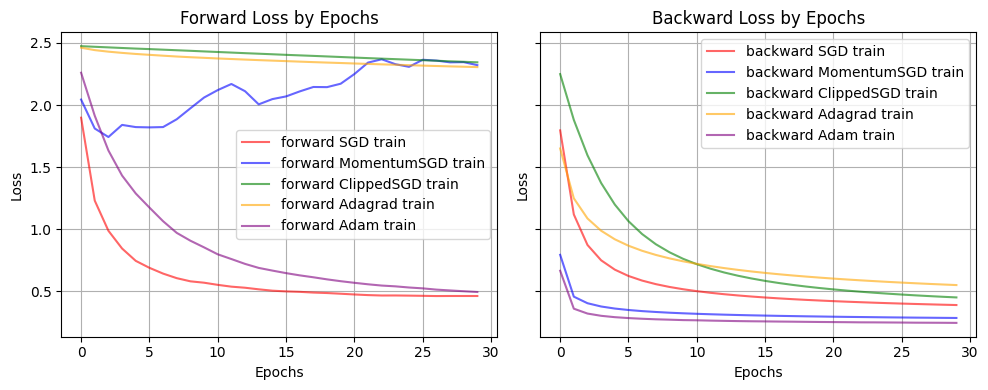

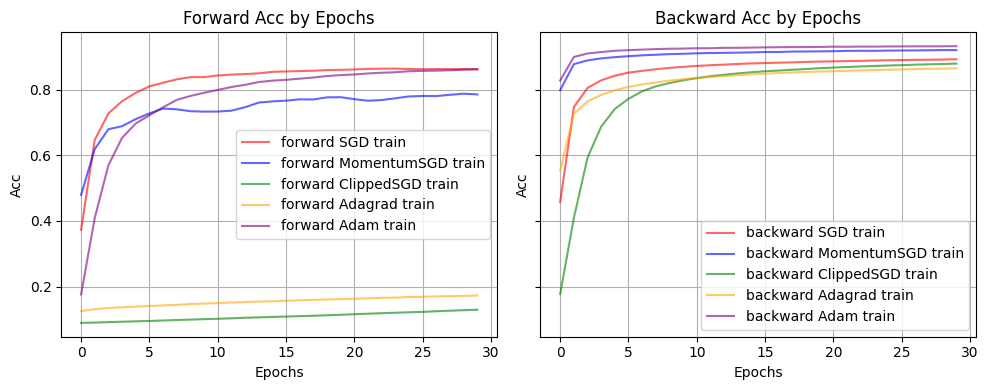

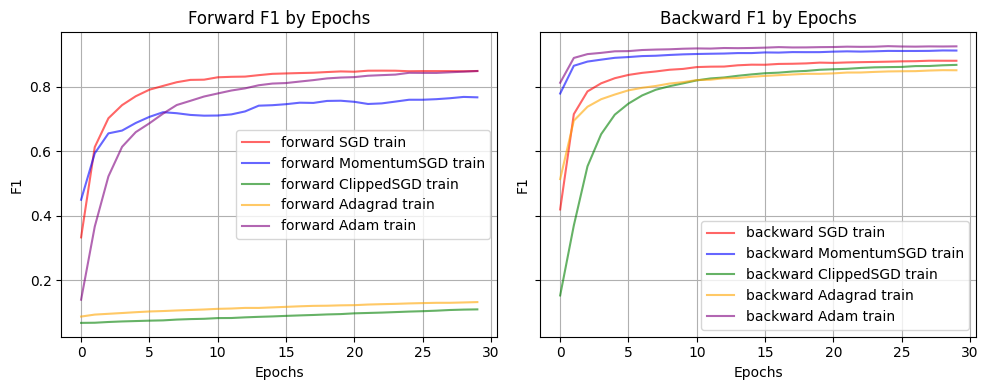

In [9]:
plot_comparison(train_run_epochs, optimizers)

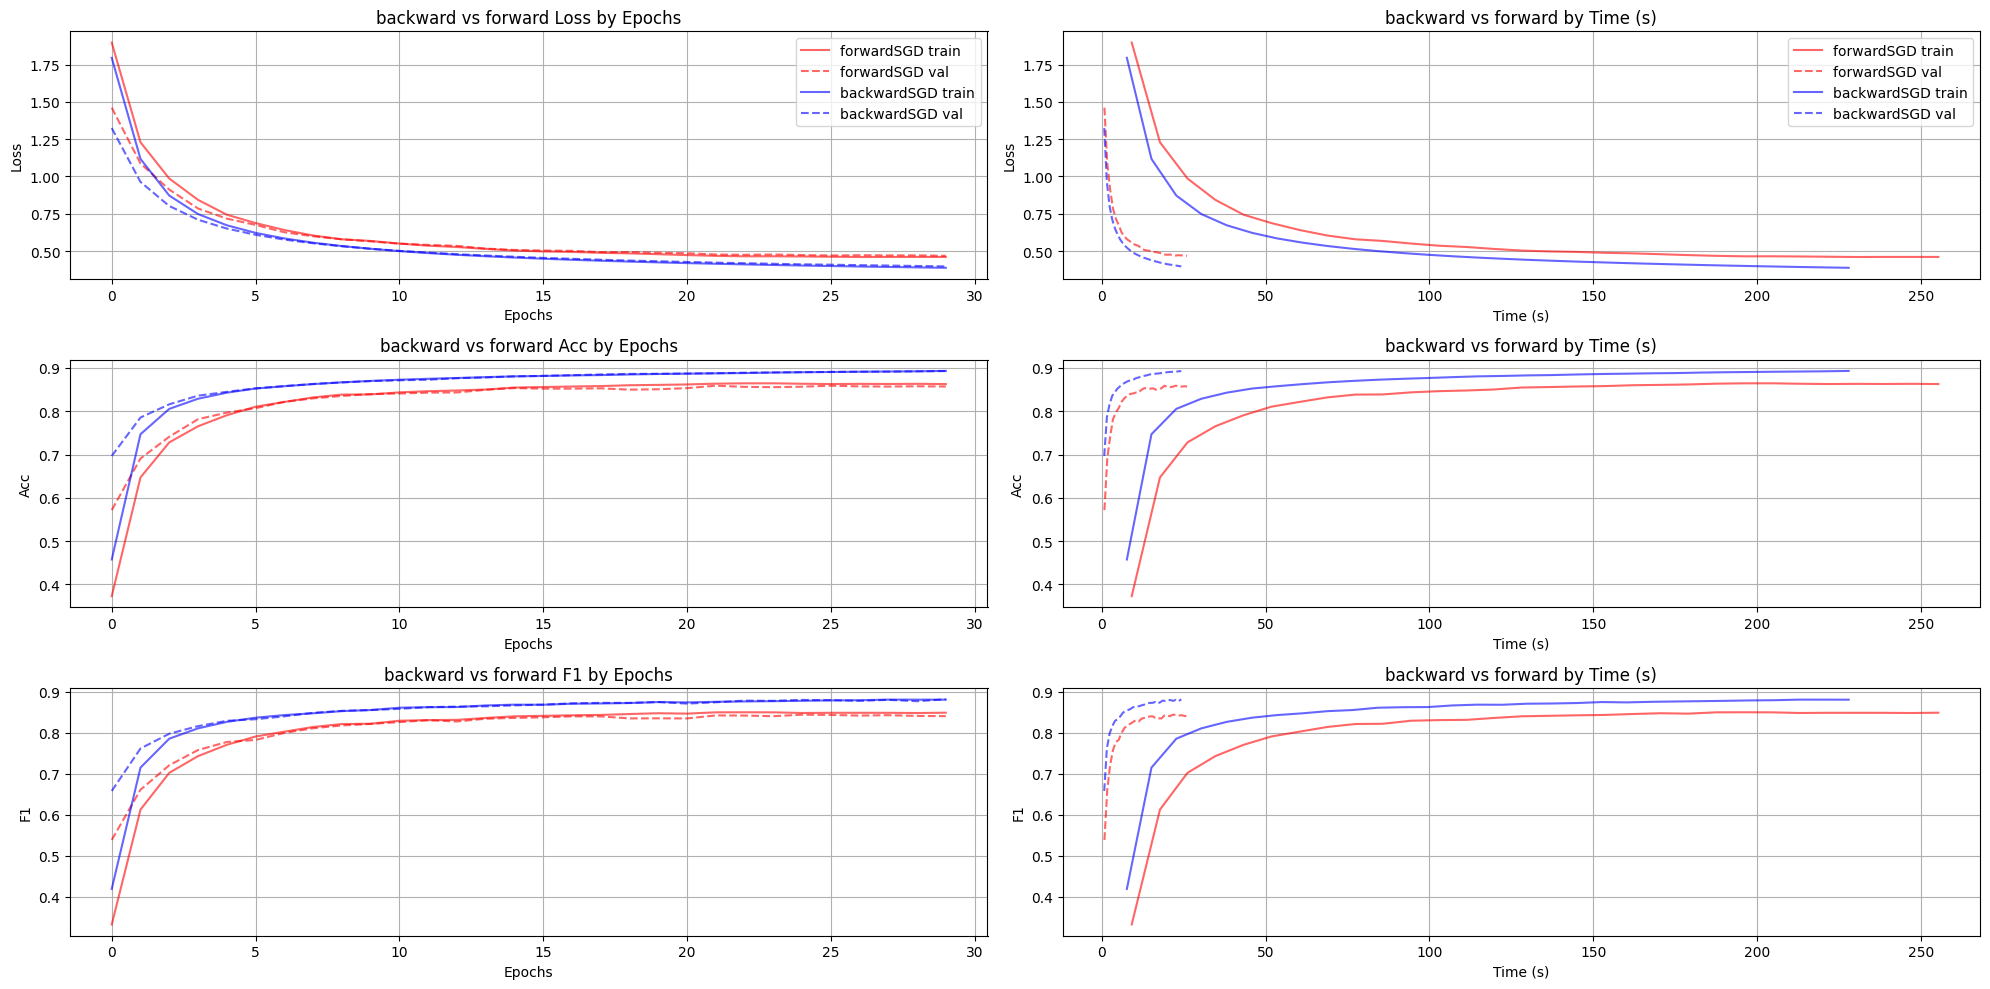

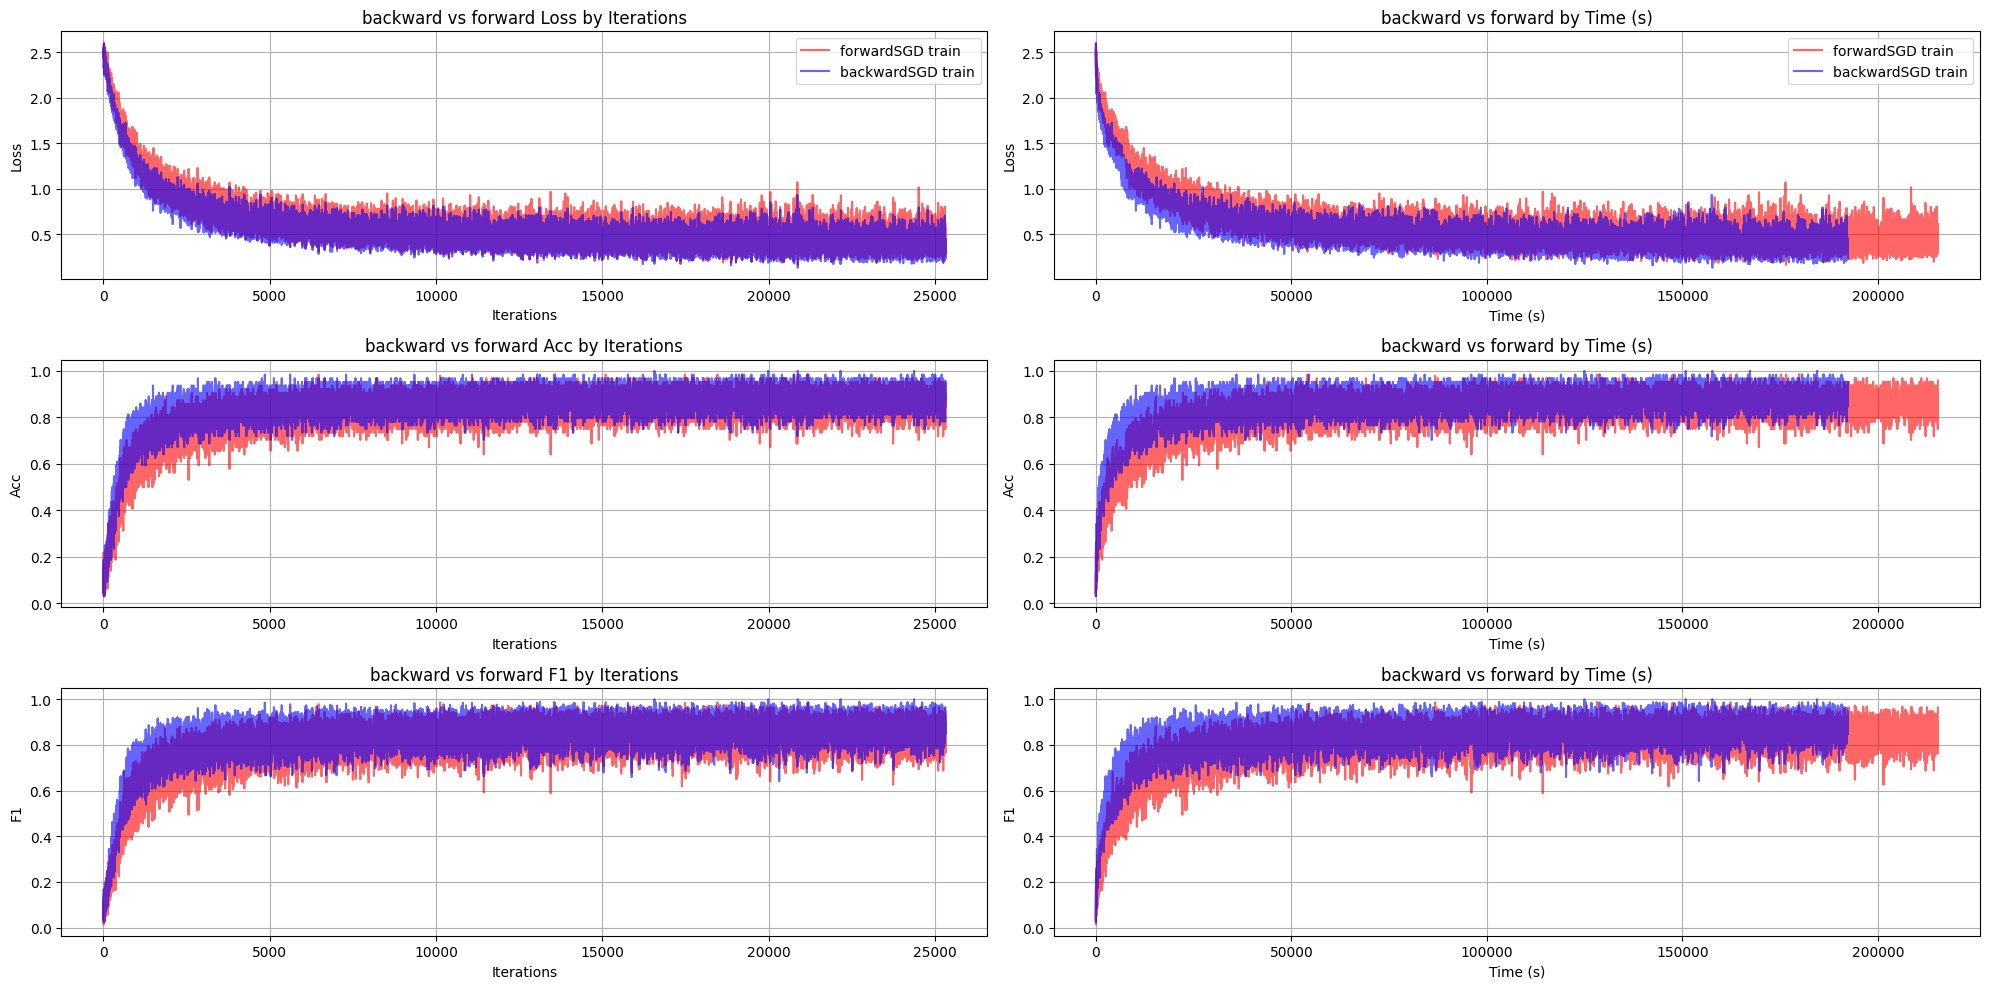

In [10]:
plot_train_valid(train_run_epochs, "SGD", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "SGD", "Iterations")

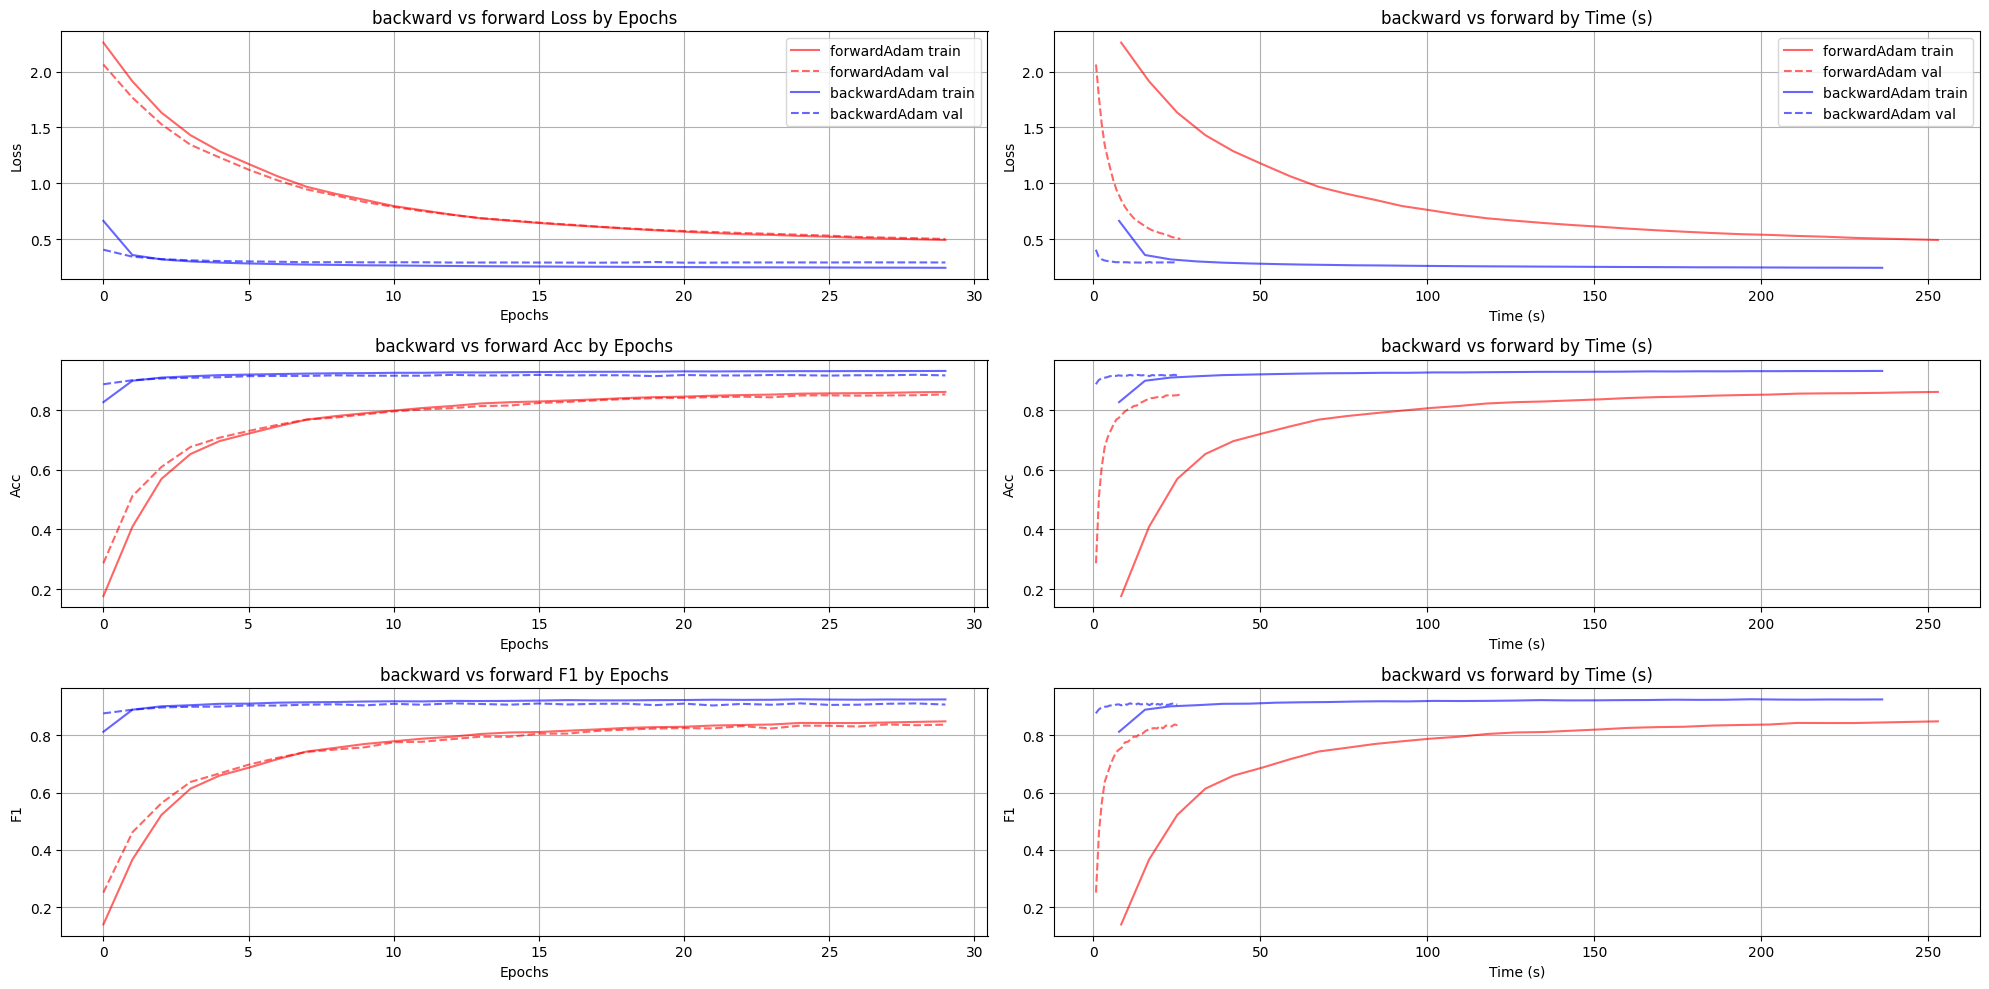

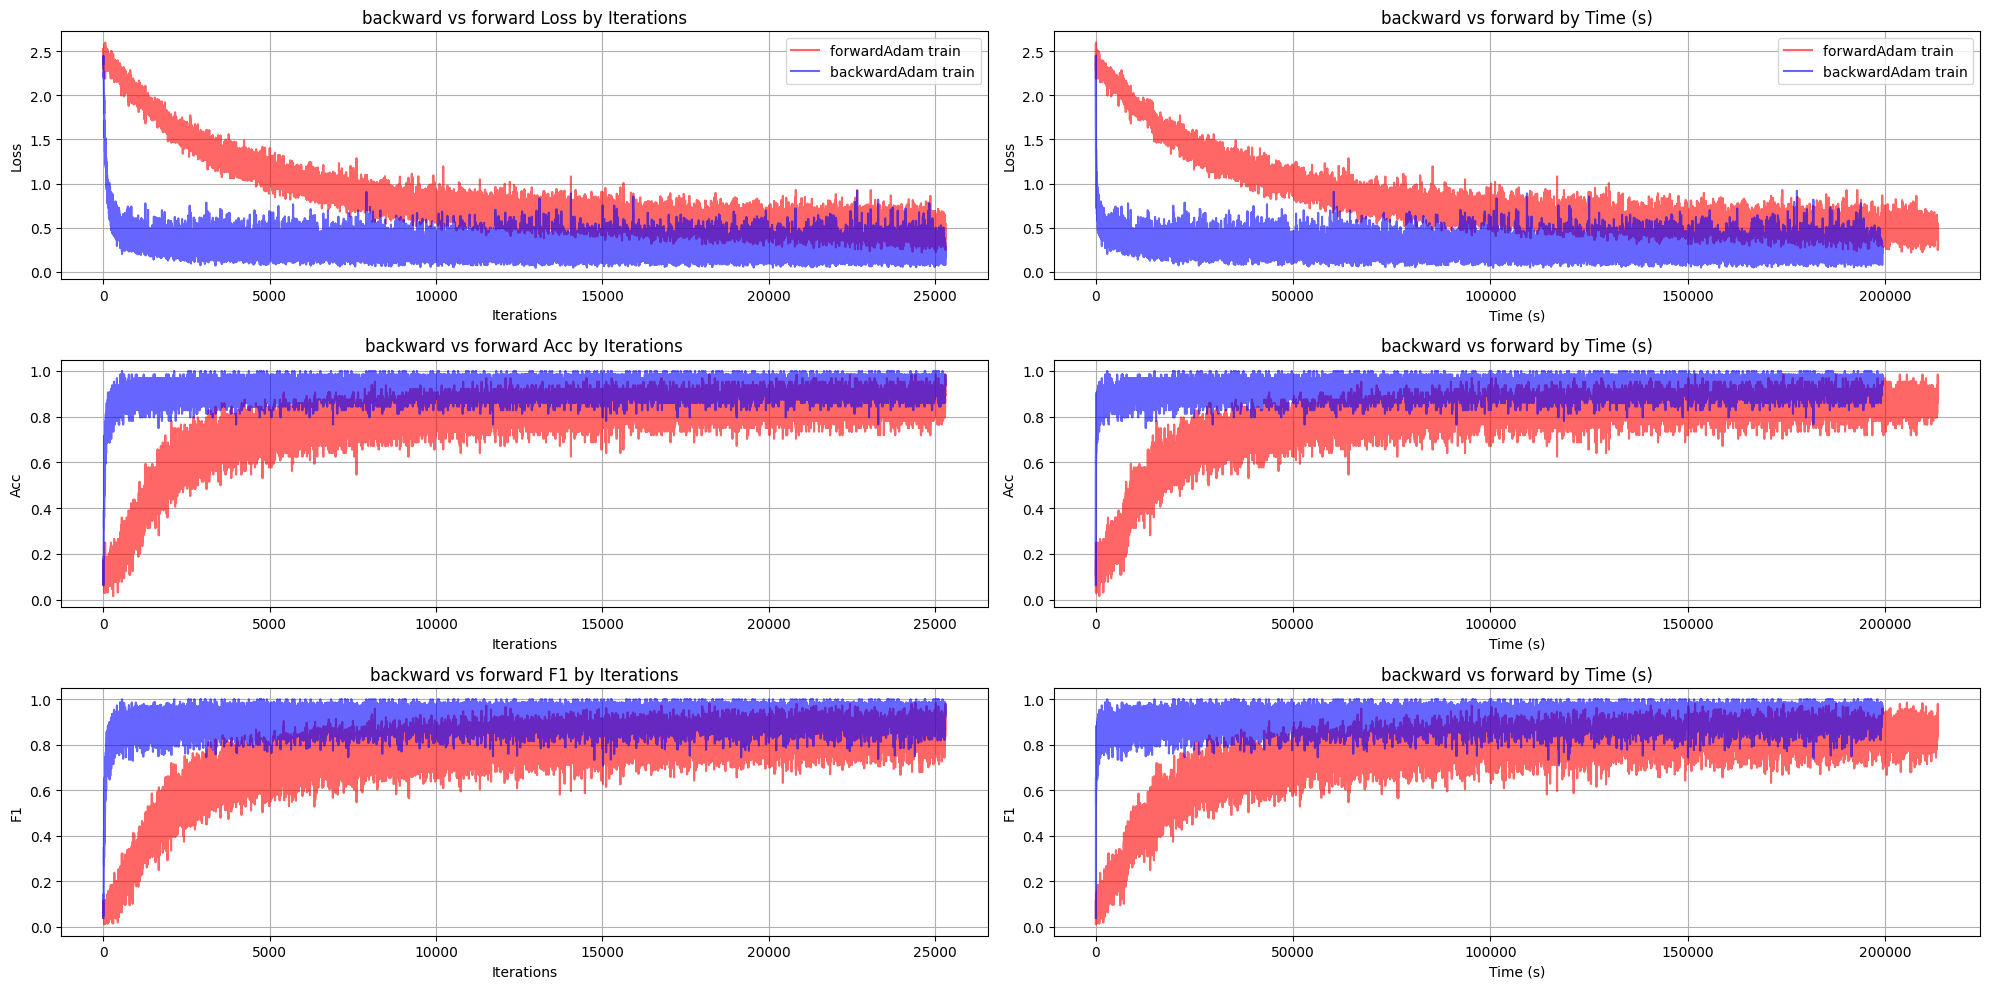

In [11]:
plot_train_valid(train_run_epochs, "Adam", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "Adam", "Iterations")

## Multi Layer Network

In [12]:
run_path_backward = {"SGD":"multiLayerNetSGDModel_start_14_06_2024_start_02h17m/",
"MomentumSGD":"multiLayerNetMomentumSGDModel_start_14_06_2024_start_02h25m/",
"ClippedSGD":"multiLayerNetClippedSGDModel_start_14_06_2024_start_02h34m/",
"Adagrad":"multiLayerNetAdagradModel_start_14_06_2024_start_02h43m/",
"Adam":"multiLayerNetAdamModel_start_14_06_2024_start_02h52m/"}

run_path_forward = {"SGD":"multiLayerNetSGDModel_start_14_06_2024_start_03h01m/",
"MomentumSGD":"multiLayerNetMomentumSGDModel_start_14_06_2024_start_03h10m/",
"ClippedSGD":"multiLayerNetClippedSGDModel_start_14_06_2024_start_03h19m/",
"Adagrad":"multiLayerNetAdagradModel_start_14_06_2024_start_03h28m/",
"Adam":"multiLayerNetAdamModel_start_14_06_2024_start_03h38m/"}

train_run_epochs, train_run_its, val_run_epochs, val_run_its, metrics = load_runs(run_path_forward, run_path_backward, optimizers,"multiLayerNet_runs")

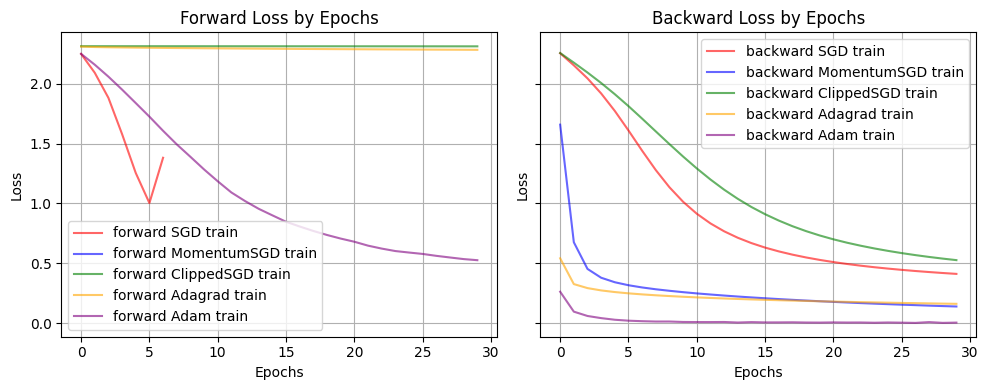

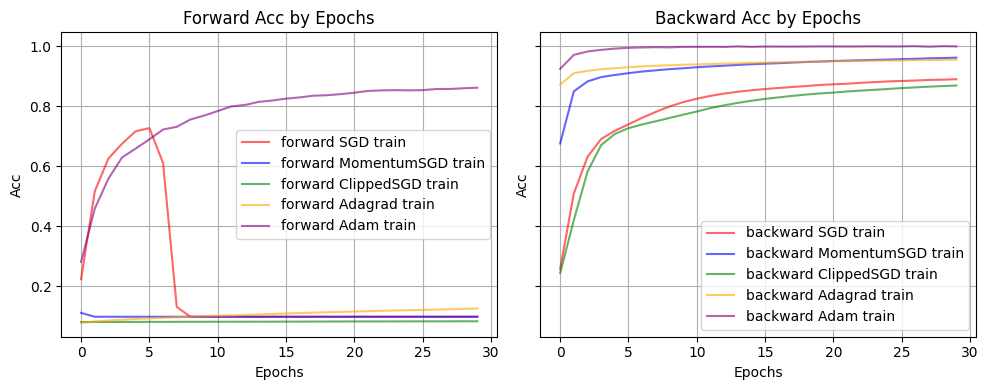

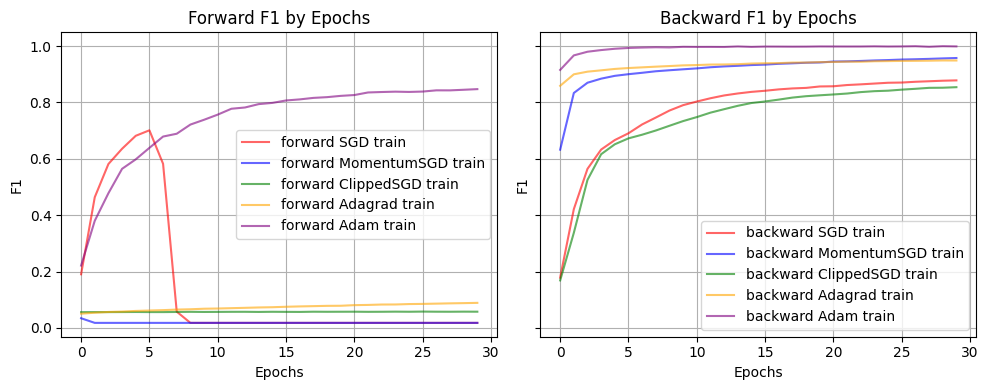

In [13]:
plot_comparison(train_run_epochs, optimizers)

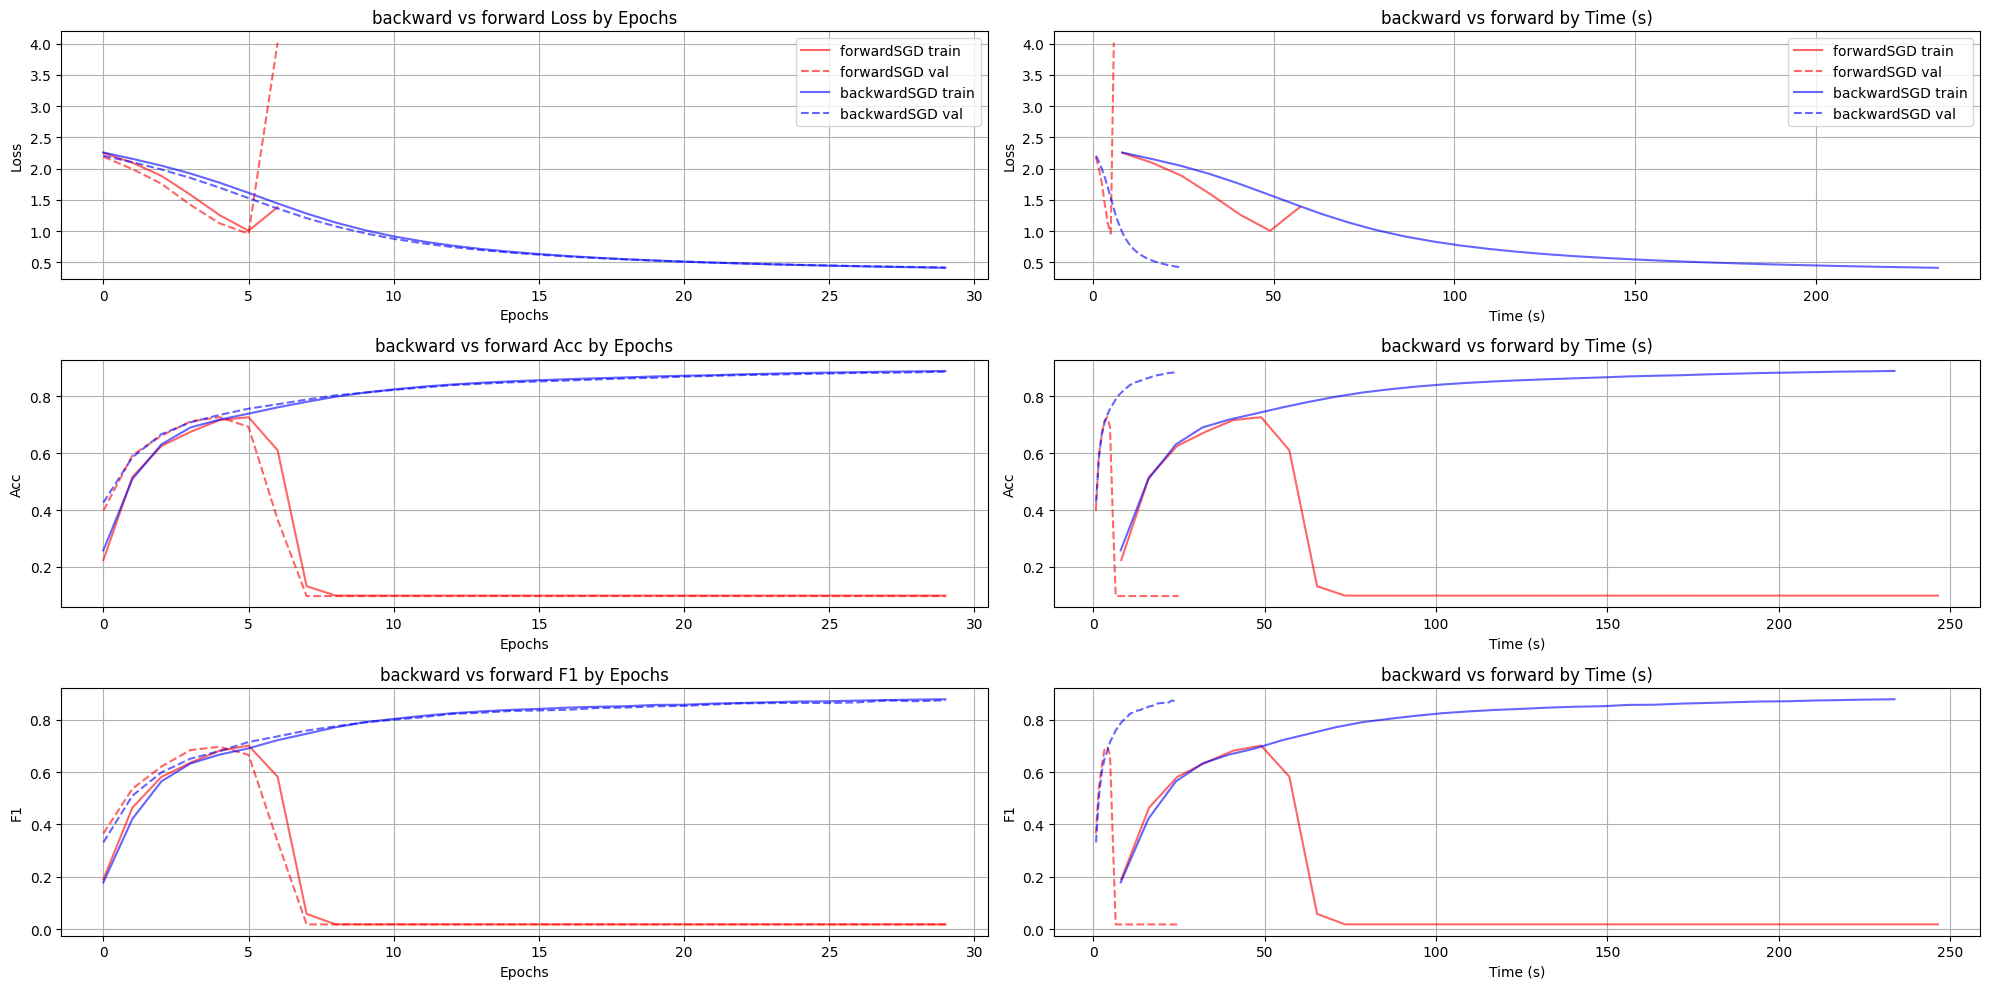

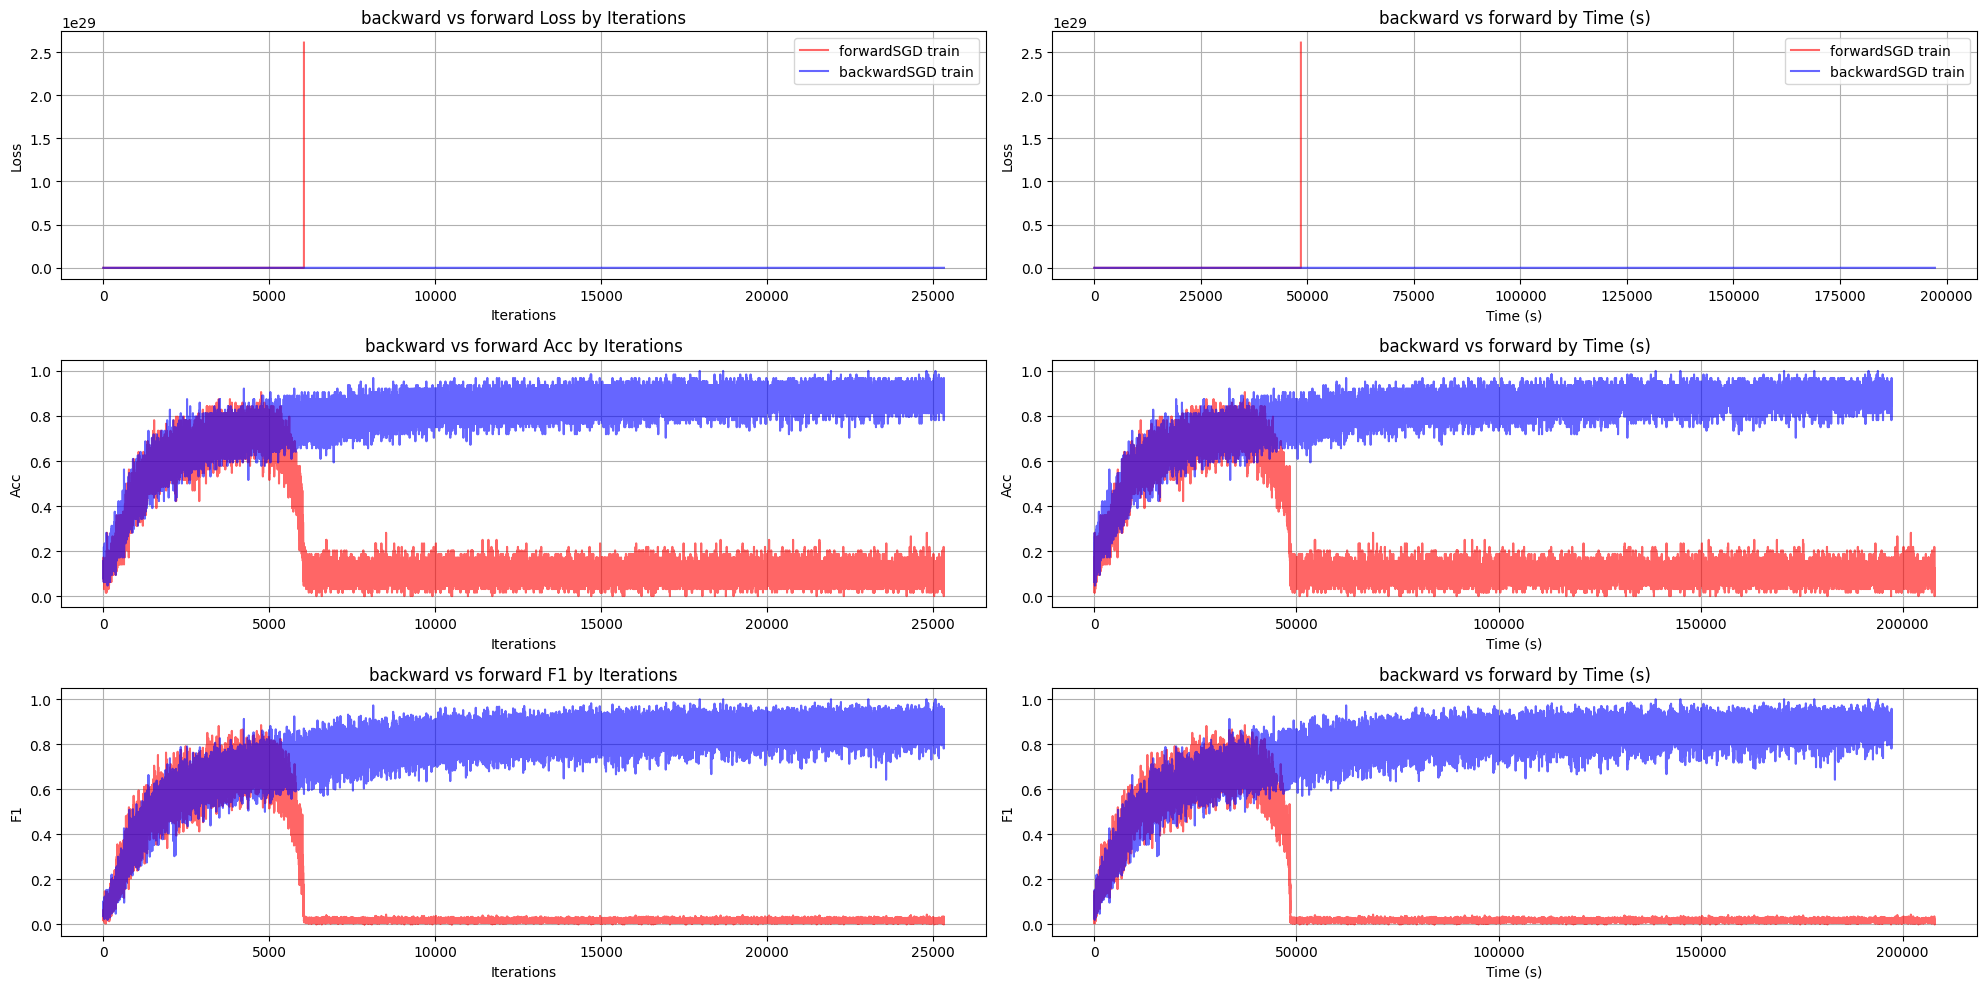

In [14]:
plot_train_valid(train_run_epochs, "SGD", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "SGD", "Iterations")

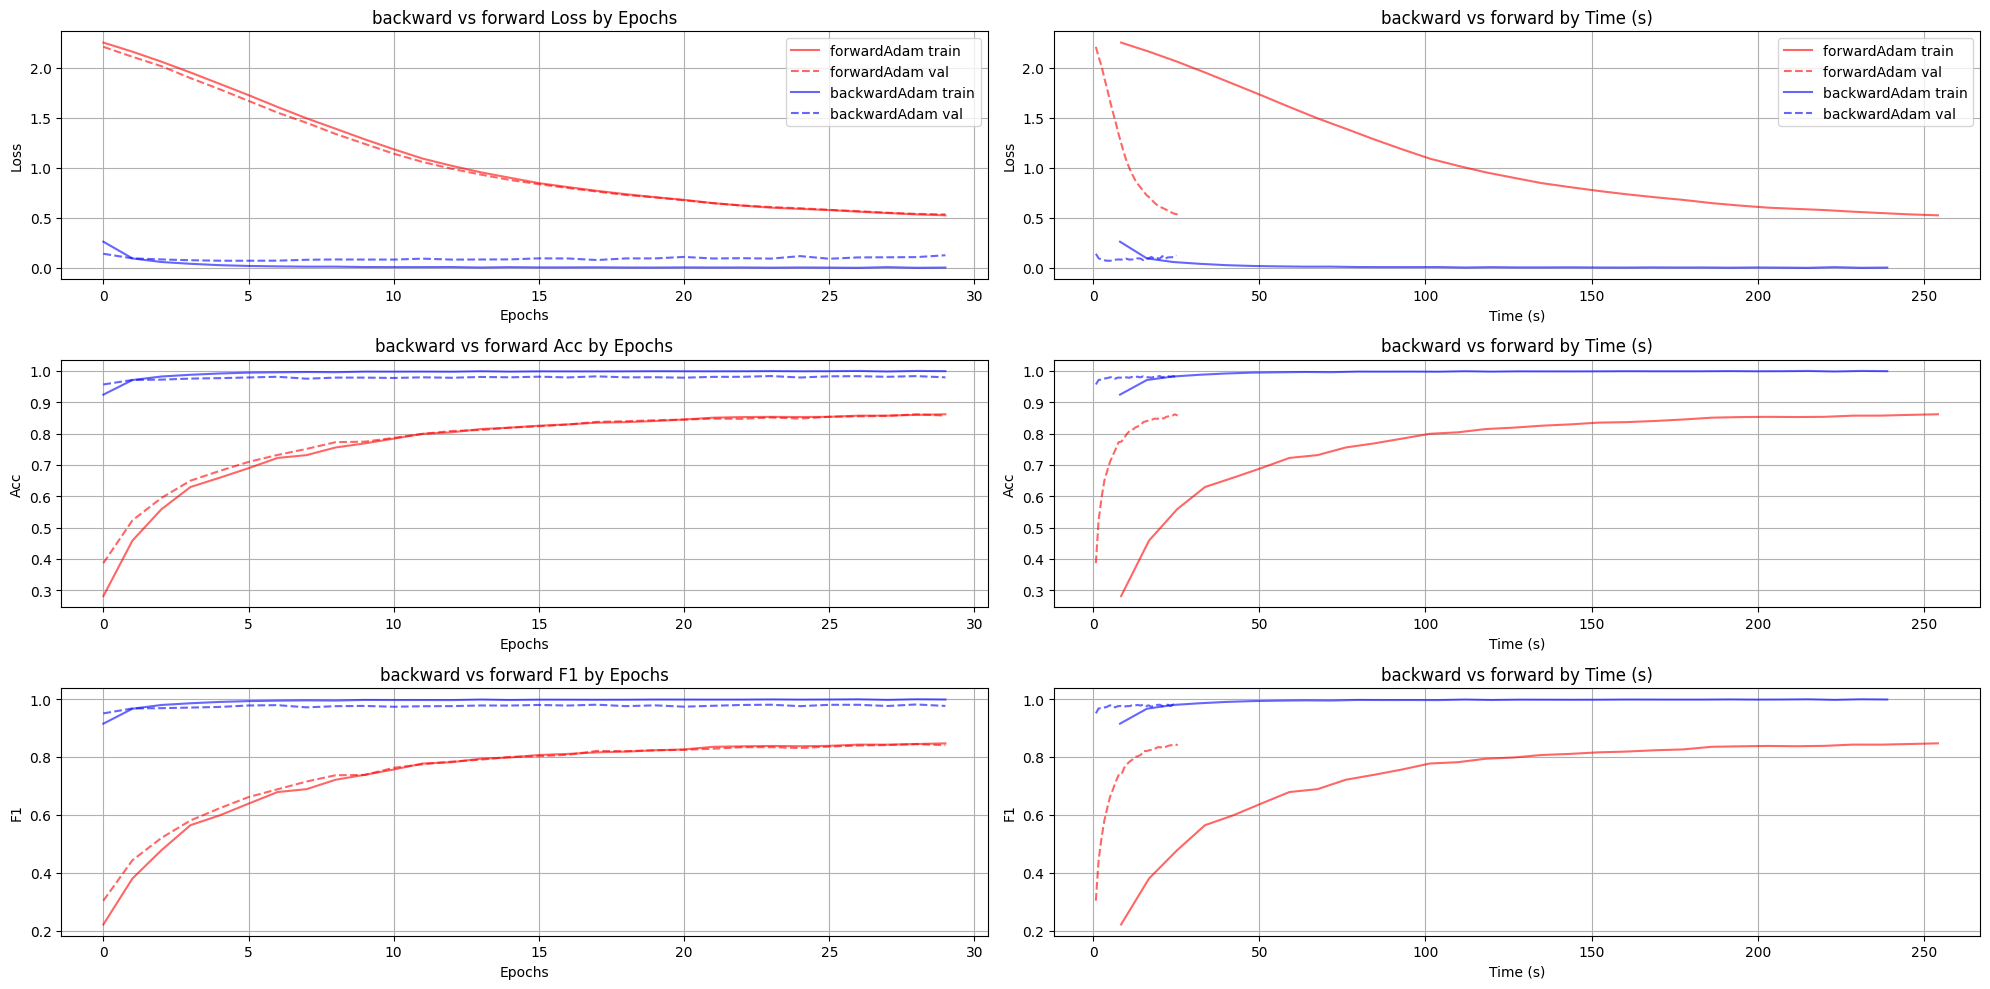

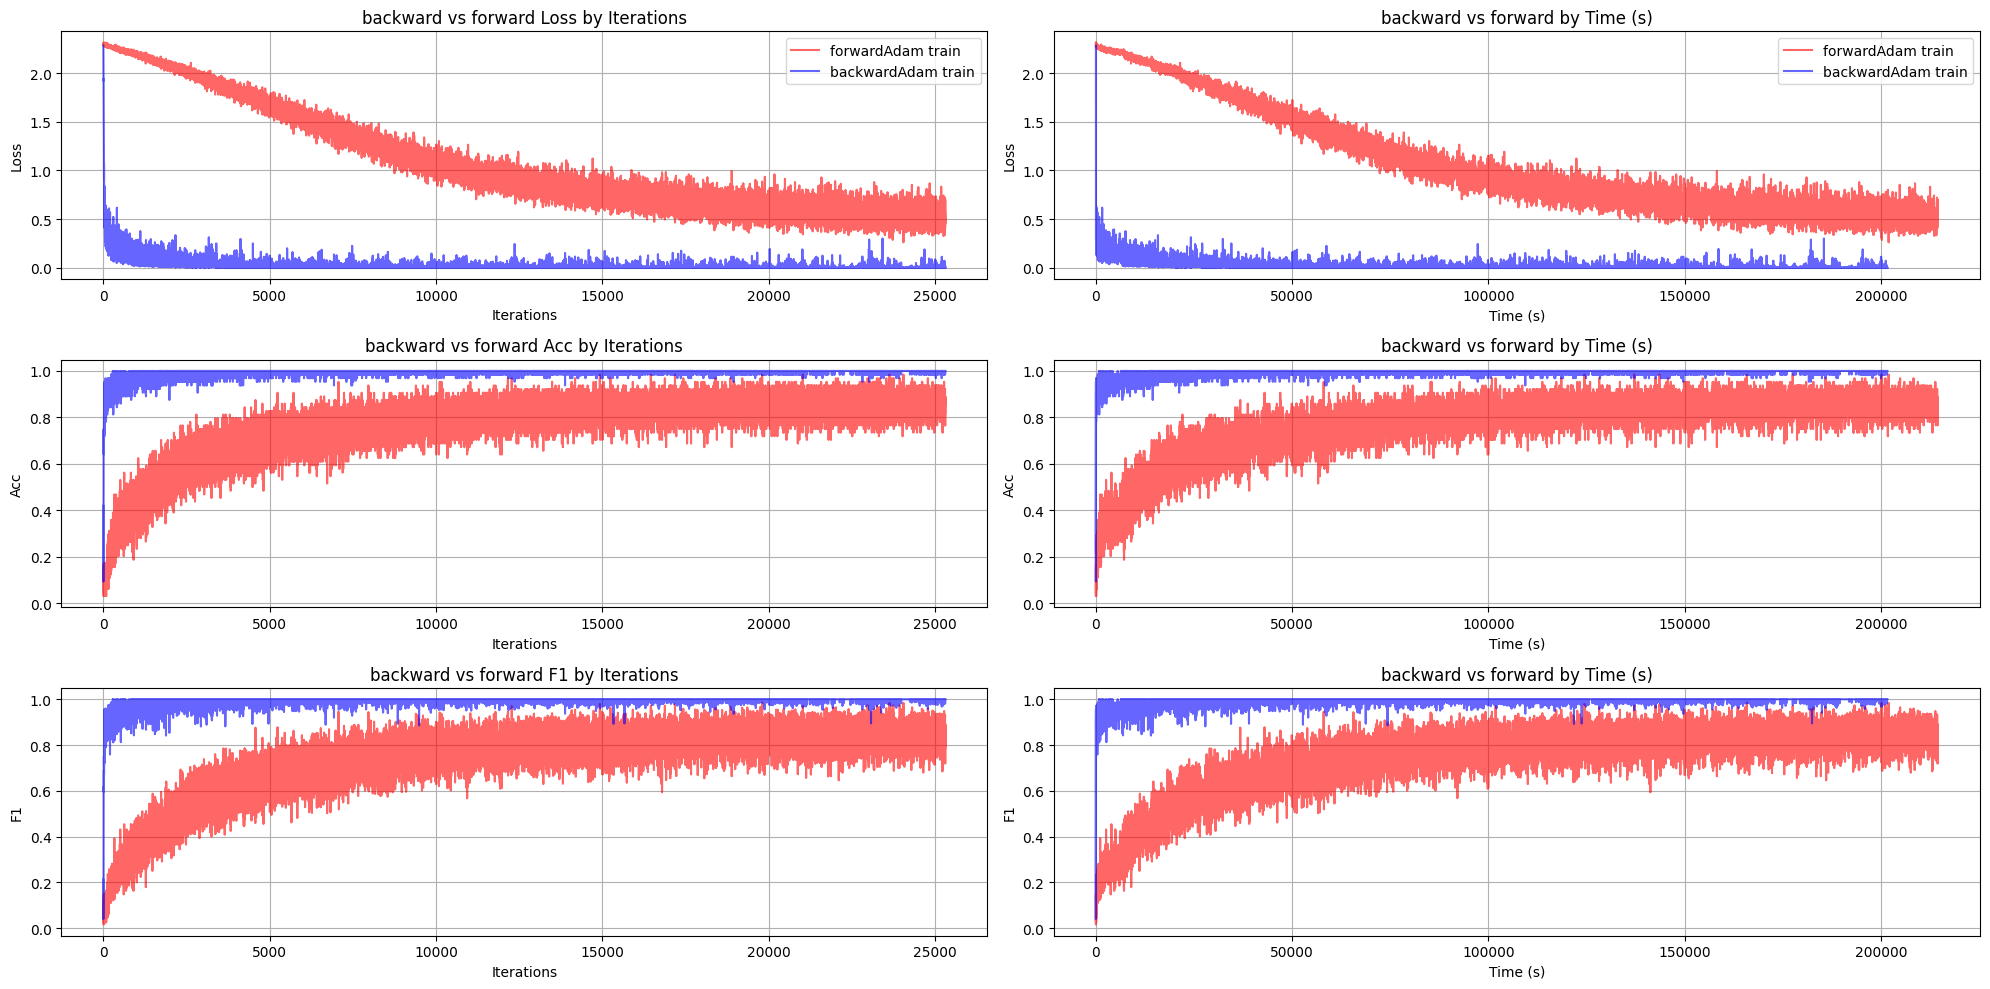

In [15]:
plot_train_valid(train_run_epochs, "Adam", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "Adam", "Iterations")

## Convolutional Network

In [16]:
run_path_forward = {"SGD":"convNetSGDModel_start_14_06_2024_start_04h51m/",
"MomentumSGD":"convNetMomentumSGDModel_start_14_06_2024_start_05h01m/",
"ClippedSGD":"convNetClippedSGDModel_start_14_06_2024_start_05h12m/",
"Adagrad":"convNetAdagradModel_start_14_06_2024_start_05h22m/",
"Adam":"convNetAdamModel_start_14_06_2024_start_05h32m/"}

run_path_backward = {"SGD":"convNetSGDModel_start_14_06_2024_start_04h02m/",
"MomentumSGD":"convNetMomentumSGDModel_start_14_06_2024_start_04h12m/",
"ClippedSGD":"convNetClippedSGDModel_start_14_06_2024_start_04h22m/",
"Adagrad":"convNetAdagradModel_start_14_06_2024_start_04h31m/",
"Adam":"convNetAdamModel_start_14_06_2024_start_04h41m/"}

train_run_epochs, train_run_its, val_run_epochs, val_run_its, metrics = load_runs(run_path_forward, run_path_backward, optimizers, "convNet_runs")

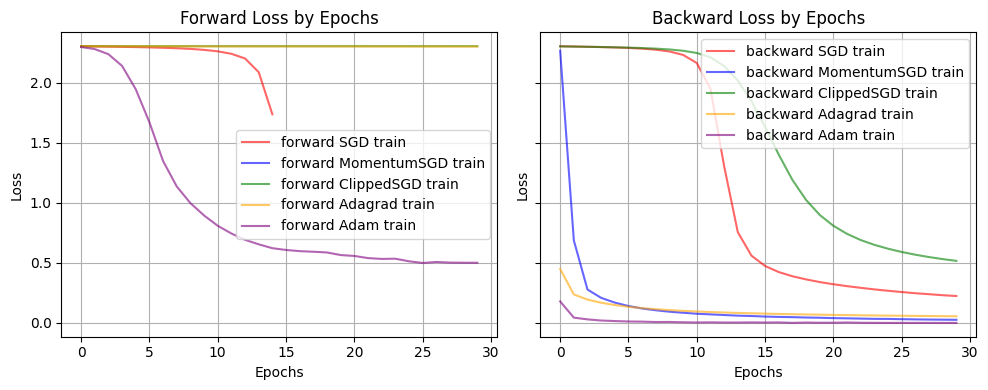

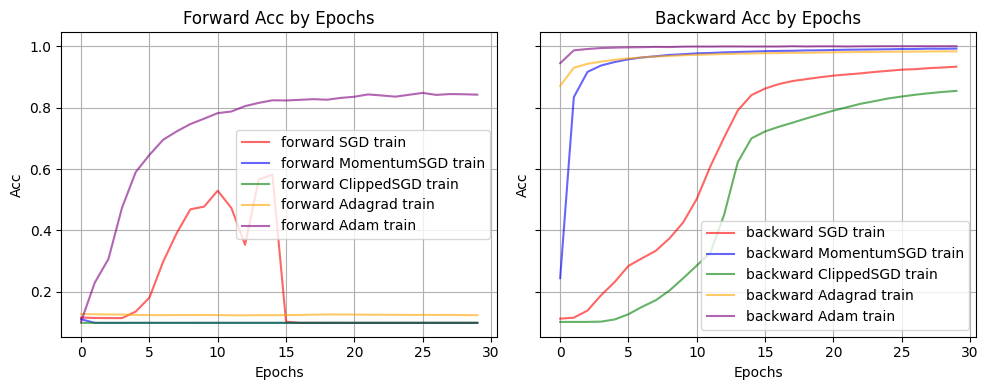

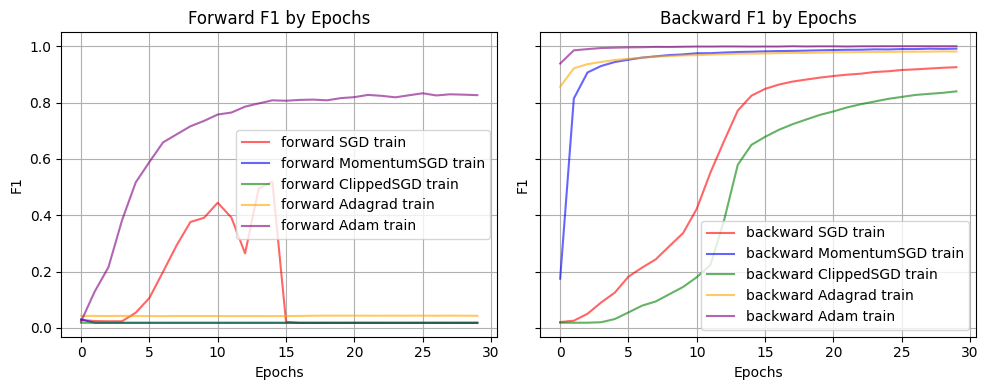

In [21]:
plot_comparison(train_run_epochs, optimizers)

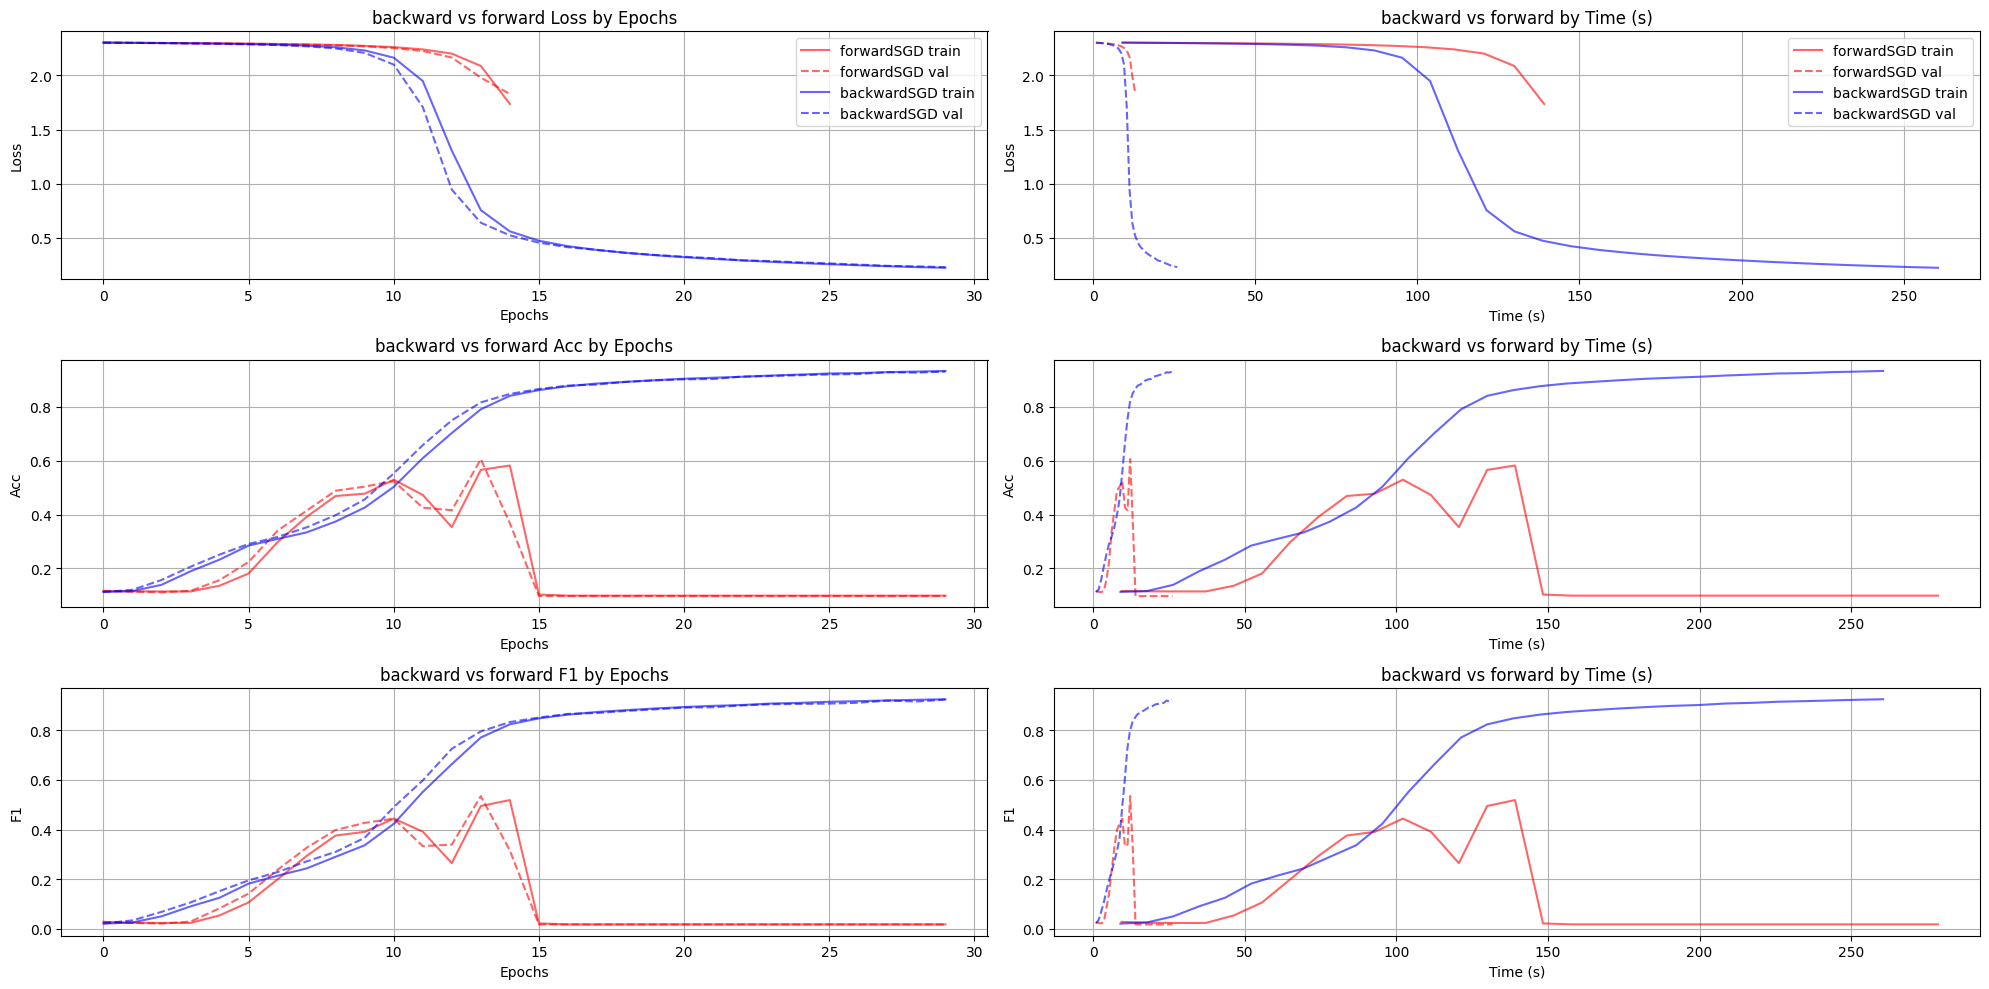

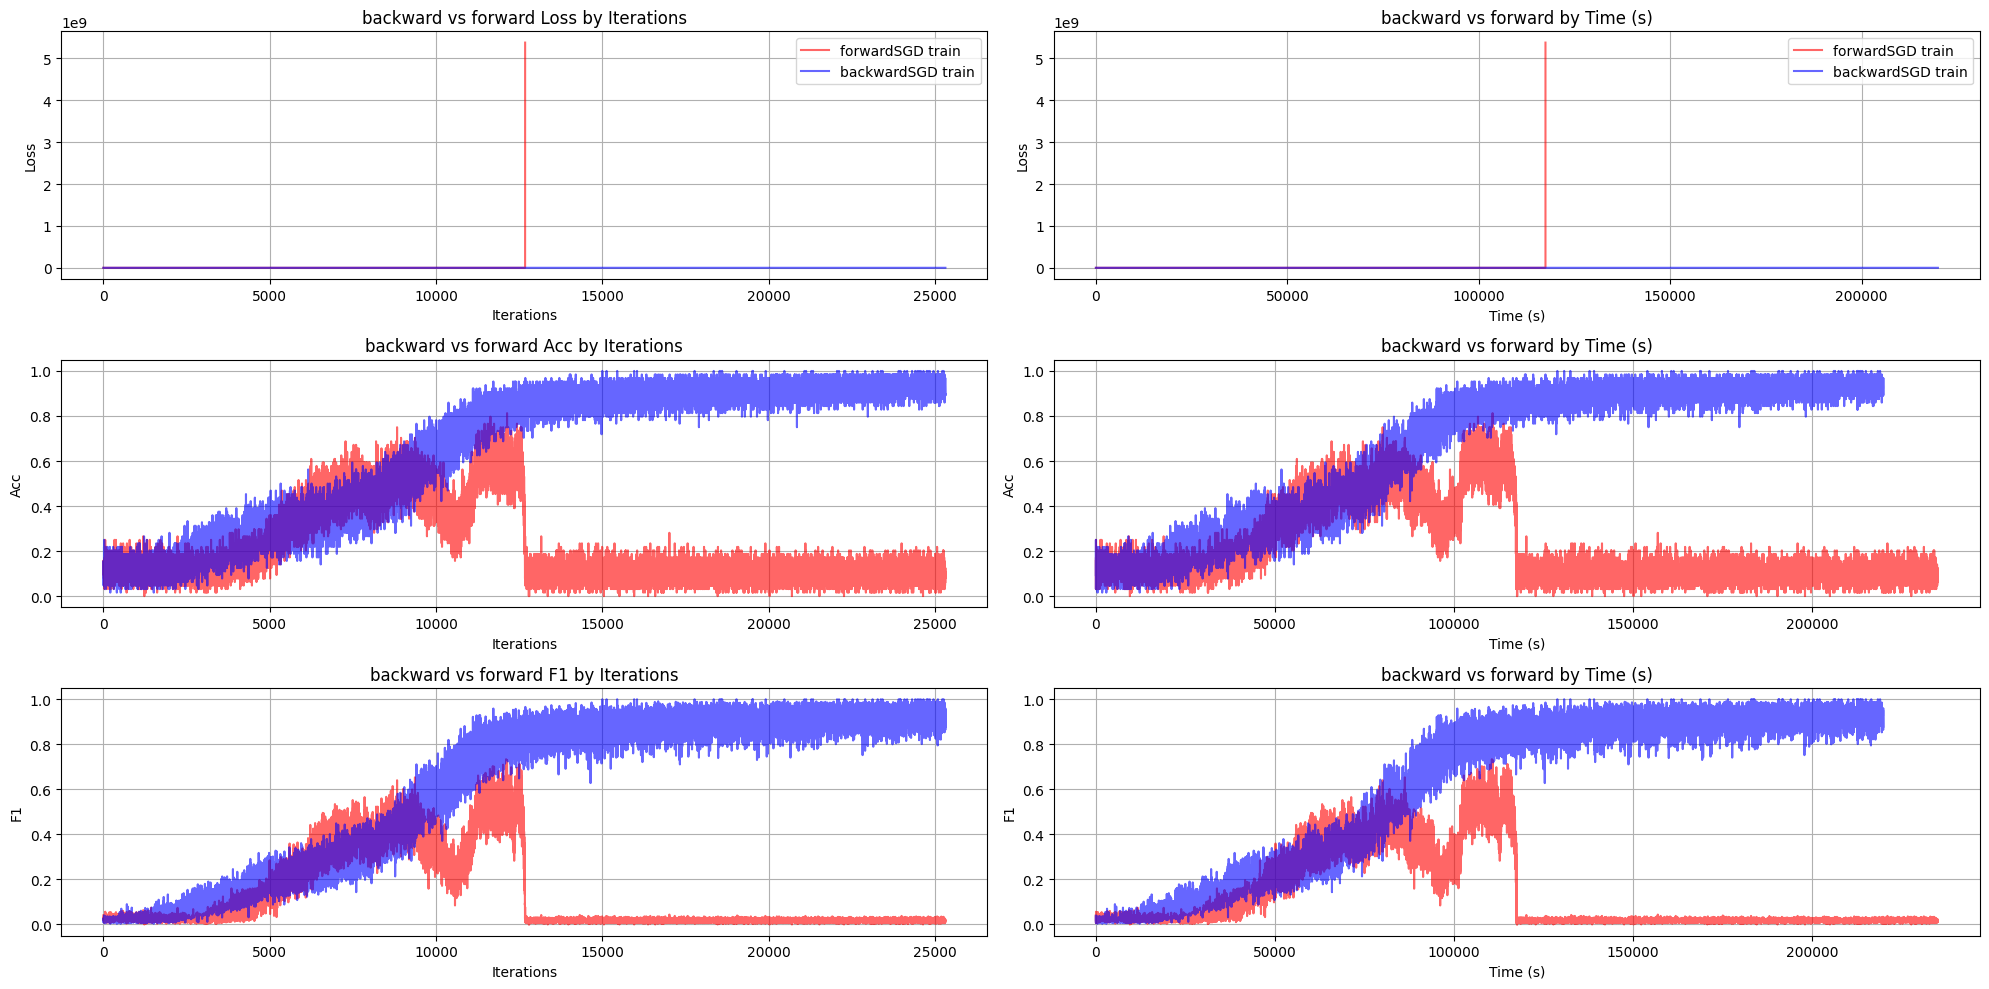

In [22]:
plot_train_valid(train_run_epochs, "SGD", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "SGD", "Iterations")


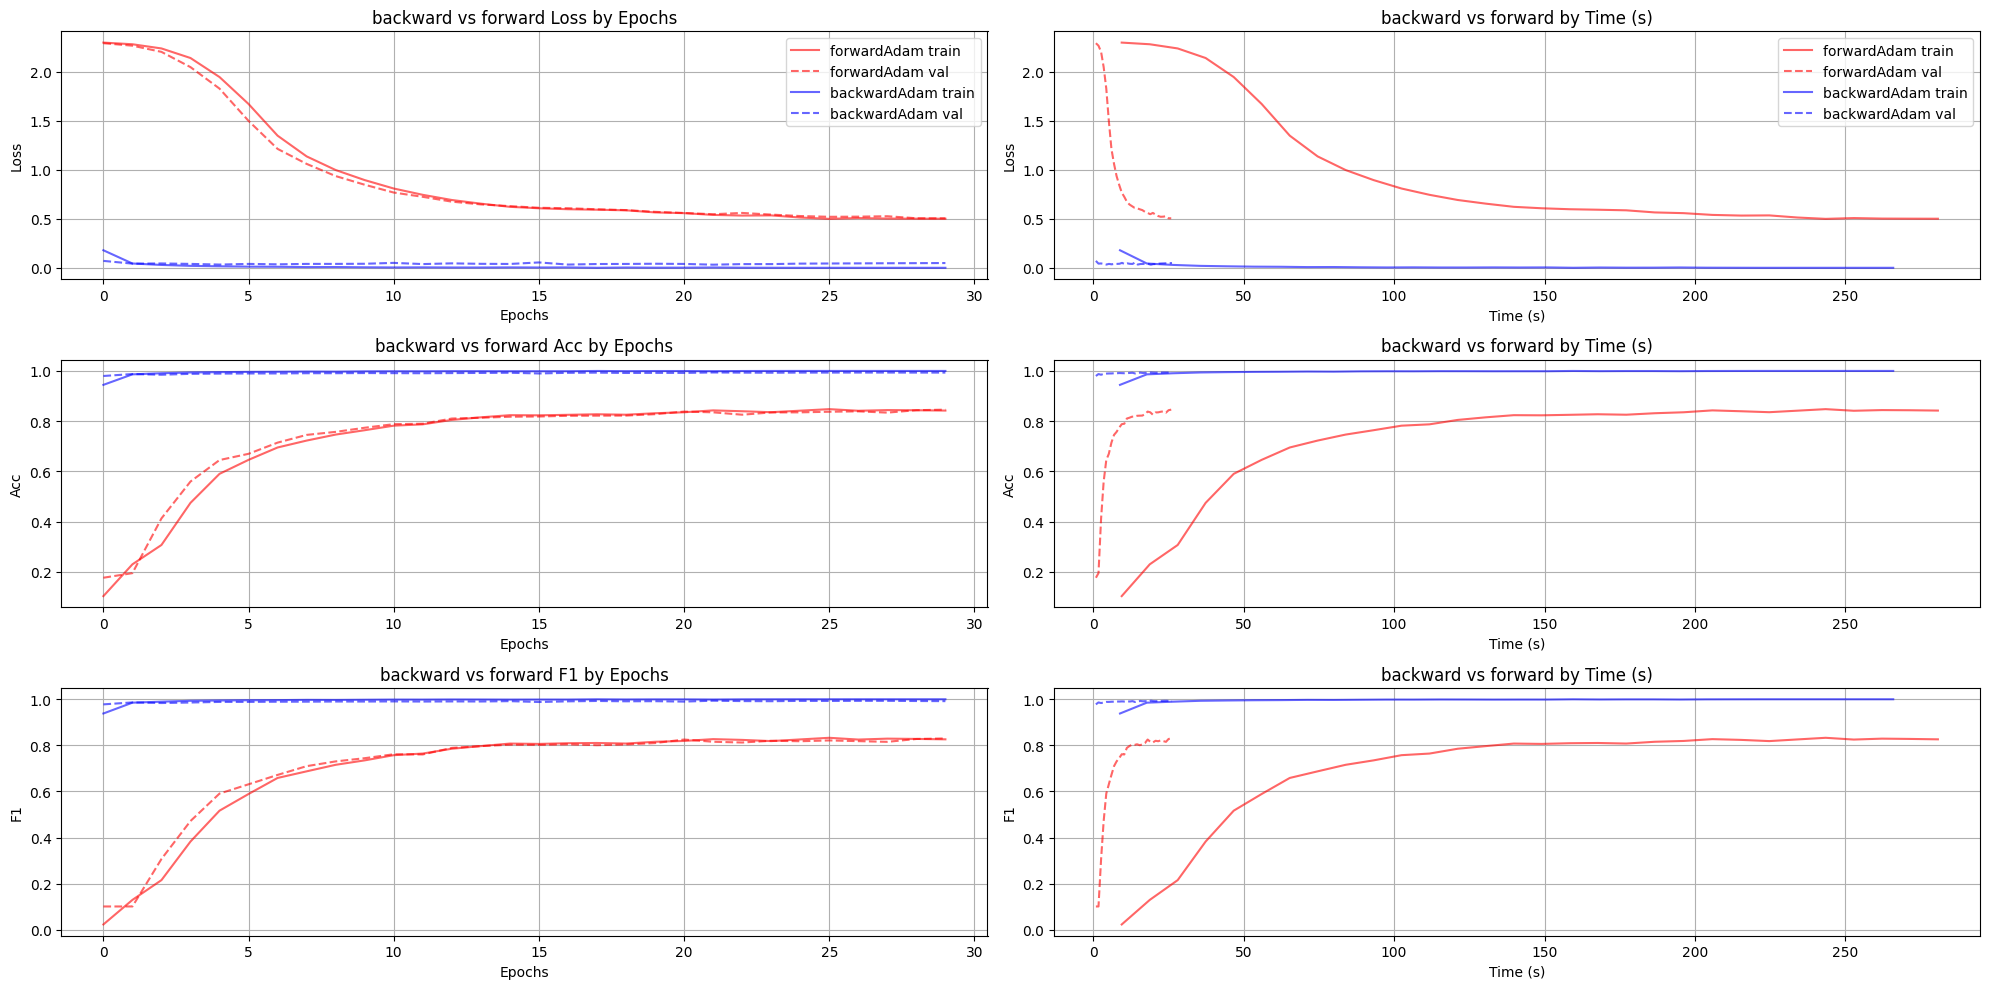

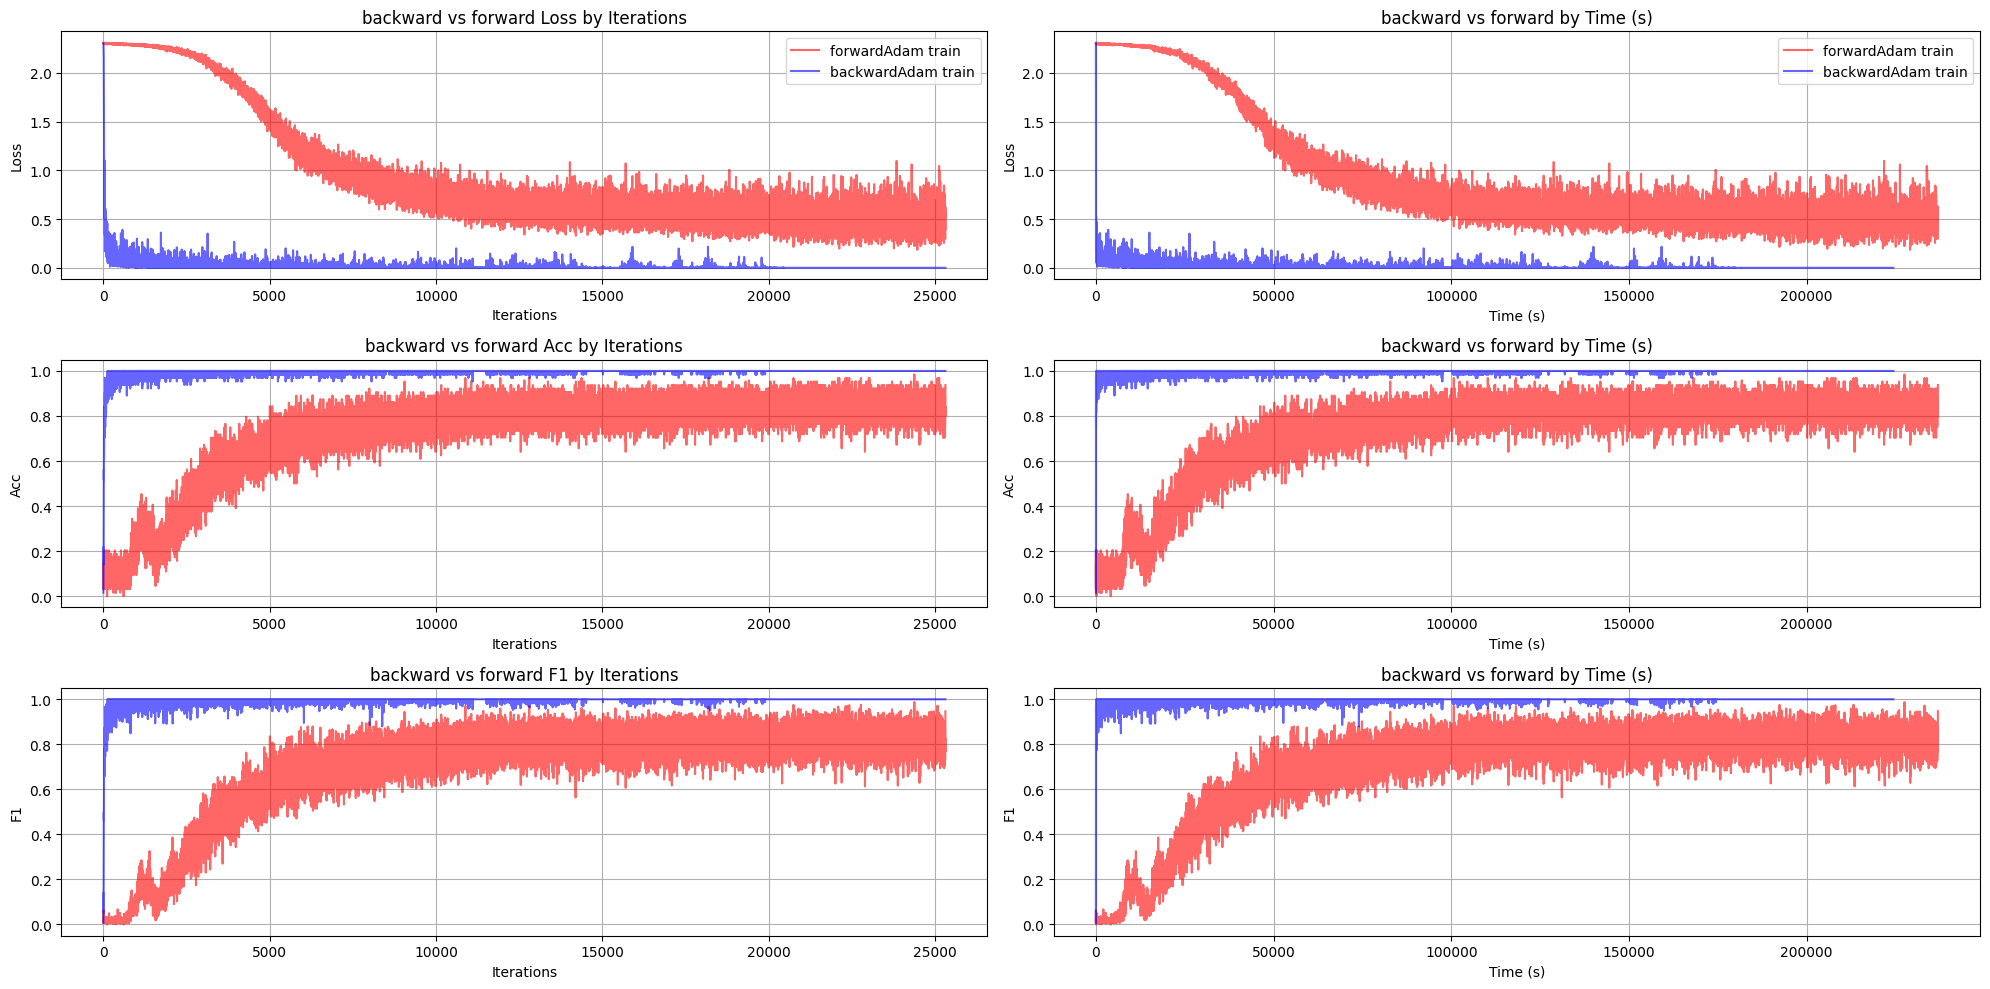

In [23]:
plot_train_valid(train_run_epochs, "Adam", "Epochs", val_run_epochs)
plot_train_valid(train_run_its, "Adam", "Iterations")